## Main code to analyse preservation trends in bar packages. 
Inputs = CSVs with bar stats, and various input arrays for package statistics

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from matplotlib import cm
from pylab import *
import matplotlib.colors as mcol
from matplotlib.colors import LinearSegmentedColormap


import os
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats

In [6]:
## Set Color maps for plots and plot aesthetics

coher_cols = ['#276419', '#9ccf64', '#f7f7f7', '#e896c4', '#8e0152'] ##PiYG 5 steps
coher_cols_seq = ['#d8ffff', '#85d9f0', '#2cb0e0', '#0083c6', '#0057a7'] #light blue to blue
# pres_cols = ['xkcd:pink', 'xkcd:lavender', 'xkcd:light grey'] #pink = FP, lav = PP, blue = TR
pres_cols = ['xkcd:primary blue', 'xkcd:soft blue', 'xkcd:pink red']
pres_cols = ['#e08266', '#feb9a8', '#8da0ae']##for SANCAS and AGU
proc_cols = ['#ff8500', '#ffca20', '#ffffe0', '#bf74e7', '#8044da'] #(orange to purple) agg to lat acc
pres_palette = sns.color_palette(pres_cols)
coh_palette = sns.color_palette(coher_cols_seq)
proc_palette = sns.color_palette(proc_cols)

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

Import files

In [7]:
## import datamaster for comparative statistics
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'
eqt = 65

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
paper_fig_path = '/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/'
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

In [8]:
adjustment_time = 65

In [9]:
perc_untouched = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_percent_untouched.npy') ## channel profile for each timestep

In [10]:
filenm = 'agubh2-250mint'
xlsxname = filenm+'.xlsx'
savefilesto = '/Volumes/SAF_Data/bar-manuscript_sum22/data-interp/'
mypath = f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{xlsxname}'
allbars = pd.read_excel(mypath, header=0, usecols = 'A:BF') ## change if you add more columns to the raw dataset
eqt = 65 ## time for the bed to equilibrate

## import all additional datasets
## array of number of active channels
active_channels = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_active_channels-ud.npy') 

## array of wetted width
wetted_width = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2WWmaster-ud.npy') 
wetted_width[:adjustment_time, :] = np.nan 

##csv of skewness values of centroids
# skewness = pd.read_csv('/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/CentroidTrajectories_Skew.csv') 
# skewness['File'] = skewness['File'].str.replace('.npy', '')

## array of thickness measurements of packages like Sinead
# cvs = pd.read_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/LysterthicknessCVs.csv') 
# cvs['File'] = cvs['File'].str.replace('.npy', '')

# for col, dat in cvs.iloc[:, 6:].iteritems():
#     cvs[col] = cvs[col].str.replace('[', '', regex = False)
#     cvs[col] = cvs[col].str.replace(']', '', regex = False)
#     cvs[col] = cvs[col].astype(float)

In [11]:
bar_facies = pd.read_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/concat-files/facies-props-agubh2_agu22-250m.csv')

### Add extra ratios to allbars dataframe


In [12]:
allbars['CVFlowDepth'] = allbars['SDFlowDepth']/allbars['MeanFlowDepth']
allbars['CVVelocity'] = allbars['SDVelocity']/allbars['MeanVelocity']
allbars['VarFlowDepth'] = allbars['SDFlowDepth']**2
allbars['VarVelocity'] = allbars['SDVelocity']**2
allbars['Skew Abs'] = abs(allbars['Angle Skewness'])


allbars['TempAgg'] = allbars['MedClinoHt']/allbars['MaxClinoHt']
allbars['Skew Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['Skew Abs'] > 1, allbars['Skew Abs'] < 3), 'Skew Binned'] = 1
allbars.loc[allbars['Skew Abs'] < 1, 'Skew Binned'] = 0
allbars.loc[allbars['Skew Abs'] > 3, 'Skew Binned'] = 2

allbars['Co Binned'] = allbars['Skew Abs']
allbars.loc[np.logical_or(allbars['CoherenceVal'] > 2, allbars['CoherenceVal'] <= 3), 'Co Binned'] = 1
allbars.loc[allbars['CoherenceVal'] <= 2, 'Co Binned'] = 0

allbars.loc[allbars['CoherenceVal'] > 3, 'Co Binned'] = 2

allbars['BSR Binned'] = allbars['Basal Surf Relief']
allbars.loc[np.logical_or(allbars['Basal Surf Relief'] > 0.5, allbars['Basal Surf Relief'] < 1), 'BSR Binned'] = 1
allbars.loc[allbars['Basal Surf Relief'] < 0.5, 'BSR Binned'] = 0
allbars.loc[allbars['Basal Surf Relief'] > 1, 'BSR Binned'] = 2

## recalc facies
d50 = 0.00031
# chezy_rough = 18*(np.log10(4*allbars['MedFlowDepth']/d50)) #i think this is log10, else they would've put ln no?

med_mmp =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MeanFacies'] =(1000*(allbars['MeanVelocity']**2))/(1650*((18*(np.log10(4*allbars['MeanFlowDepth']/d50)))**2)*d50)##### modified mobility parameter
allbars['MedFacies'] =(1000*(allbars['MedVelocity']**2))/(1650*((18*(np.log10(4*allbars['MedFlowDepth']/d50)))**2)*d50)##### modified mobility parameter

allbars['BinFacMean'] = allbars['MeanFacies']
allbars.loc[allbars['MeanFacies'] < 0.17, 'BinFacMean'] = 'LB'
allbars.loc[allbars['MeanFacies'] > 0.17, 'BinFacMean'] = 'UB'

allbars['BarHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['MaxClino/MaxFD'] = allbars['MaxClinoHt']/allbars['MaxFlowDepth']
allbars['MaxClino/MedFD'] = allbars['MaxClinoHt']/allbars['MedFlowDepth']
allbars['MedClino/MedFD'] = allbars['MedClinoHt']/allbars['MedFlowDepth']
allbars['MaxClino/MedFD'] = allbars['MaxClinoHt']/allbars['MedFlowDepth']

allbars['BFscaling'] = allbars['MaxClinoHt']/1.2
allbars['BL/CL'] = allbars['BarWidth']/allbars['MaxClinoWt']
allbars['ReconFlowDepth'] = allbars['MaxClinoHt'] ## I think its 0.7 
allbars['GrowthR8'] = allbars['BarArea']/allbars['ElapsedTime']
## Find the proportion of upper bar facies in each bar package

allbars['UBar'] = np.nan
allbars['mmpmean'] = np.nan
allbars['FaciesCV'] = np.nan

arrayfolder = 'agubh2_agu22-250m'
# init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/JULY142022'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{arrayfolder}'

for root, dirs, files in os.walk(init):
    for file in files:
        arr = np.load(os.path.join(root, file), allow_pickle = True)
        arrnm = file[:-4]
        mmp = arr[:, :, -1] ## the arrays already have the mmp values in them
        mmpmean = np.nanmean(mmp)
        mmpcv = np.nanstd(mmp)/np.nanmean(mmp)

        tot = np.count_nonzero(~np.isnan(mmp))
        pub = (mmp <= 0.025).sum()/tot
        plb = (mmp > 0.025).sum()/tot
        allbars.loc[allbars['array name']==arrnm, 'UBar'] = pub*100
        allbars.loc[allbars['array name']==arrnm, 'mmpmean'] = mmpmean
        allbars.loc[allbars['array name']==arrnm, 'FaciesCV'] = mmpcv

# allbars = pd.merge(allbars, skewness, left_on = 'array name', right_on = 'File')
# allbars = pd.merge(allbars, cvs, left_on = 'array name', right_on = 'File')

allbars['CVClinoWt'] = allbars['SDClinoWt']/allbars['MeanClinoWt']

In [13]:
allbars['PkgHeight/MaxFD'] = allbars['BarHeight']/allbars['MaxFlowDepth']
allbars['PkgHeight/MedFD'] = allbars['BarHeight']/allbars['MedFlowDepth']
allbars['PkgHeight/MeanFD'] = allbars['BarHeight']/allbars['MeanFlowDepth']

In [14]:
trainslist = allbars['array name'][allbars['TRAINFLAG'] == 'Y']
# trainslist.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/{filenm}-trainsonly.csv')

In [15]:
allbars['MeanAge'] = 0.5*(allbars['StartTime']+allbars['EndTime'])

In [16]:
allbars['MaxCMaxPkgHt'] = allbars['MaxClinoHt']/allbars['BarHeight']

In [17]:
meanTT = 13 ## model timestep, NOT DAYS, ~25 days
allbars['NumTurnovers'] = allbars['ElapsedTime']/meanTT

In [18]:
allbars.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'CoherenceVal',
       'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge', 'RightEdge',
       'BarWidth', 'BarHeight', 'BarAspect', 'BarArea', 'Section Area',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx',
       'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt',
       'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt', 'ModeClinoWt',
       'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD', 'MaxClinoICD',
       'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
       'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth',
       'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear', 'ModeShear',
       'MeanShear', 'SDShear', 'MedShear', 'MinVelocity', 'MaxVelocity',
       'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
       'TRAINFLAG', 'notes', 'CVFlowDepth', 'CVVelocity', 'VarFlowDepth',
       'VarVelocity', 'Skew Abs', 'TempAgg', 

In [19]:
allbars.groupby(['PreservChar'])['NumTurnovers'].describe()
# tips.groupby([x_val,hue_val])[y_val].describe()

count      mean       std       min       25%       50%  \
PreservChar                                                            
FP            80.0  1.579808  1.873777  0.076923  0.538462  0.884615   
PP           119.0  2.018100  2.360238  0.076923  0.769231  1.307692   
TR           400.0  2.344808  2.759053  0.076923  0.692308  1.423077   

                  75%        max  
PreservChar                       
FP           2.096154  11.846154  
PP           2.500000  17.153846  
TR           2.769231  18.230769

In [21]:
allbars.groupby(['PreservChar'])['BarArea'].describe()

count       mean        std       min        25%        50%  \
PreservChar                                                                
FP            80.0  39.518913  33.404712  0.548061  16.554468  32.765681   
PP           119.0  37.380837  27.590901  1.254946  19.253396  32.058391   
TR           400.0  25.997599  22.593310  0.294717  11.778418  19.752729   

                   75%         max  
PreservChar                         
FP           50.560186  176.047072  
PP           46.090737  163.076231  
TR           32.485835  154.470681

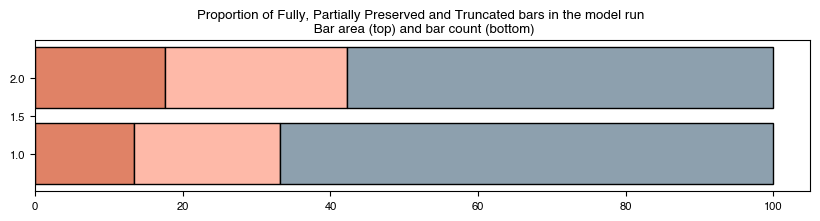

In [20]:
plt.figure(figsize = (10, 2), dpi = 100)
percfp = len(allbars[allbars['PreservChar']=='FP'])*100/len(allbars)
percpp = len(allbars[allbars['PreservChar']=='PP'])*100/len(allbars)
perctr = len(allbars[allbars['PreservChar']=='TR'])*100/len(allbars)
plt.barh(1,  percfp, color = pres_palette[0], edgecolor = 'k')
plt.barh(1,  percpp, left = percfp, color = pres_palette[1], edgecolor = 'k')
plt.barh(1,  perctr, left = percfp+percpp, color = pres_palette[2], edgecolor = 'k')


areafp = np.sum(allbars['BarArea'][allbars['PreservChar']=='FP'])*100/np.sum(allbars['BarArea'])
areapp = np.sum(allbars['BarArea'][allbars['PreservChar']=='PP'])*100/np.sum(allbars['BarArea'])
areatr = np.sum(allbars['BarArea'][allbars['PreservChar']=='TR'])*100/np.sum(allbars['BarArea'])
plt.barh(2, areafp, color = pres_palette[0], edgecolor = 'k')
plt.barh(2, areapp, left = areafp, color = pres_palette[1], edgecolor = 'k')
plt.barh(2, areatr, left = areafp+areapp, color = pres_palette[2], edgecolor = 'k')

plt.title('Proportion of Fully, Partially Preserved and Truncated bars in the model run \n Bar area (top) and bar count (bottom)')
# plt.yticks([])

plt.savefig(f'{paper_fig_path}pro-bars.png', dpi = 200, transparent = True)

In [67]:
## import widening rates
#profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh210km-profile.npy') ## channel profile for each timestep
profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2-channel-profile.npy') ## channel profile for each timestep

# profile_master[:eqt, :, :] = np.nan
profile_master = profile_master[:, :, adjustment_time:]
print(profile_master.shape)


## the first row is all nans i dont know why just leave it out everything else is fine
# 0 = ilocs, starts at 0m, every 10m
# 1 = right bank
# 2 = left bank
# 3 = rb displacement (from timestep before)
# 4 = lb displacement (from timestep before)
# 5 = rb widening rate------NAN!!!
# 6 = lb widening rate (2 hr intervals)-----NAN!!!
interval = 2
cropint = 5
tt_crop = deepcopy(profile_master[:, :, ::meanTT]) ##widening rate at median turnover timescalae (13 pyts)
widening_tt = ((tt_crop[:, 2, 1:]-tt_crop[:, 1, 1:])-(tt_crop[:, 2, :-1]-tt_crop[:, 1, :-1]))/(interval*meanTT) ##every 10 hours

pm_10 = deepcopy(profile_master[:, :, ::cropint]) ## profile data every 10 cropint timesteps (here 10 model hrs)
total_wr = ((pm_10[:, 2, 1:]-pm_10[:, 1, 1:])-(pm_10[:, 2, :-1]-pm_10[:, 1, :-1]))/(interval*cropint) ##every 10 hours

total_wr_2h = ((profile_master[:, 2, 1:]-profile_master[:, 1, 1:])-(profile_master[:, 2, :-1]-profile_master[:, 1, :-1]))/interval

(1001, 7, 317)


## Box plots by preservation

In [19]:
## for boxplots, replacing all small depth values and velocities etc with NaNs

# ['I', 'J', 'X', 'Y', 'Depth(m)', 'Elevation(m)', 'ShearStress(Nm-2)', 'ElevationChange(m)', 'FroudeNumber', 'ShieldsNumber','Velocity(ms-1) (magnitude)', 'BedloadFlux(m2s-1) (magnitude)'])
depthresh = 0.1 ## threashold depth above which we consider aerially exposed
datamaster[:, 4, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan
datamaster[:, 6, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan
datamaster[:, 6, :][datamaster[:, 6, :]>10] = np.nan
datamaster[:, 10, :][np.logical_or(datamaster[:, 4, :]<depthresh, datamaster[:, 4, :]>np.nanquantile(datamaster[:, 4, :], 0.9999))] = np.nan


In [20]:
allbars['Meanclinoaspect'] = allbars['MeanClinoWt']/allbars['MeanClinoHt']

In [61]:
bar_facies.columns

Index(['array name', 'iloc', 'PreservChar', 'no move', 'lspb', 'ripples',
       'dunes', 'dunes uspb', 'uspb', 'no move prop', 'lspb prop',
       'ripples prop', 'dunes prop', 'dunes uspb prop', 'uspb prop',
       'prop ub'],
      dtype='object')

In [35]:
allbars = allbars.drop([523])

In [36]:
allbars.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'CoherenceVal',
       'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge', 'RightEdge',
       'BarWidth', 'BarHeight', 'BarAspect', 'BarArea', 'Section Area',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx',
       'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt',
       'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt', 'ModeClinoWt',
       'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD', 'MaxClinoICD',
       'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
       'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth',
       'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear', 'ModeShear',
       'MeanShear', 'SDShear', 'MedShear', 'MinVelocity', 'MaxVelocity',
       'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
       'TRAINFLAG', 'notes', 'CVFlowDepth', 'CVVelocity', 'VarFlowDepth',
       'VarVelocity', 'Skew Abs', 'TempAgg', 

In [37]:
bar_facies['prop ub'] = bar_facies['no move prop']+bar_facies['lspb prop']
bar_facies['prop lb'] = bar_facies['dunes uspb prop']+bar_facies['uspb prop']+bar_facies['ripples prop']+bar_facies['dunes prop']

# Final plots for manuscript

### Boxplots

In [23]:
### Varaibles to plot

geometric_vars = ['BarArea', 'BarWidth', 'BarHeight']#
# facies = ['prop ub', 'prop lb']
scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxClino/MedFD', 'PkgHeight/MedFD']
time = ['MeanAge', 'ElapsedTime', 'GrowthR8']
# diagnostics = ['MaxClino/MaxFD', 'MaxCMaxPkgHt', 'UBar', 'GrowthR8']
# agg_flags = ['PkgHeight/MedFD', 'PkgHeight/MeanFD', 'PkgHeight/MaxFD', 'MeanAge']

# time = ['StartTime', 'ElapsedTime', 'NumTurnovers', 'MeanAge']
# scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxCMaxPkgHt', 'GrowthR8']

### Boxplot properties
flierprops = dict(marker='o', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
boxprops = dict(edgecolor = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = 0.35
linewidth = 1.5

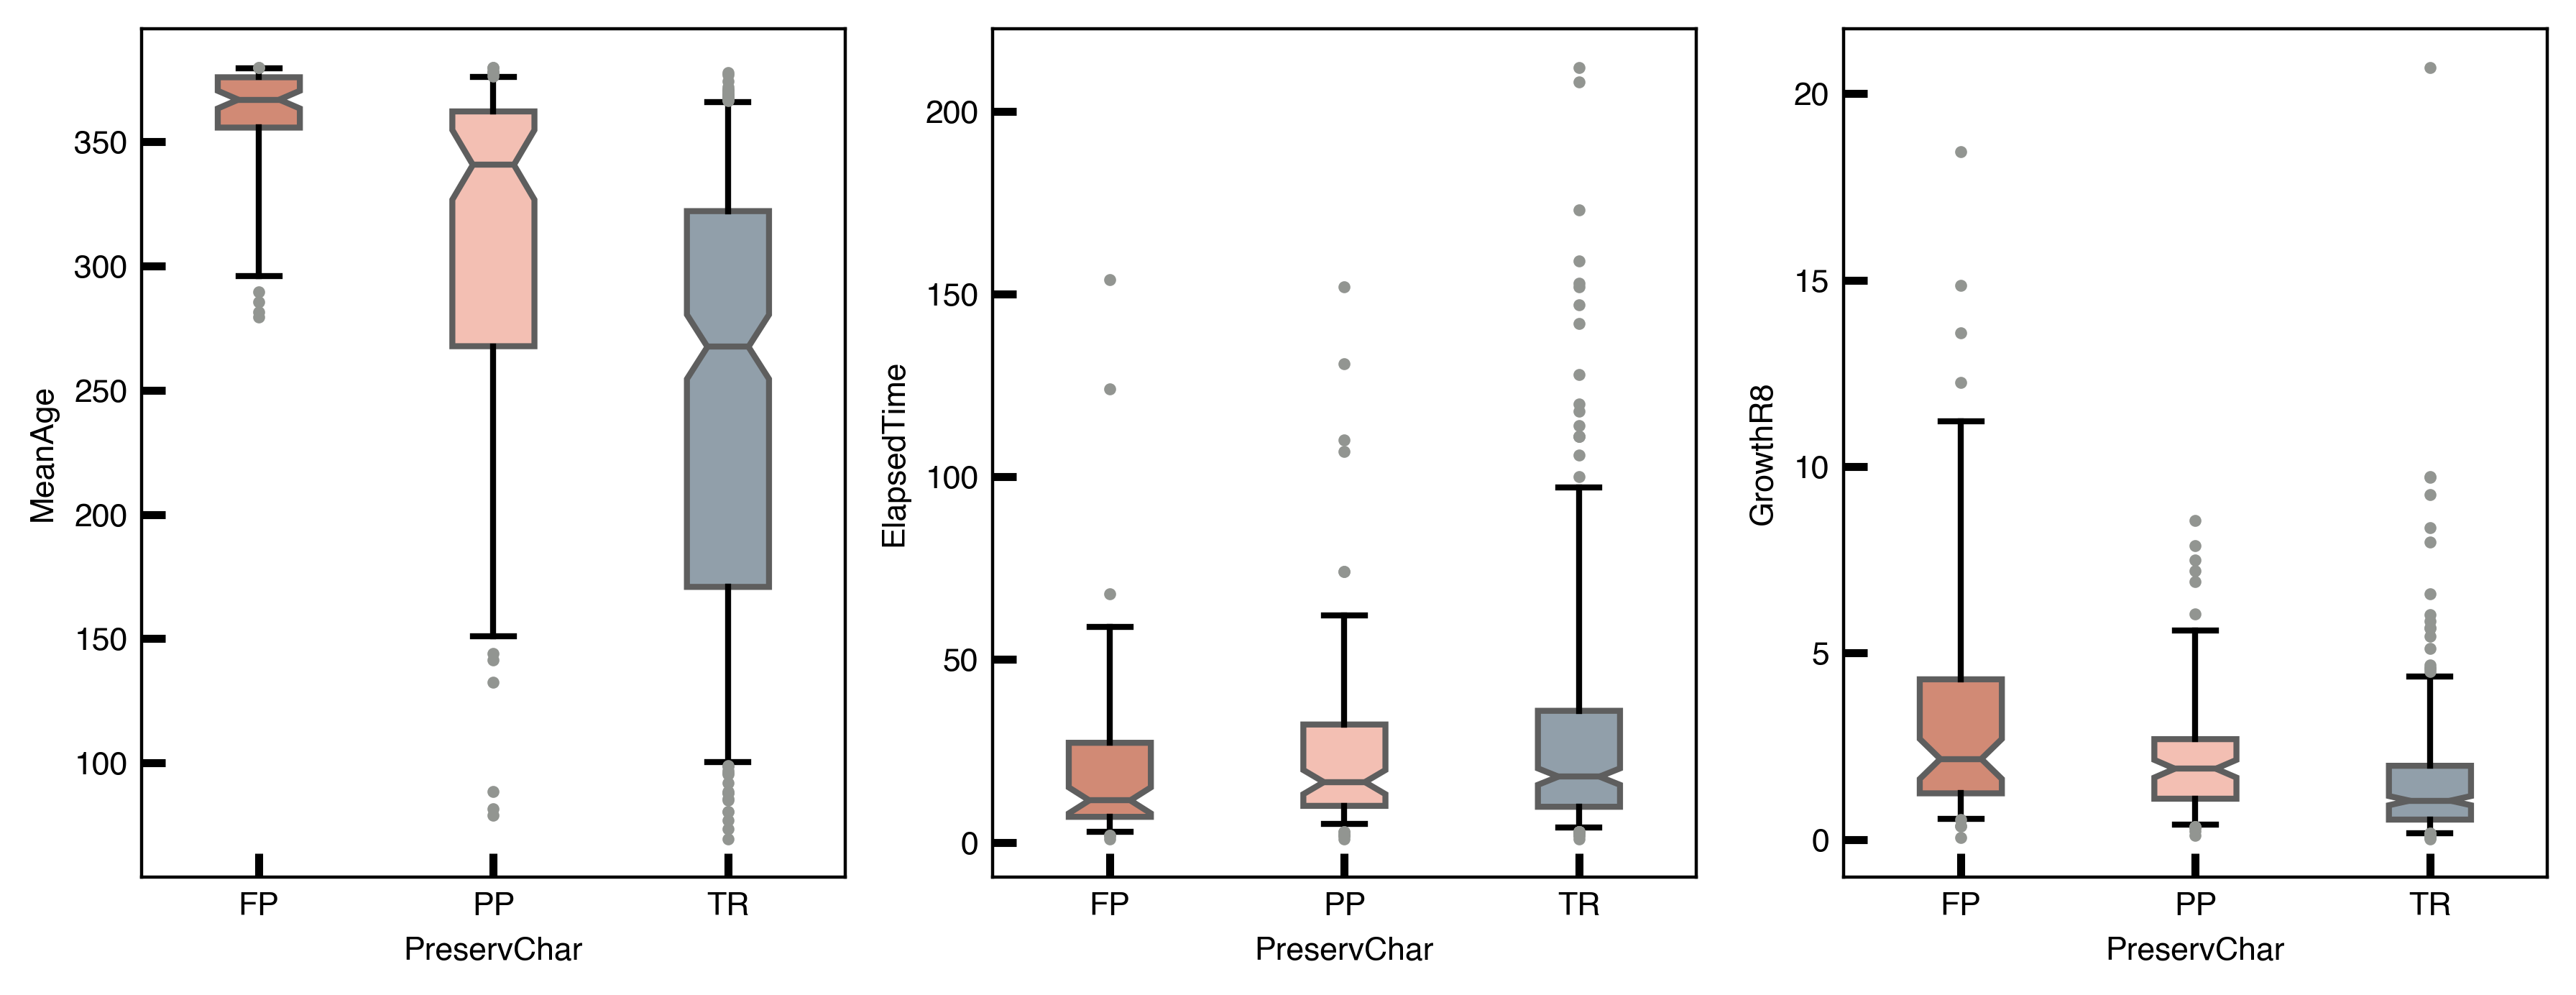

In [137]:
## PANEL 1———————time—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax.tick_params(direction='in', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/3-3_panel3-time.png', dpi = 300)

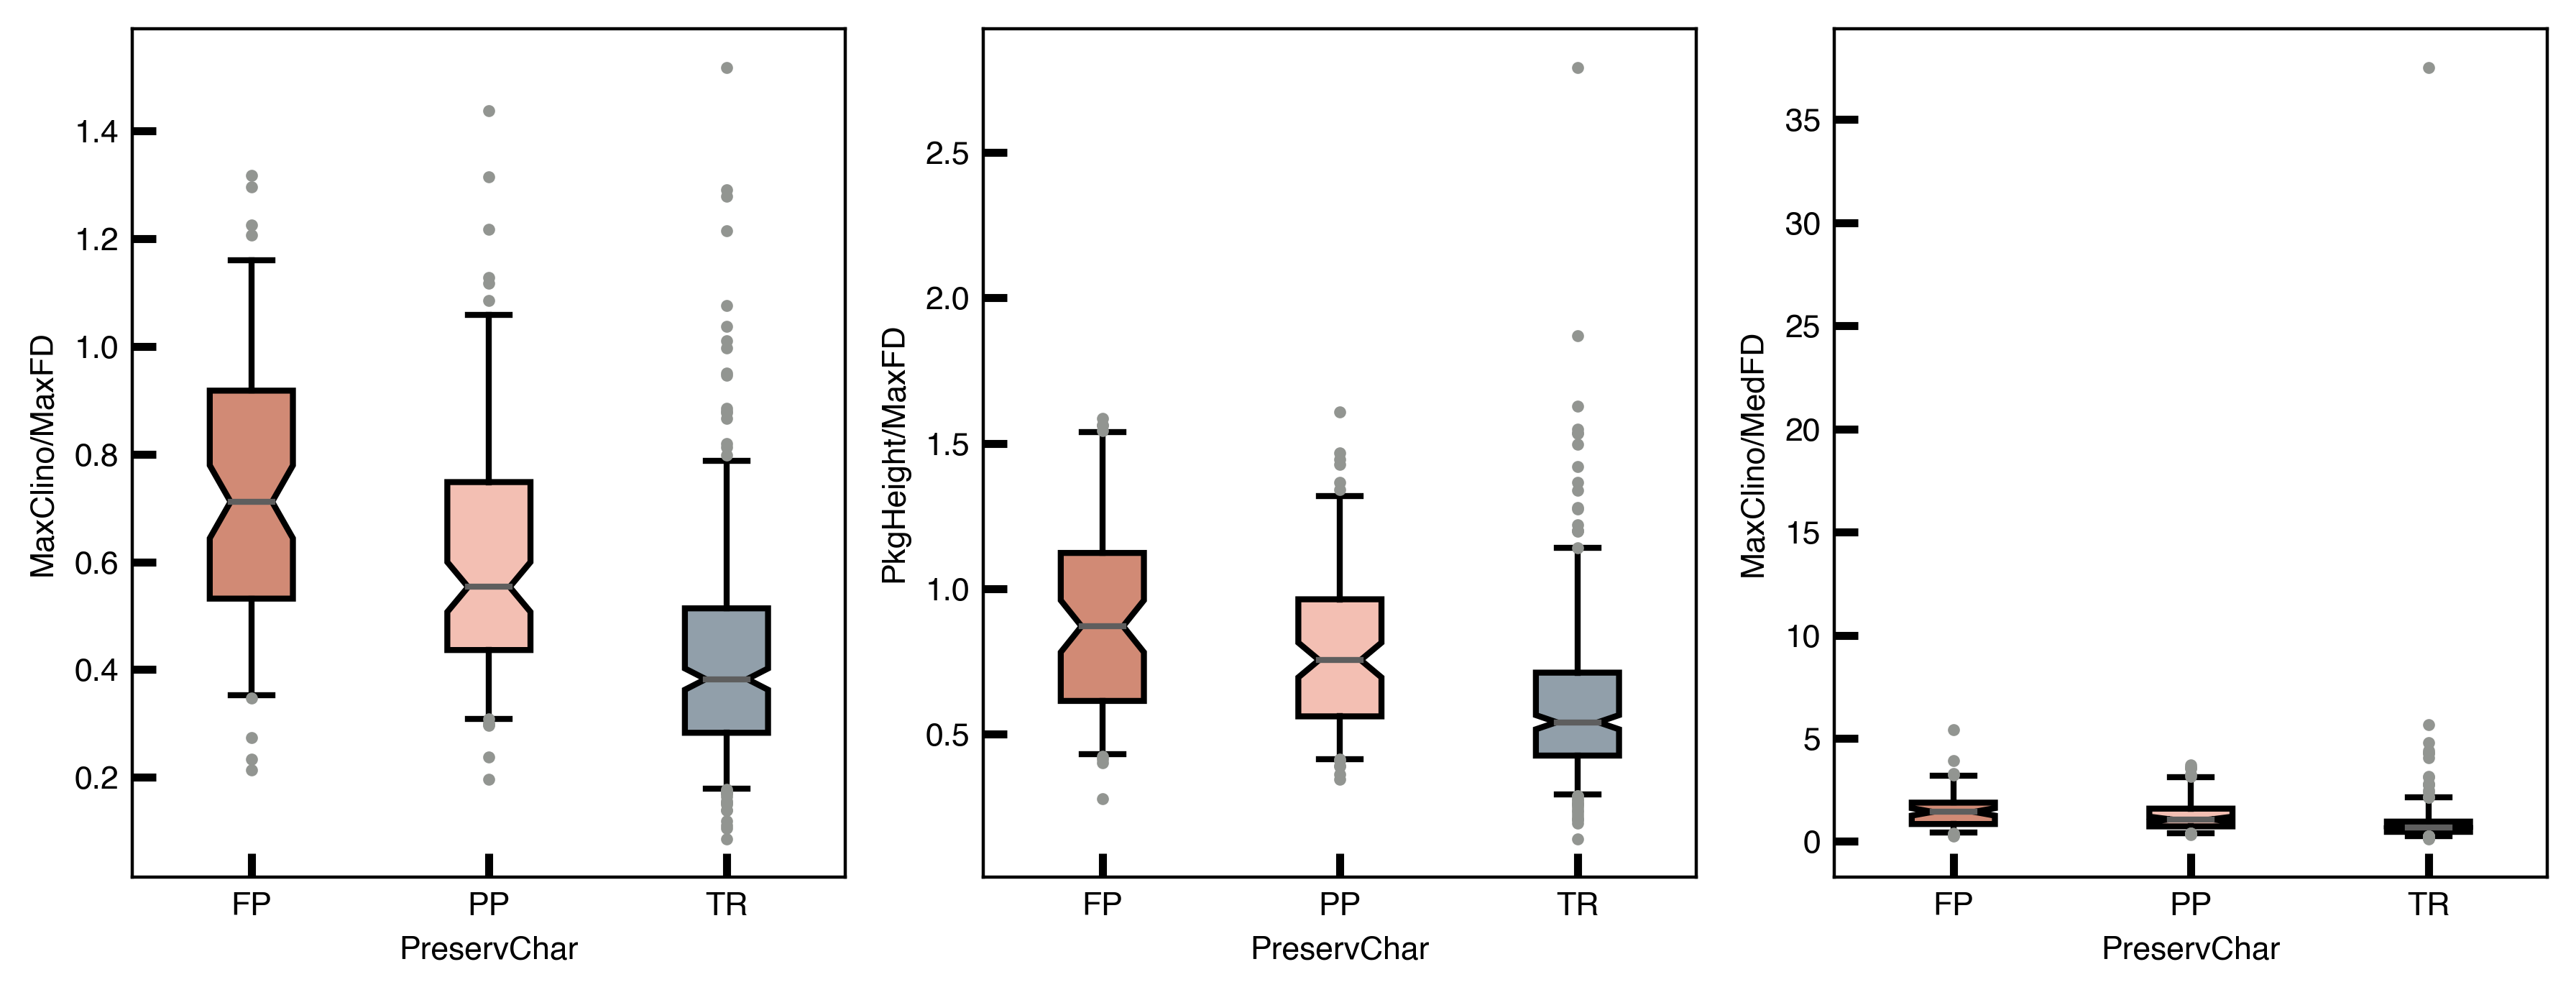

In [24]:
## PANEL 1———————scalers—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax.tick_params(direction='in', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/3-3_panel3-time.png', dpi = 300)

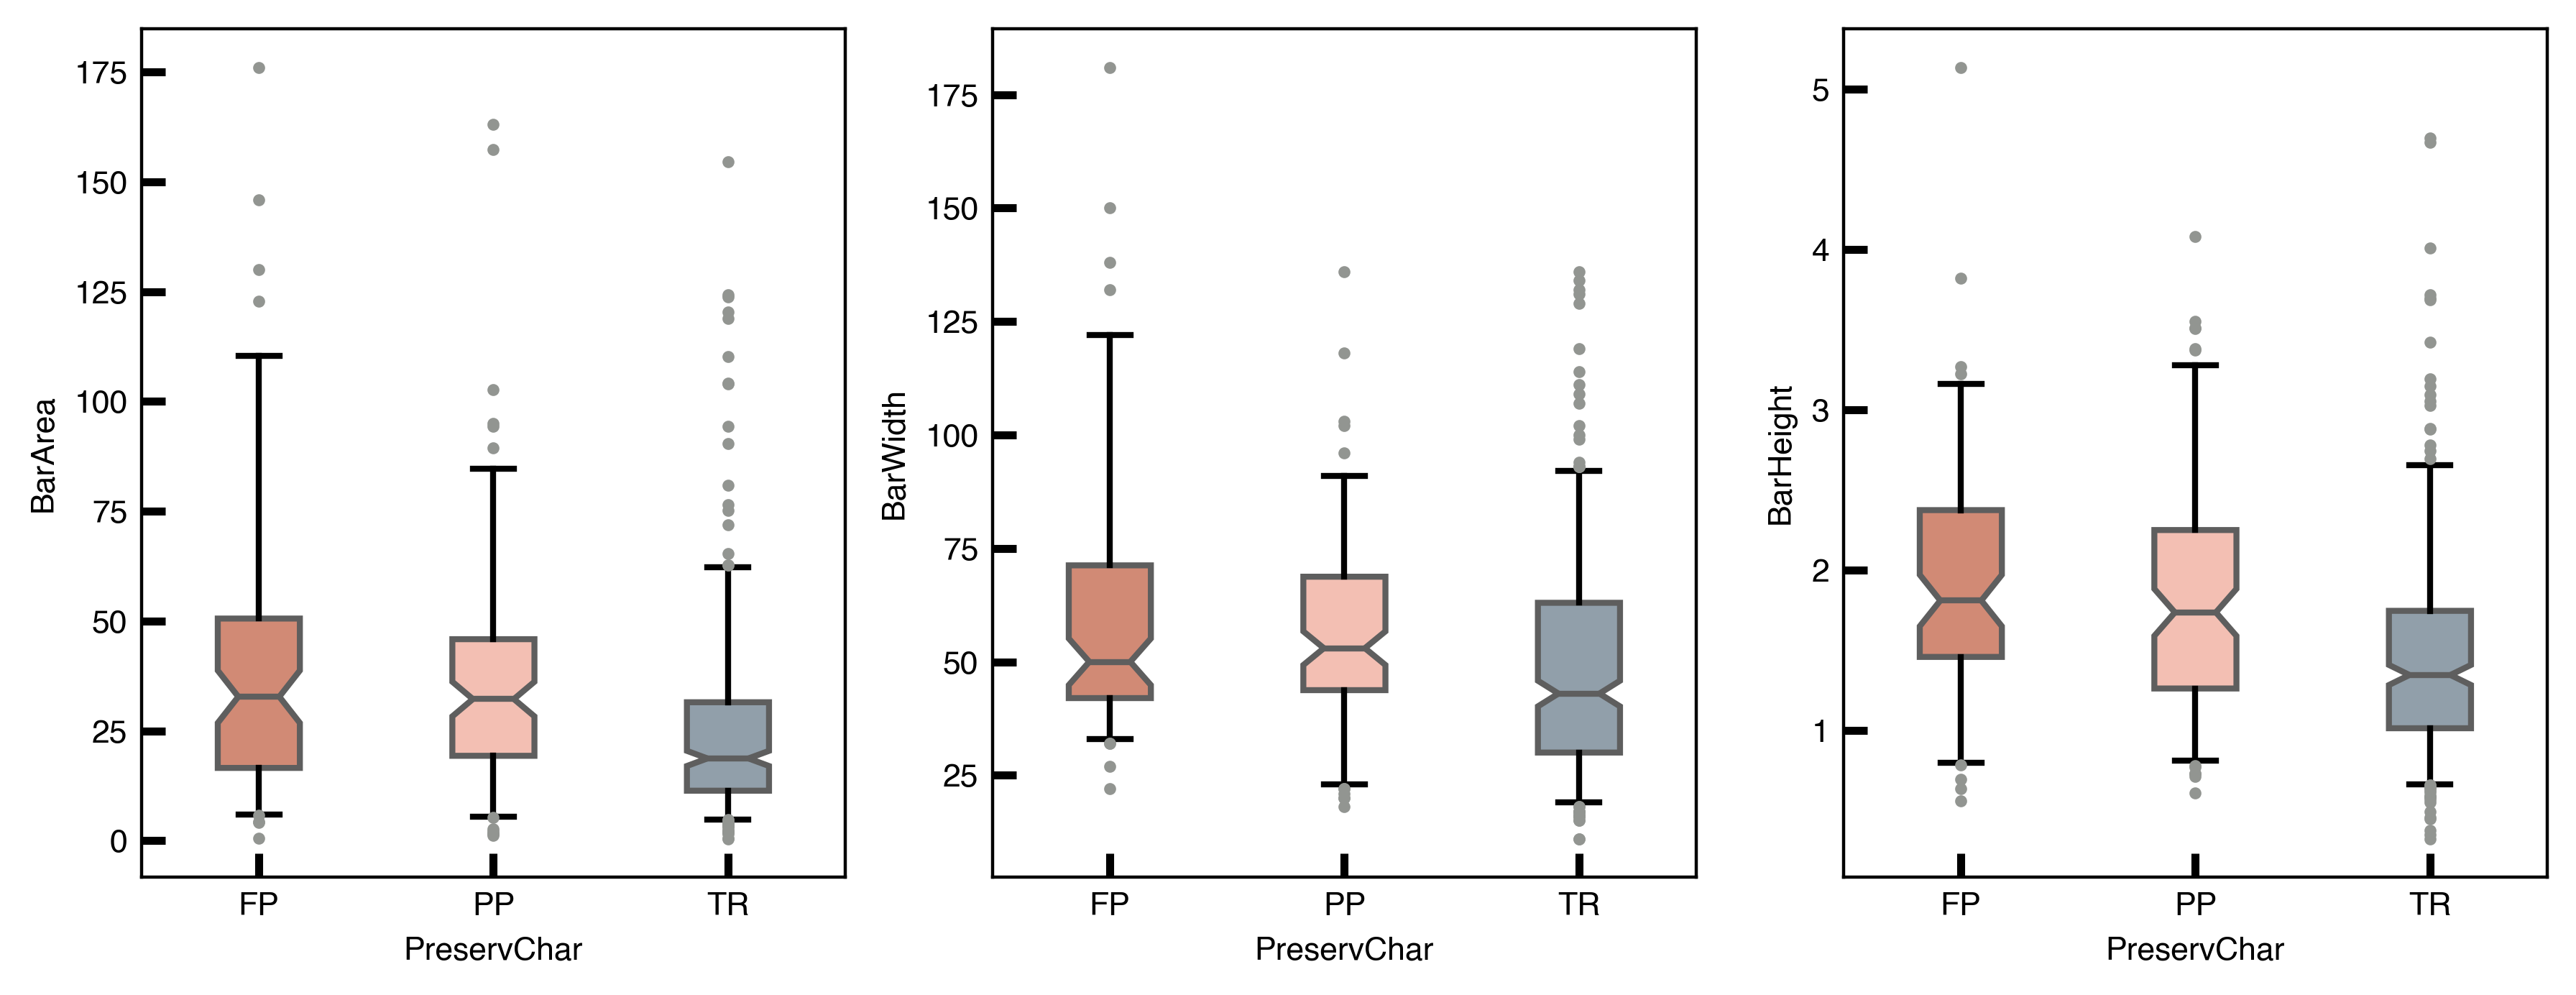

In [138]:
## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (len(geometric_vars)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
    
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/3-3_panel1-geometry.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)

In [81]:
abcrop = allbars[allbars['StartTime']>eqt]

Text(0, 0.5, 'Age')

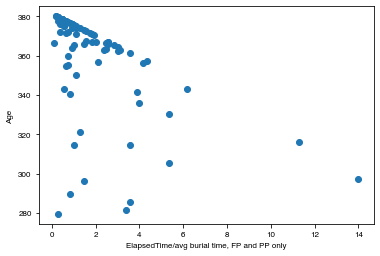

In [151]:
abcroppres = abcrop[np.logical_or(abcrop['PreservChar']=='FP', abcrop['PreservChar']=='FP')]
plt.scatter(abcroppres['ElapsedTime']/11, abcroppres['MeanAge'])
plt.xlabel('ElapsedTime/avg burial time, FP and PP only')
plt.ylabel('Age')

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

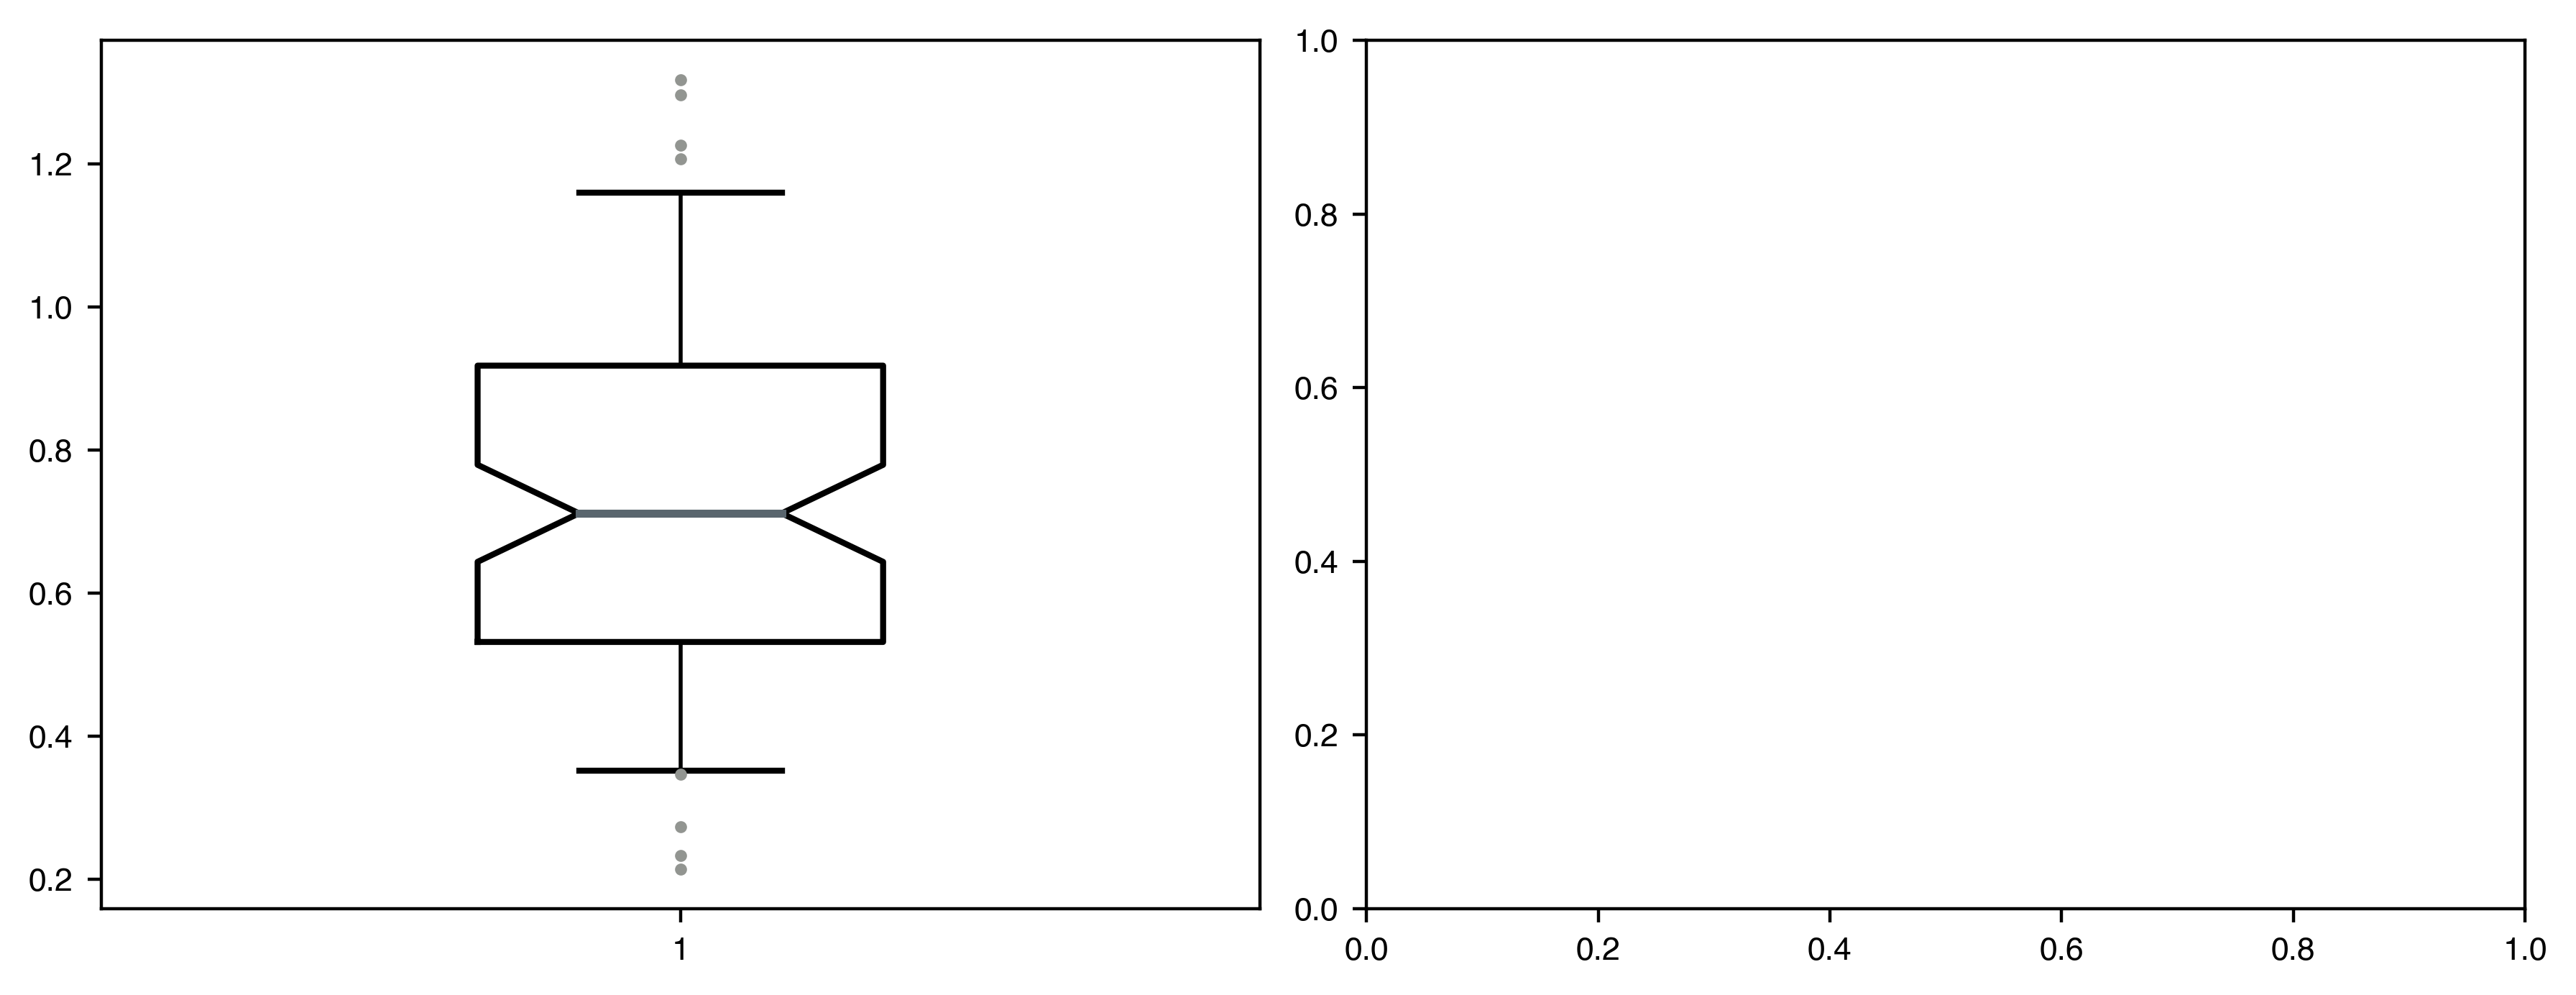

In [142]:
boxprops = {'linewidth': 1.5}#, 'notch_color': 'grey'}
medianprops = {'color': 'xkcd:slate grey', 'linewidth':2}

# ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
#               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops =

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, 2, figsize = (9, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxClino/MedFD', 'PkgHeight/MedFD']
# for idx, pres in enumerate(['FP', 'PP', 'TR']):
ab = ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].set_ylabel('Local flow depth proportion')



ax[1].set_ylabel('Local flow depth proportion')
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
    
#  y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# # for idx, pres in enumerate(['FP', 'PP', 'TR']):
#     ax[0].boxplot(allbars[scalers[1]][allbars['PreservChar']==pres], positions = idx)


# ax[0].boxplot()
# sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[0], palette = pres_palette, ax = ax[0], linewidth = linewidth, width = boxwidth, notch = False, 
#            boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[1], palette = pres_palette, ax = ax[0], linewidth = linewidth, width = boxwidth, notch = False, 
           # boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/6-2_panel4-scaling.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/maxvmed-scaling.png', dpi = 300, transparent = True)


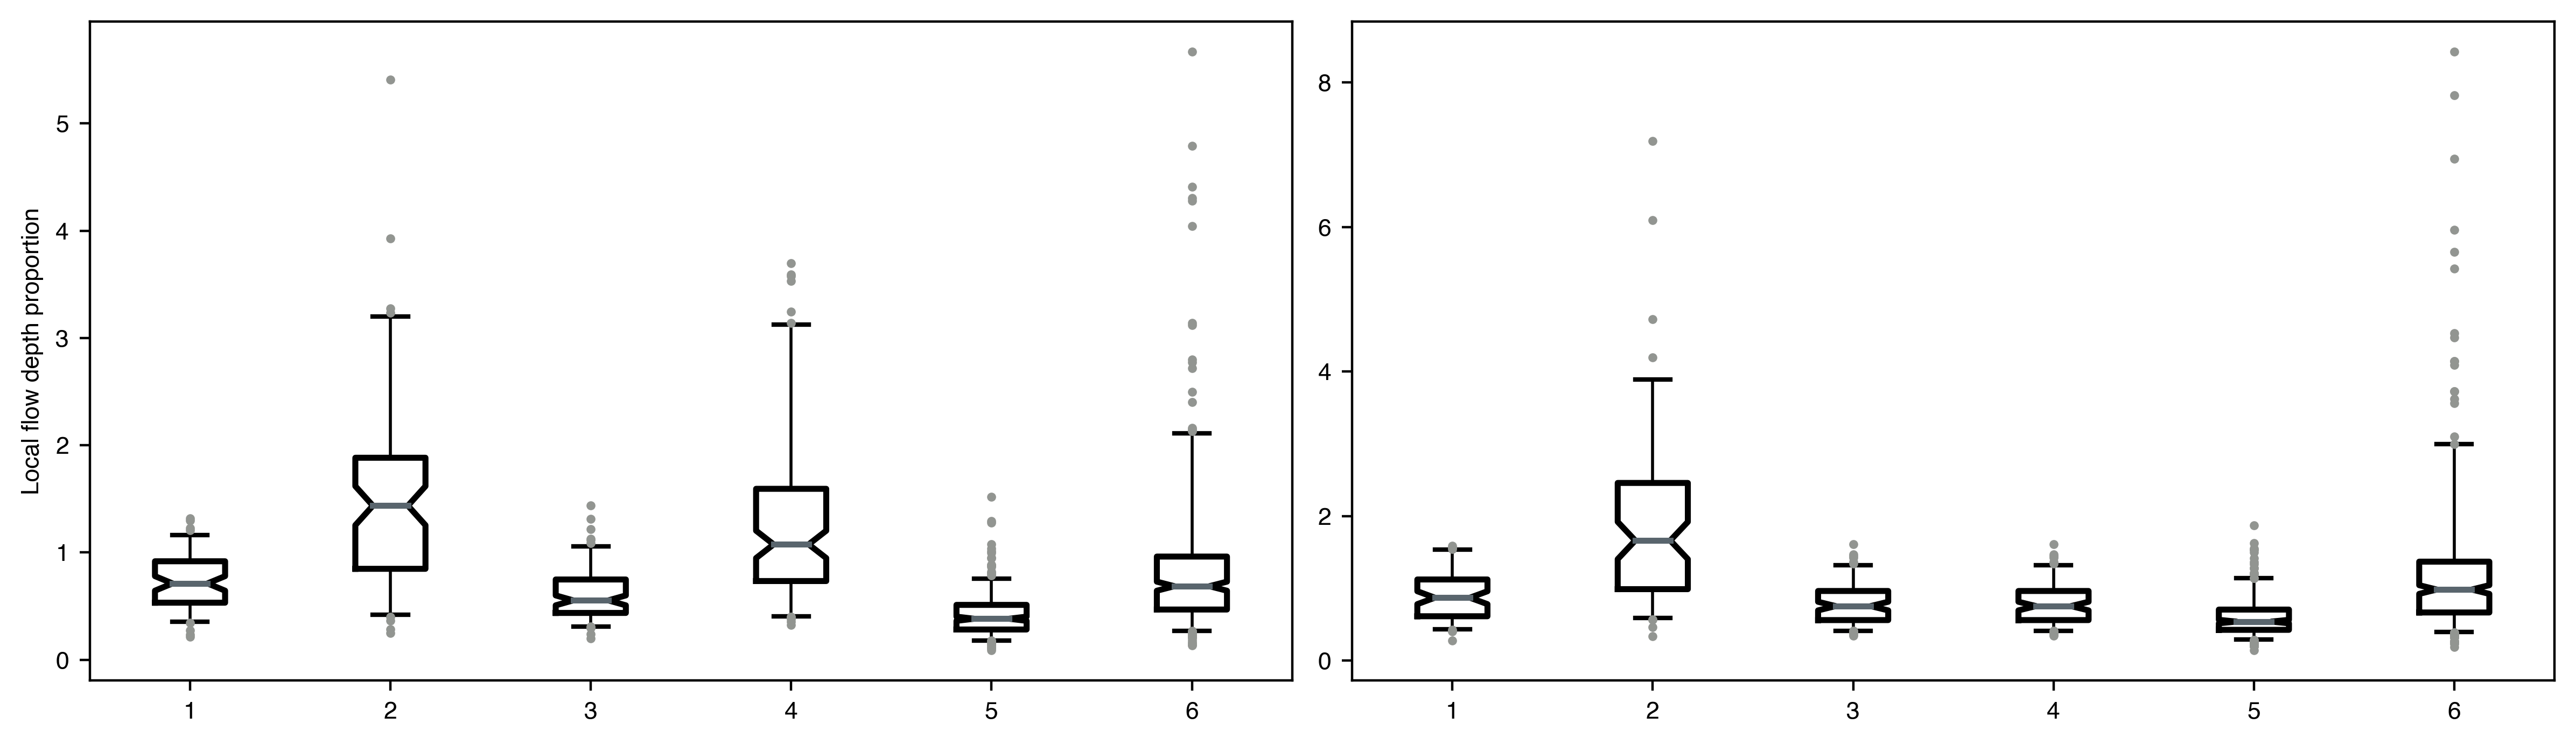

In [111]:
boxprops = {'linewidth': 2}#, 'notch_color': 'grey'}
medianprops = {'color': 'xkcd:slate grey', 'linewidth':2}

# ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
#               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops =

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, 2, figsize = (len(scalers)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()

# scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxClino/MedFD', 'PkgHeight/MedFD']
# for idx, pres in enumerate(['FP', 'PP', 'TR']):
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[0].set_ylabel('Local flow depth proportion')

ax[1].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
    
#  y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# # for idx, pres in enumerate(['FP', 'PP', 'TR']):
#     ax[0].boxplot(allbars[scalers[1]][allbars['PreservChar']==pres], positions = idx)


# ax[0].boxplot()
# sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[0], palette = pres_palette, ax = ax[0], linewidth = linewidth, width = boxwidth, notch = False, 
#            boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[1], palette = pres_palette, ax = ax[0], linewidth = linewidth, width = boxwidth, notch = False, 
           # boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/clinovpkg-scaling.png', dpi = 300, transparent = True)


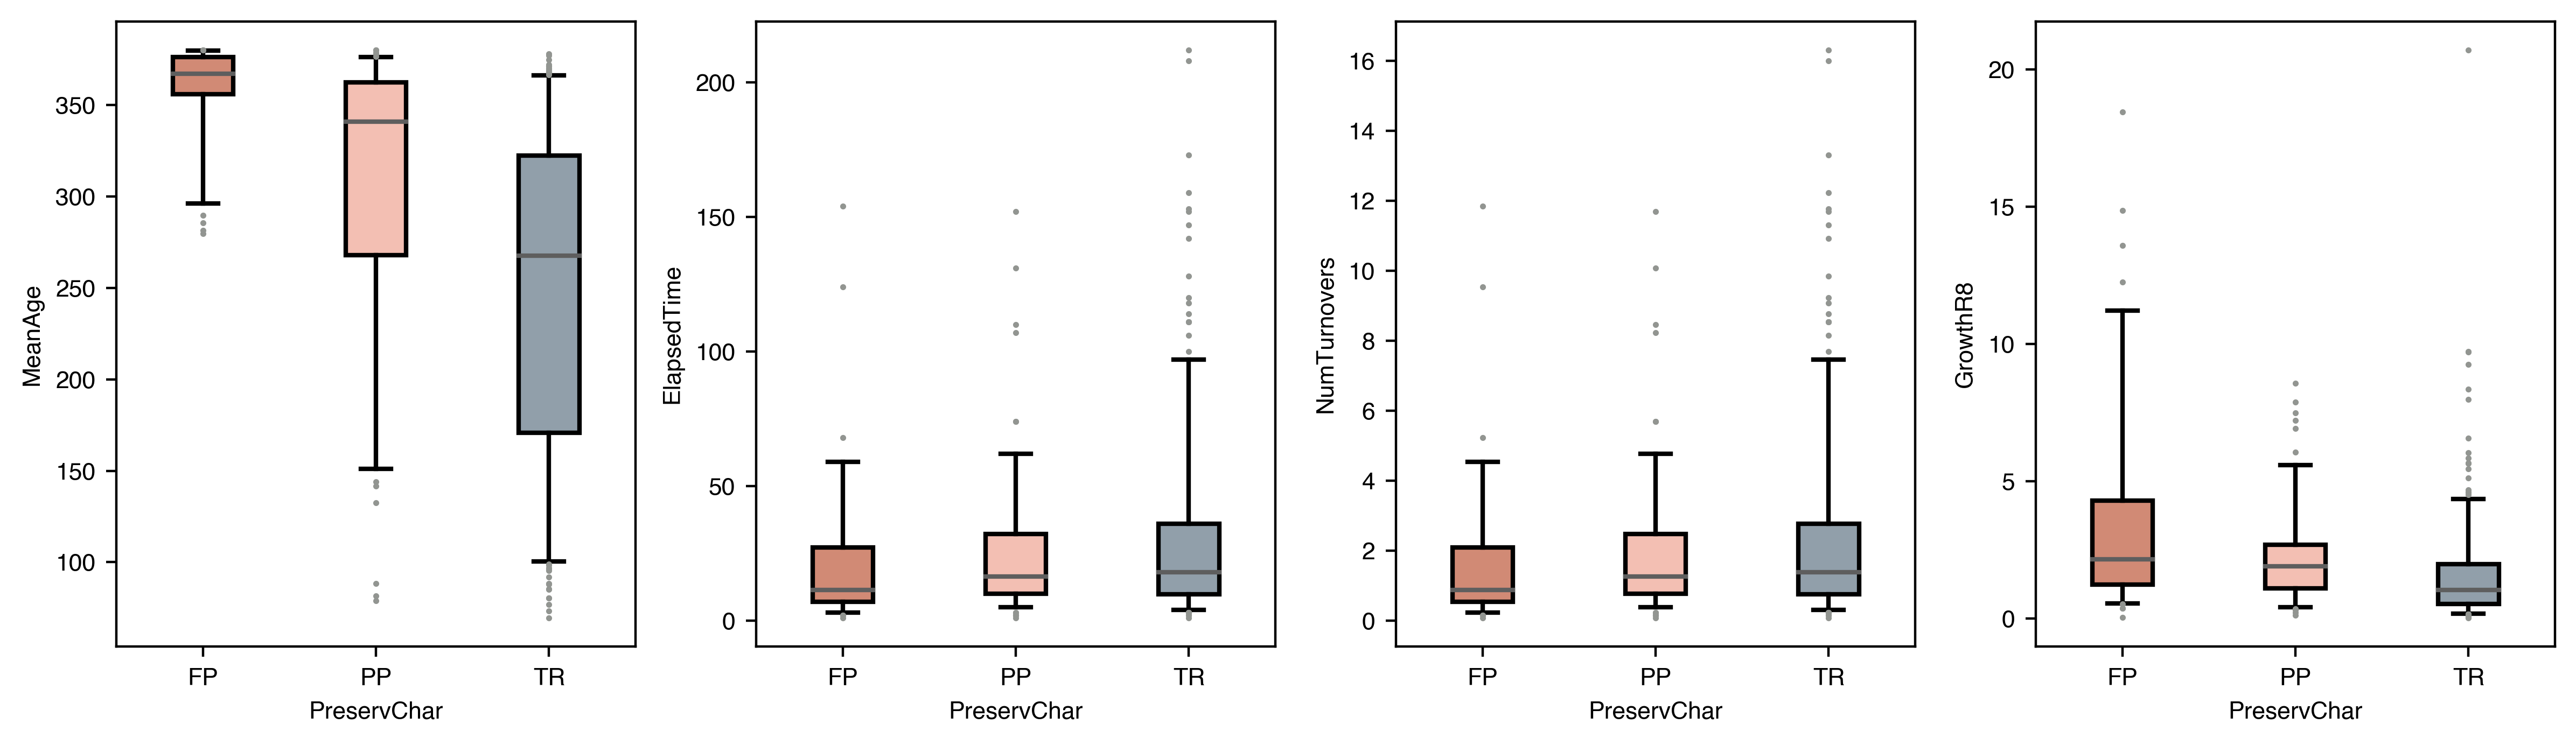

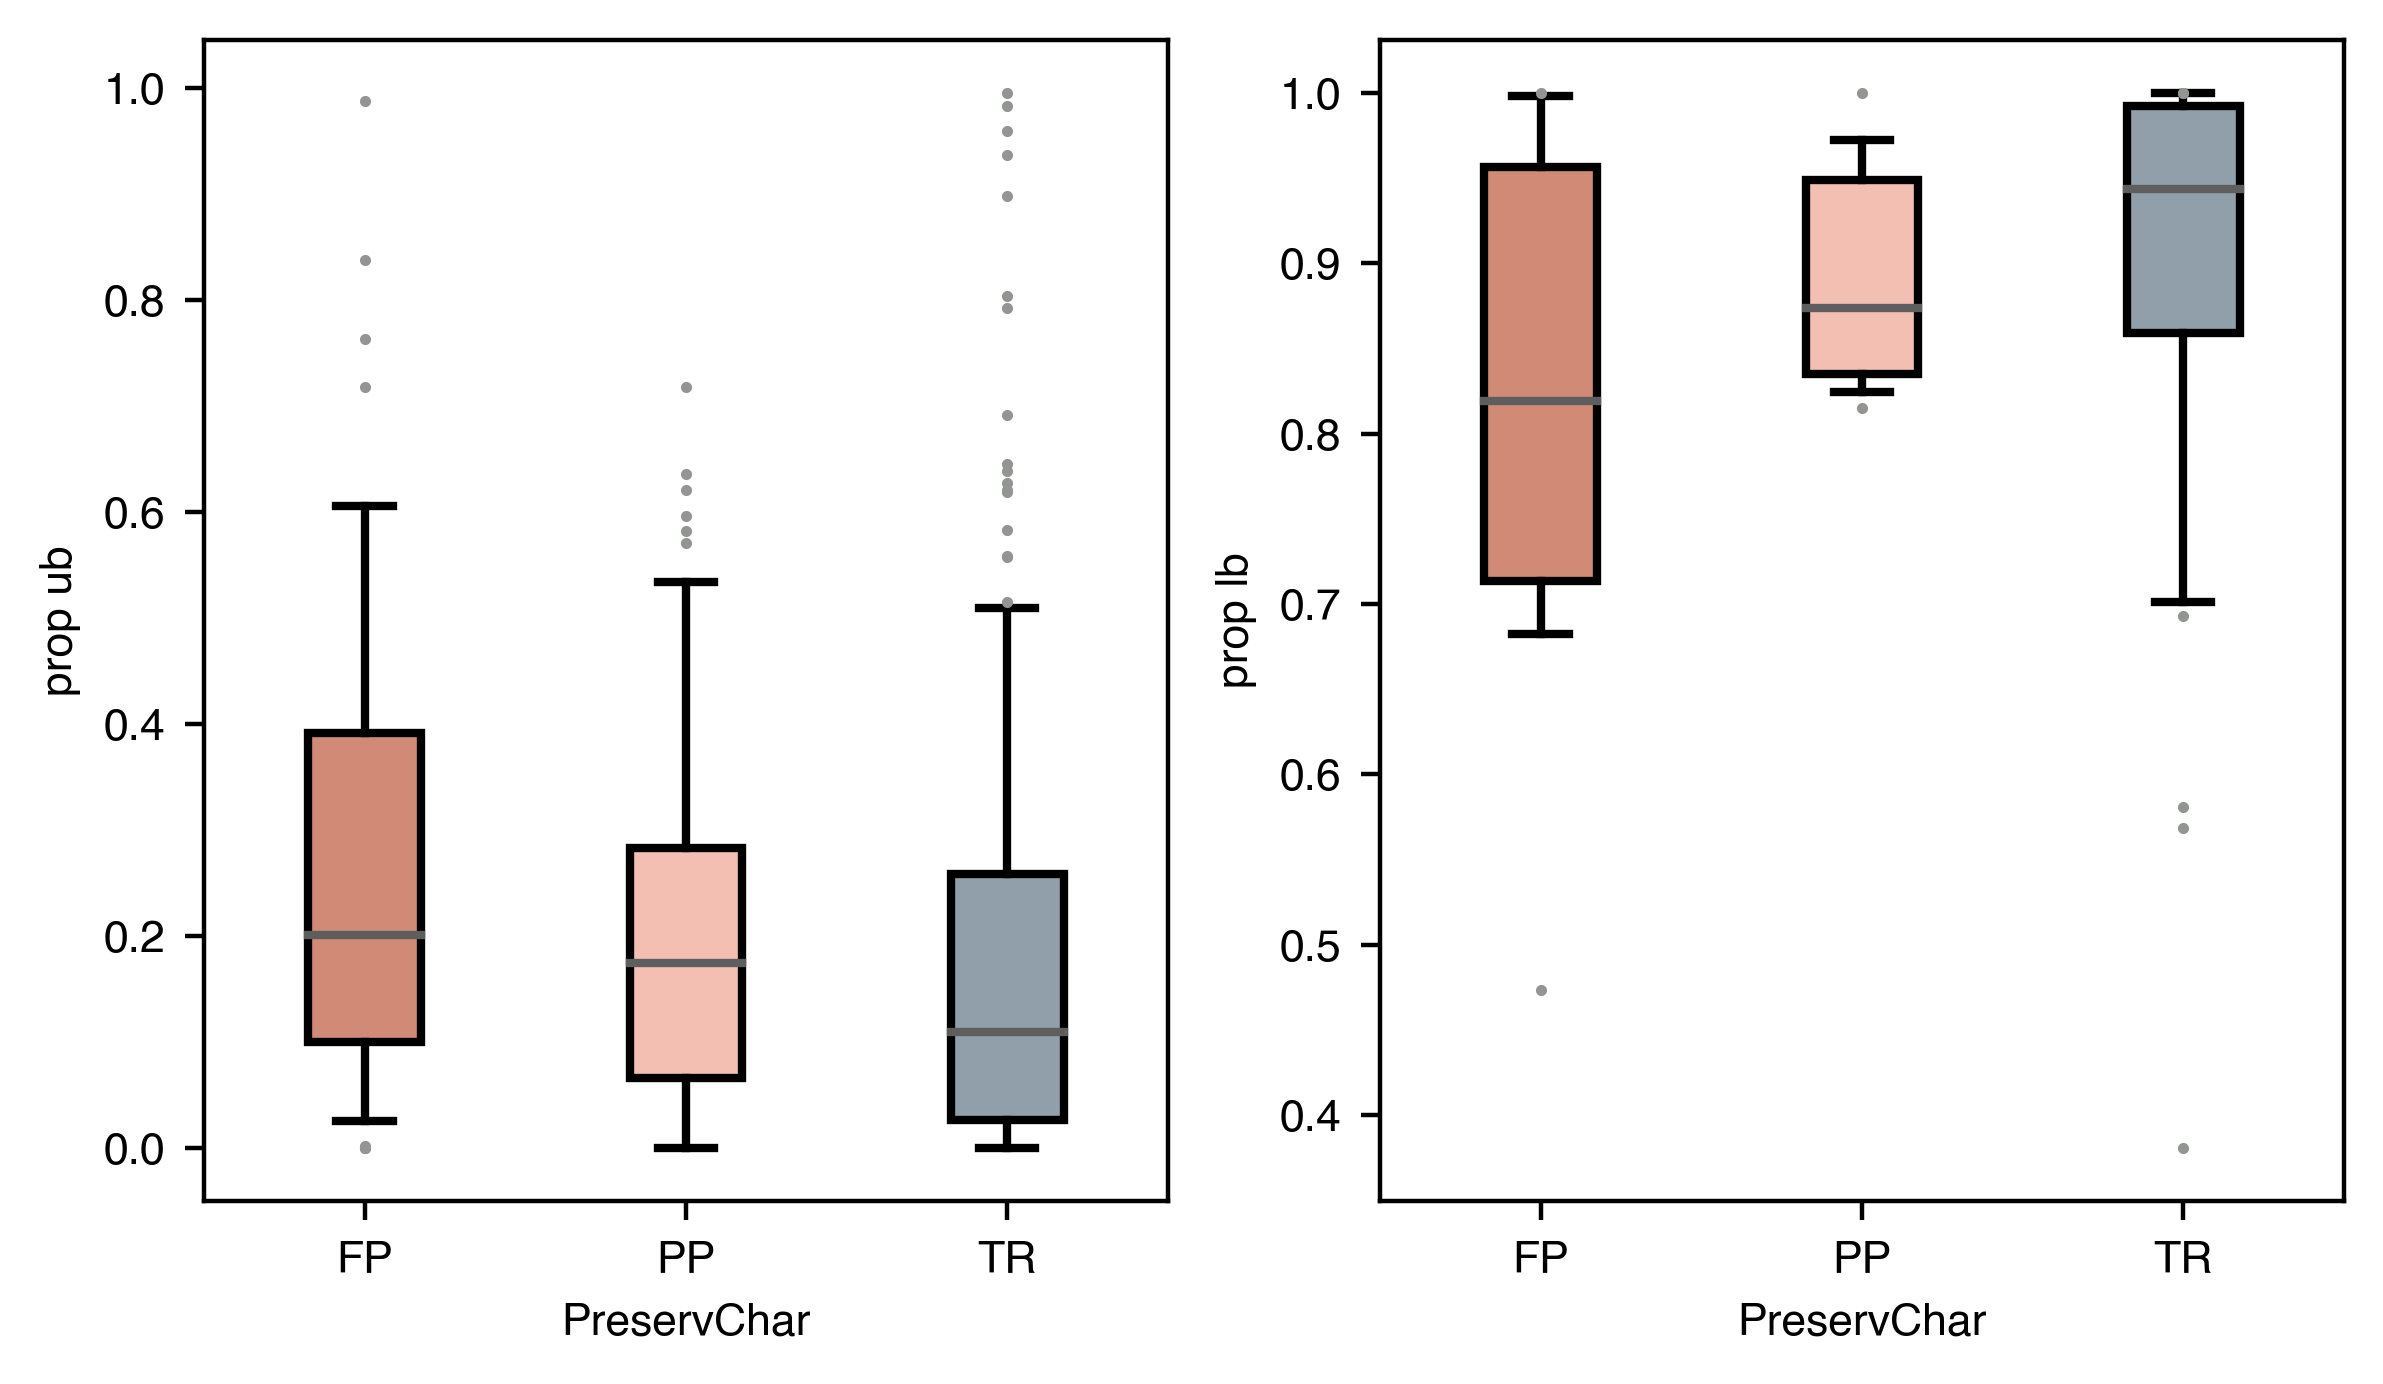

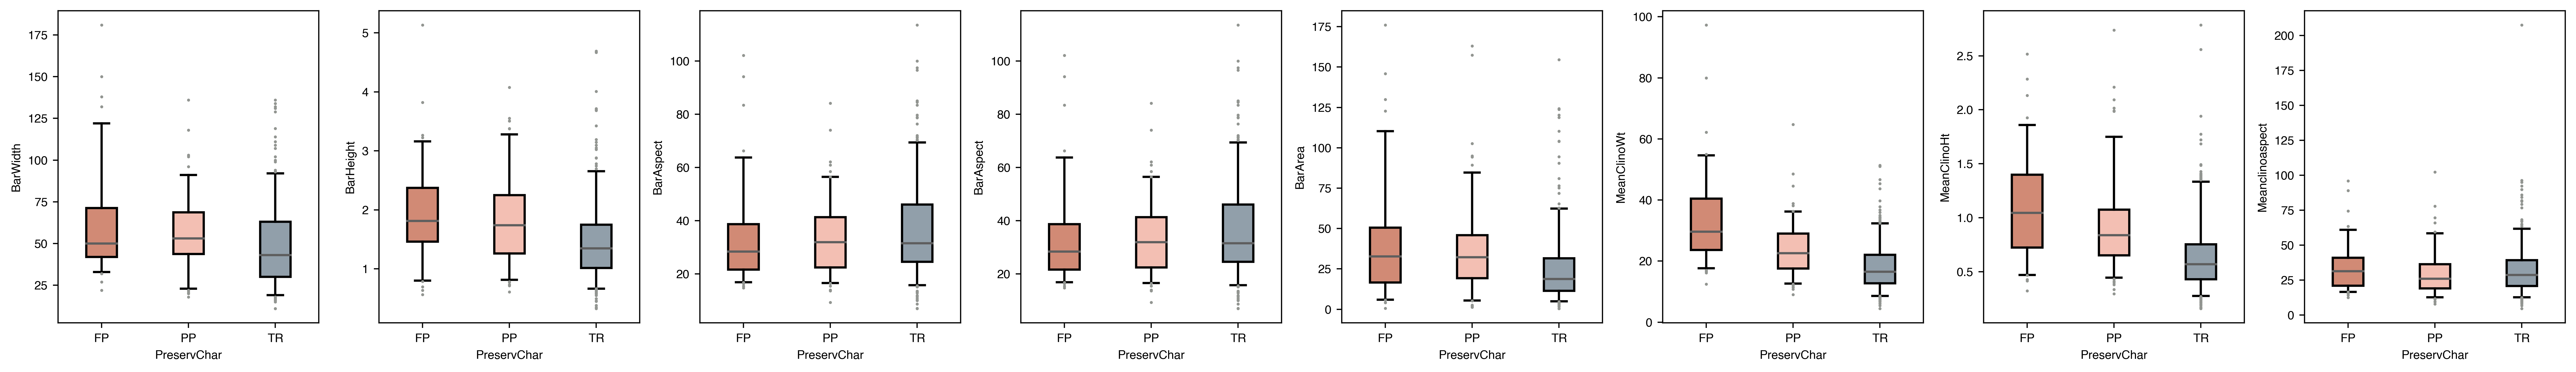

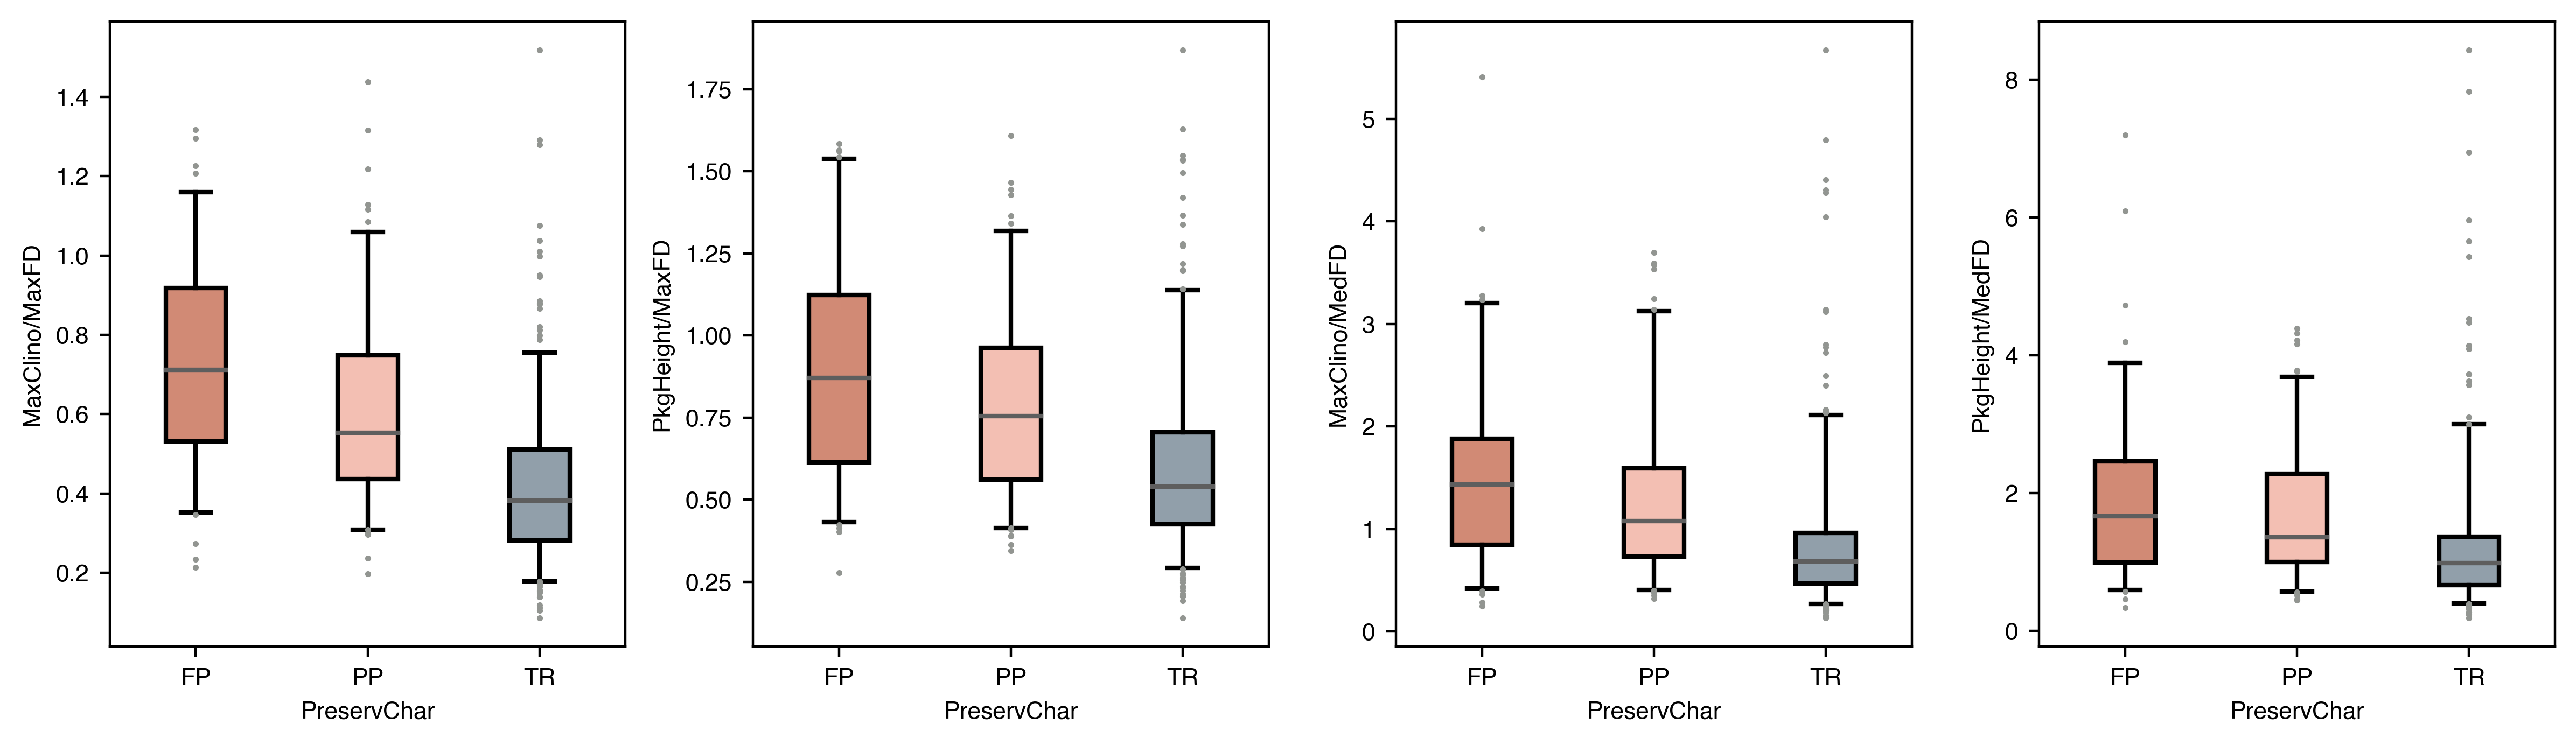

In [38]:
## New boxplots from Liz for writing results
## no, I do not have clino area, or individual distriutions for clino geometry, I didnt pull it and it's not easy to get






# ## PANEL 2—————facies———————————————————————————————————————————————————————————————————————————————————————————
# fig, ax = plt.subplots(1, len(facies), figsize = (len(facies)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# # ax = ax.ravel()

# for i, a in enumerate(ax):
#     sns.boxplot(data = bar_facies, x = 'PreservChar', y = facies[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
#                boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
# # plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel2.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/panel2-facies.png', dpi = 300)


# ## PANEL 4————————————————————————————————————————————————————————————————————————————————————————————————

for i, a in enumerate(ax):
    sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, 
               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# ## PANEL 5————————————————————————————————————————————————————————————————————————————————————————————————

# fig, ax = plt.subplots(1, len(agg_flags), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = agg_flags[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# # ax[3].set_ylim(0, 15)
# # plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel4.png', dpi = 400)



In [ ]:
## New boxplots from Liz for writing results--also making violinplots

flierprops = dict(marker='.', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
boxprops = dict(edgecolor = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = 0.35
linewidth = 1.5

## PANEL 1———————time—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], 
                   bw = .5, scale = 'width', inner = 'box', cut = 0,
                   palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    # box = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
    #            boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    # box.set_zorder(20)

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/vpanel3-time.png', dpi = 300)

## PANEL 2—————facies———————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(facies), figsize = (len(facies)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()

for i, a in enumerate(ax):
    sns.violinplot(data = bar_facies, x = 'PreservChar', y = facies[i], 
                bw = .5, scale = 'width', inner = 'box', cut = 0,
                   palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel2.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/vpanel2-facies.png', dpi = 300)

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (len(geometric_vars)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], 
                bw = .5, scale = 'width', inner = 'box', cut = 0,
                   palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/vpanel1-geometry.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# ## PANEL 4————————————————————————————————————————————————————————————————————————————————————————————————

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(scalers), figsize = (len(scalers)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.violinplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], 
                bw = .5, scale = 'width', inner = 'box', cut = 0,
                   palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/vpanel4-scaling.png', dpi = 300)

# ## PANEL 5————————————————————————————————————————————————————————————————————————————————————————————————

# fig, ax = plt.subplots(1, len(agg_flags), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = agg_flags[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# # ax[3].set_ylim(0, 15)
# # plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel4.png', dpi = 400)



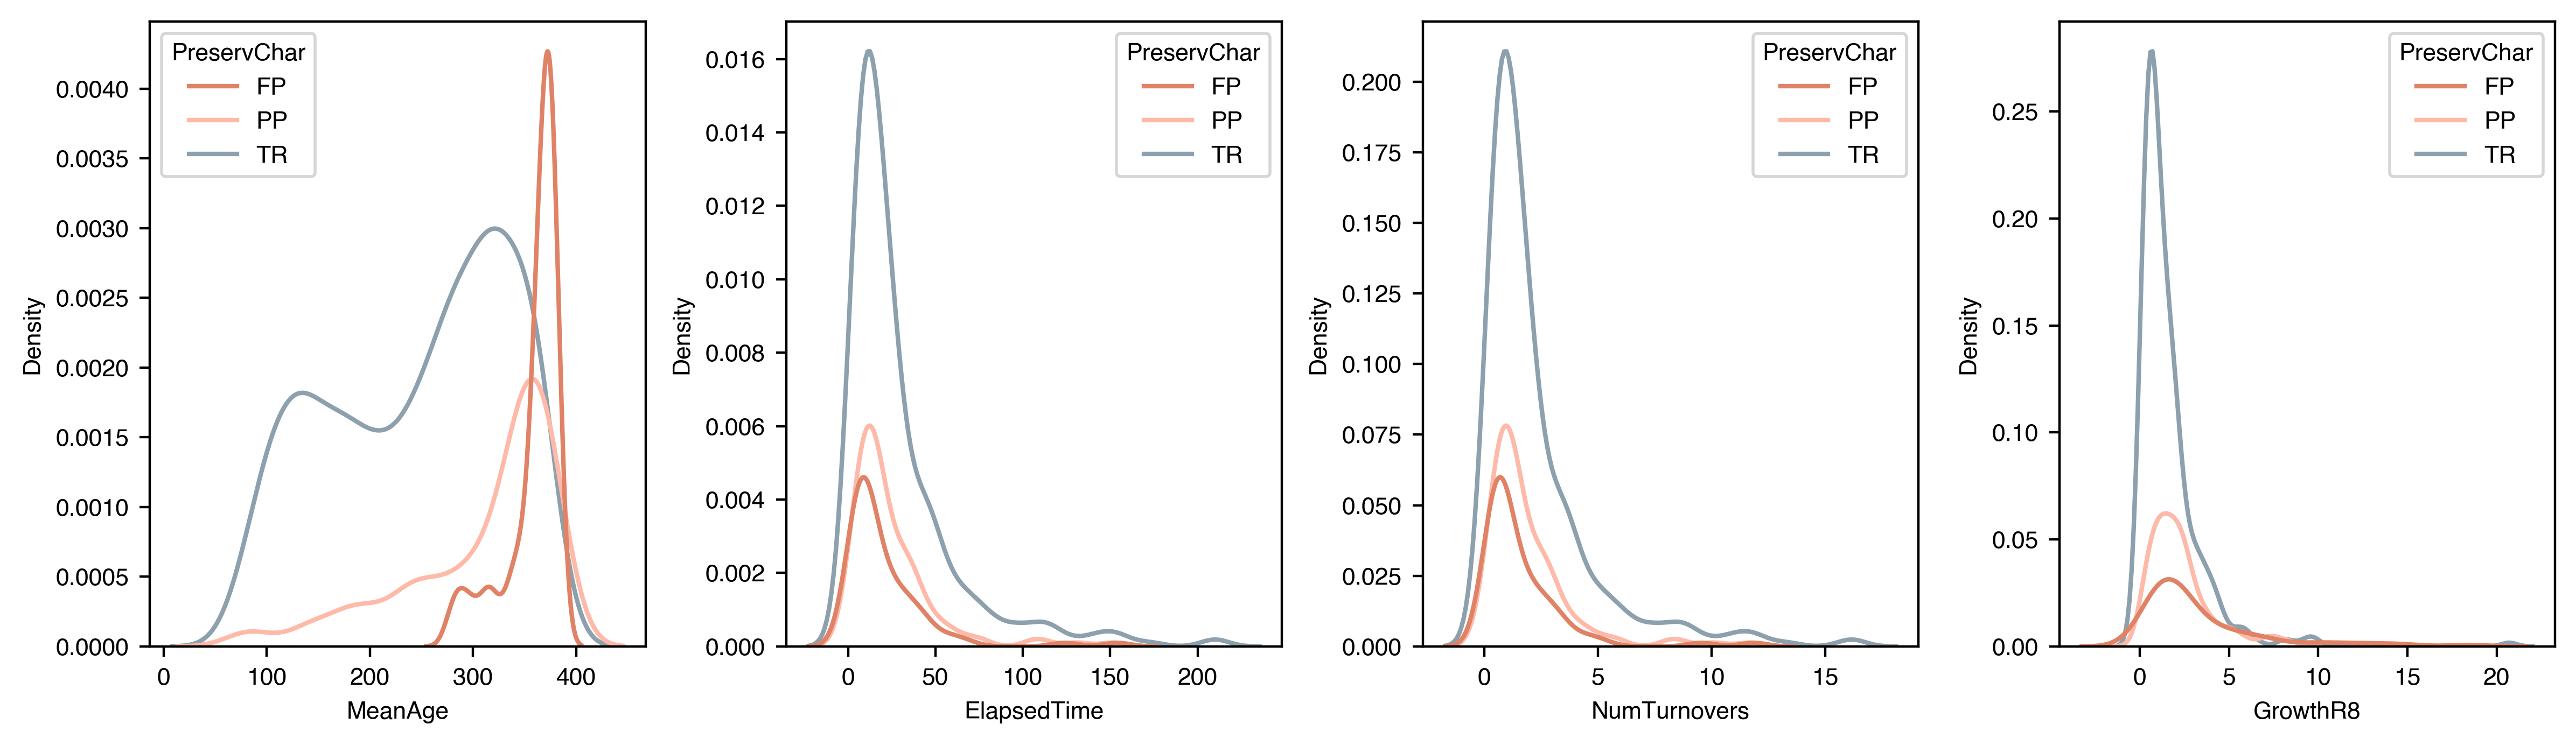

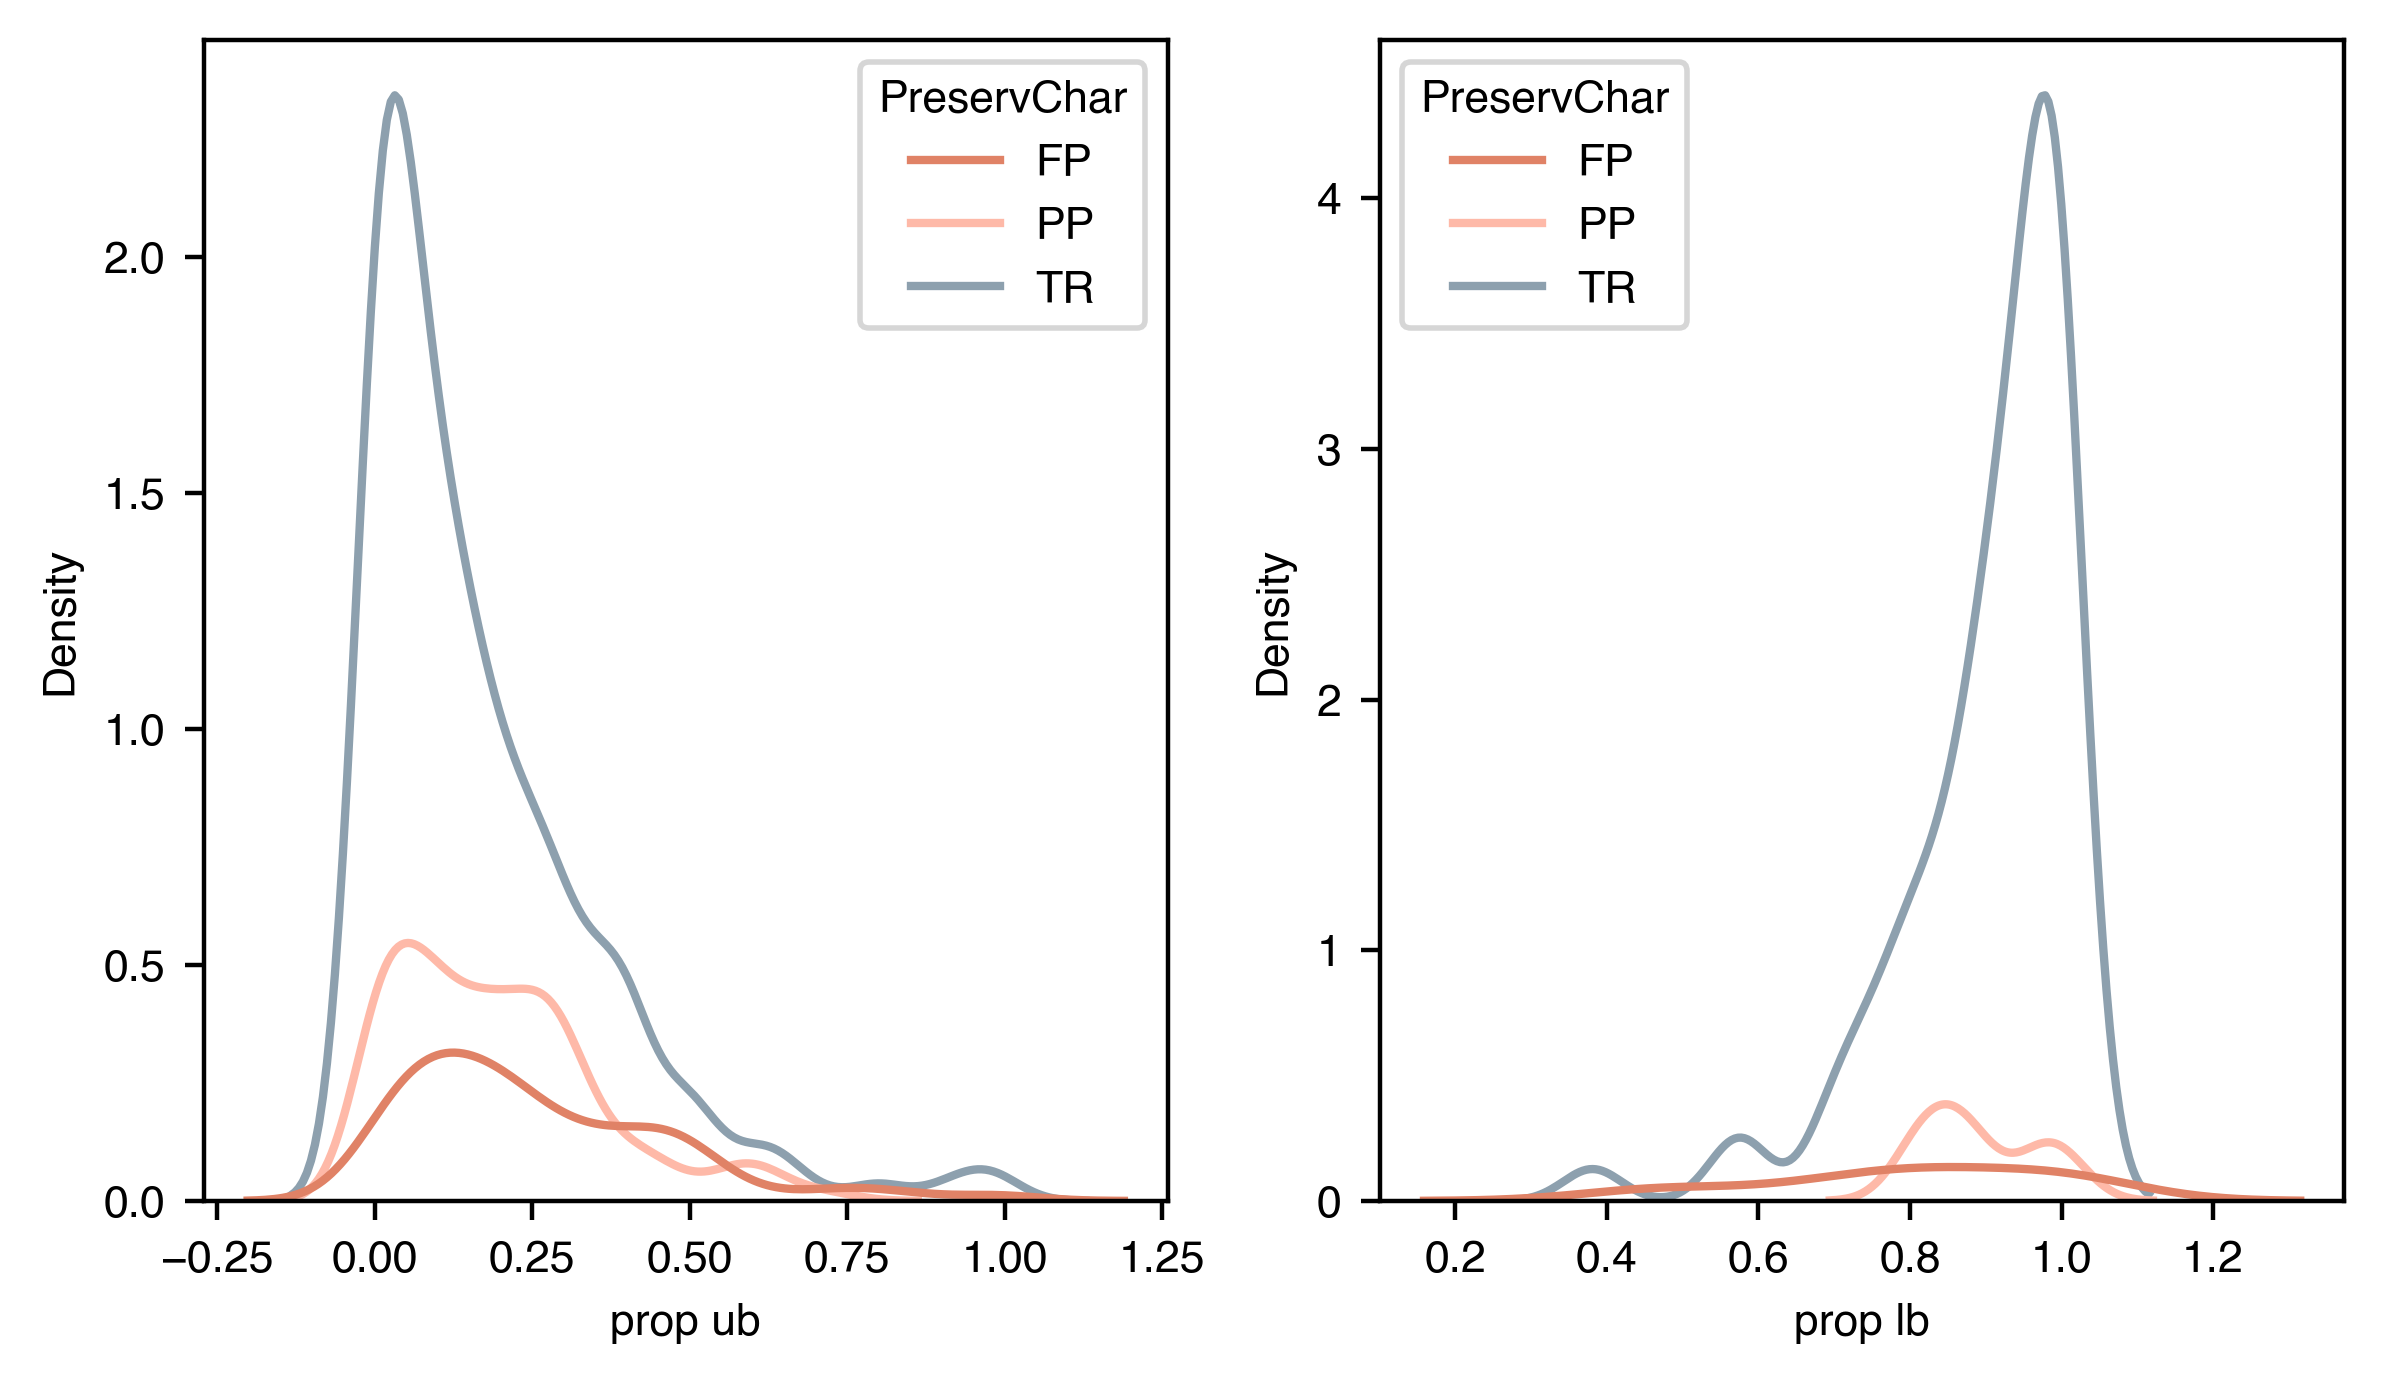

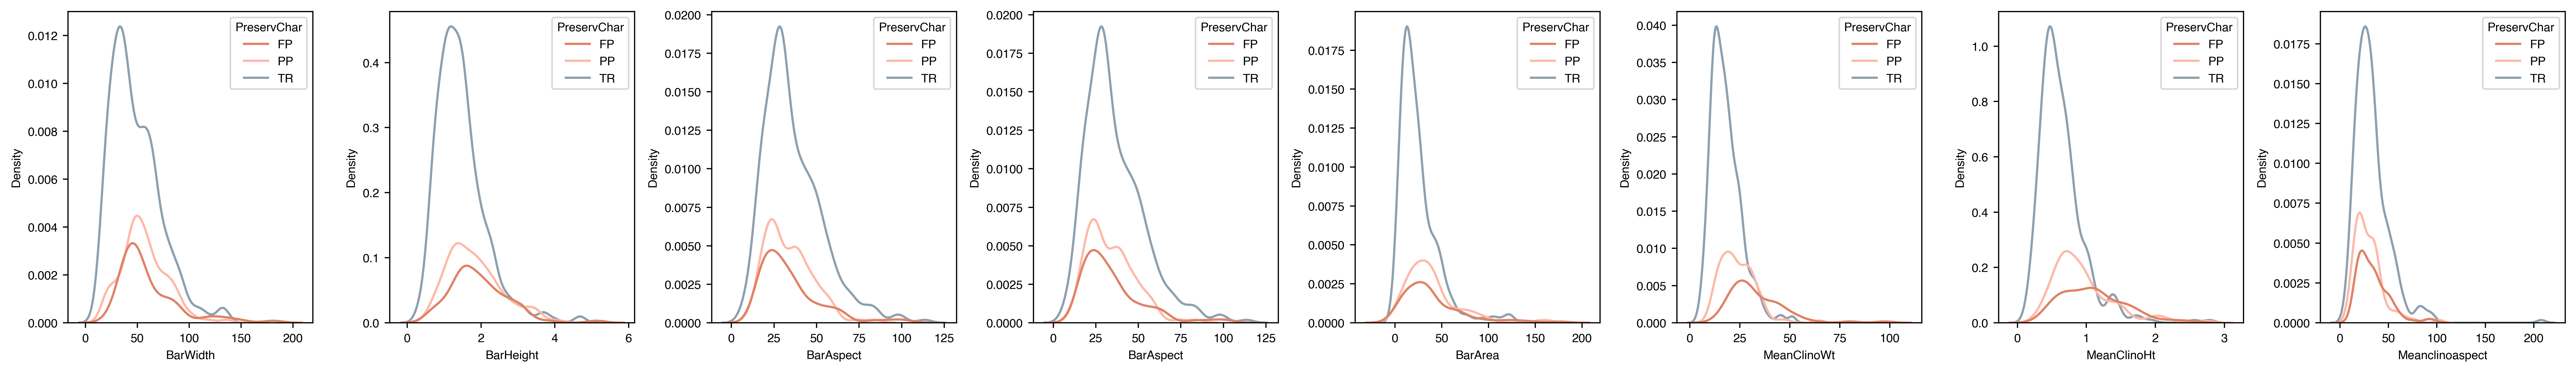

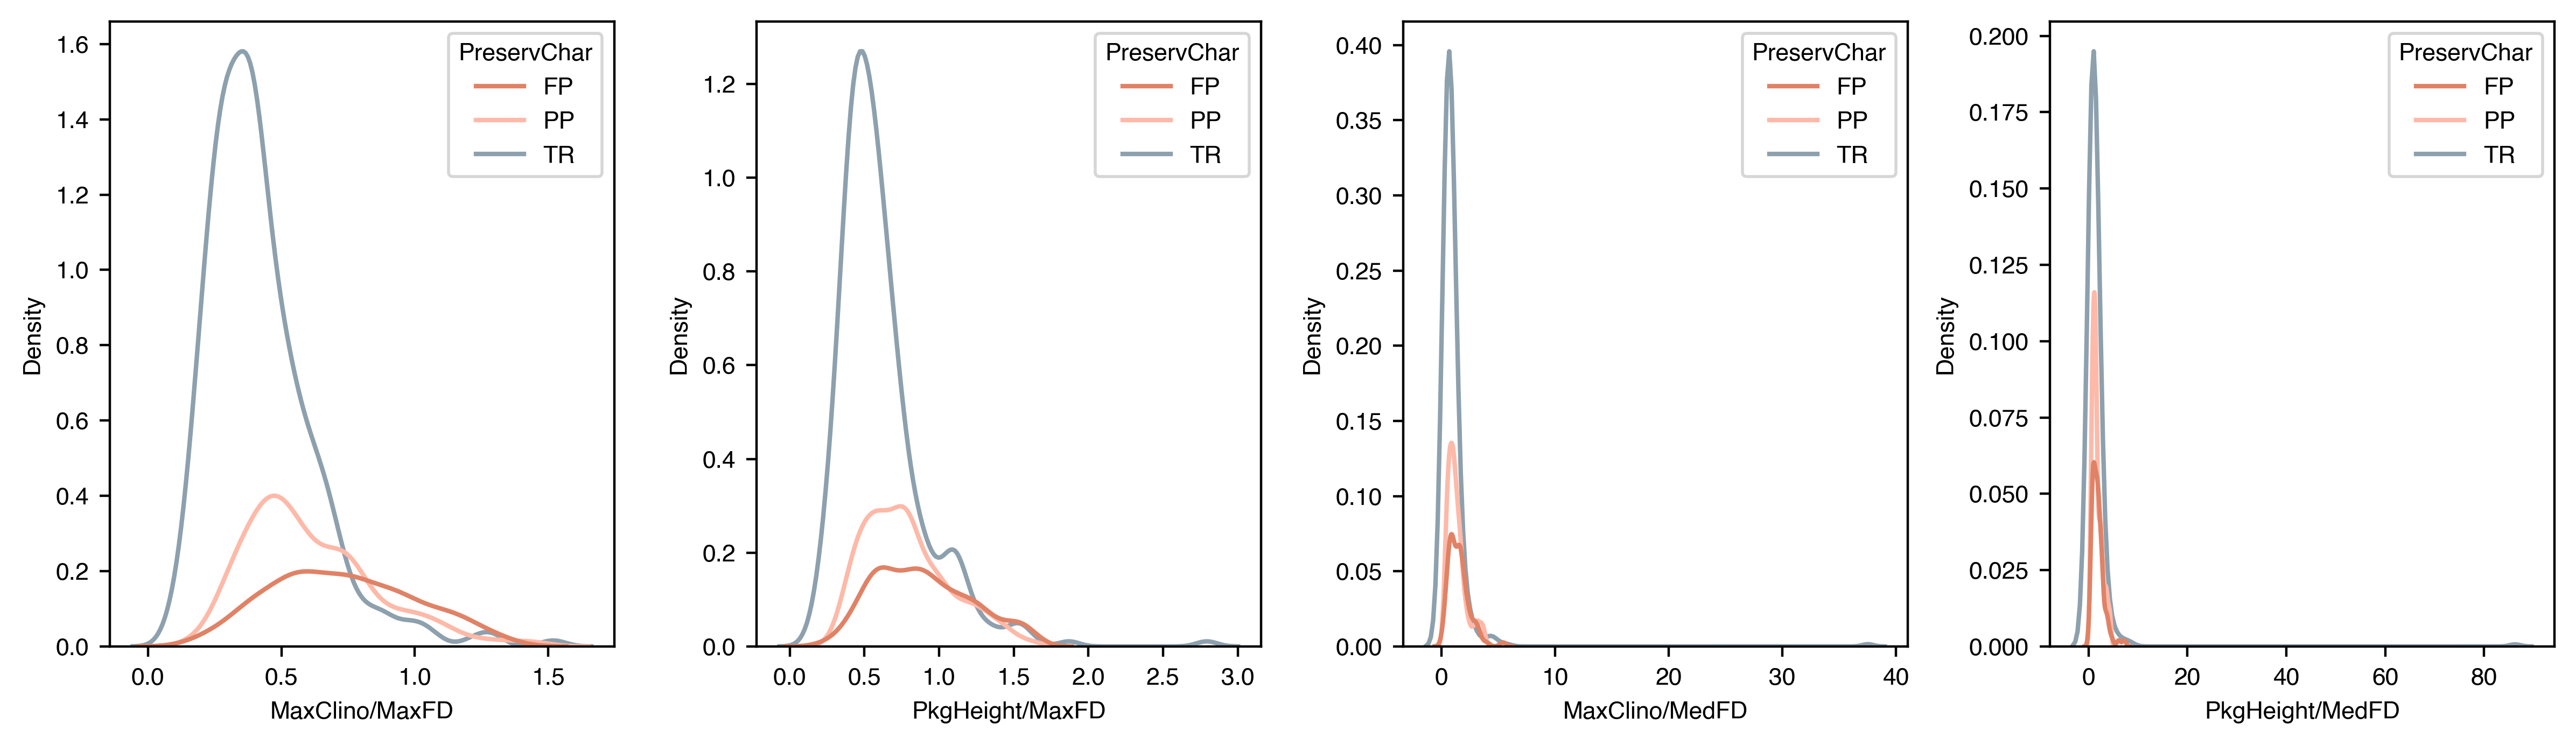

In [120]:
## New boxplots from Liz for writing results--also making violinplots

flierprops = dict(marker='.', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
boxprops = dict(edgecolor = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = 0.35
linewidth = 1.5

## PANEL 1———————time—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    sns.kdeplot(data = allbars[allbars['StartTime']>eqt], x = time[i], 
                   bw_adjust = .75, hue = 'PreservChar', 
                   palette = pres_palette, ax = a, linewidth = linewidth)#, width = boxwidth, notch = False, showfliers = True, 
               # boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerpr#ops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    # box = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = False, showfliers = True, 
    #            boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    # box.set_zorder(20)

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/pdf-panel3-time.png', dpi = 300)

## PANEL 2—————facies———————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(facies), figsize = (len(facies)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()

for i, a in enumerate(ax):
    sns.kdeplot(data = bar_facies, x = facies[i], 
                   bw_adjust = .75, hue = 'PreservChar', 
                   palette = pres_palette, ax = a, linewidth = linewidth)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel2.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/pdf-panel2-facies.png', dpi = 300)

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (len(geometric_vars)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.kdeplot(data = allbars[allbars['StartTime']>eqt], x = geometric_vars[i], 
                   bw_adjust = .75, hue = 'PreservChar', 
                   palette = pres_palette, ax = a, linewidth = linewidth)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/pdf-panel1-geometry.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# ## PANEL 4————————————————————————————————————————————————————————————————————————————————————————————————

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(scalers), figsize = (len(scalers)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    sns.kdeplot(data = allbars[allbars['StartTime']>eqt], x = scalers[i], 
                   bw_adjust = .75, hue = 'PreservChar', 
                   palette = pres_palette, ax = a, linewidth = linewidth)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/pdf-panel4-scaling.png', dpi = 300)

# ## PANEL 5————————————————————————————————————————————————————————————————————————————————————————————————

# fig, ax = plt.subplots(1, len(agg_flags), figsize = (12, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# for i, a in enumerate(ax):
#     sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = agg_flags[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
#                boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

# # ax[3].set_ylim(0, 15)
# # plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel4.png', dpi = 400)



### ANOVA

ANOVA test to check if means are different, following this [TDS article](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b)

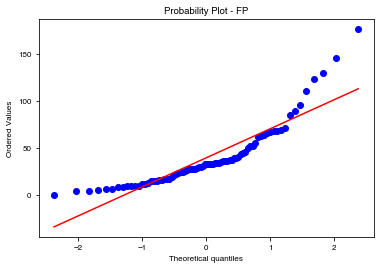

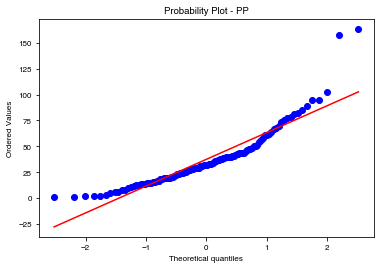

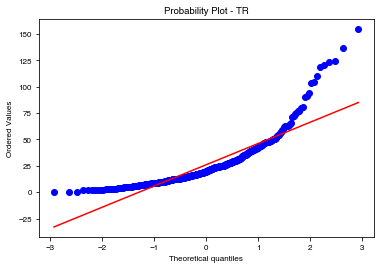

In [106]:
## test assumption of normality--normalish?
unique_preservals = allbars['PreservChar'].unique()
for vals in unique_preservals:
    stats.probplot(allbars[allbars['PreservChar'] == vals]['BarArea'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  vals)
    plt.show()

In [109]:
## homogeneity of variance testing--ratio is less than 2, so its ok
# calculate ratio of the largest to the smallest sample standard deviation
ratio = allbars.groupby('PreservChar').std().max() / allbars.groupby('PreservChar').std().min()
ratio['BarArea']

1.4785222501820812

In [110]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = allbars['BarArea'].mean()
SSTR = allbars.groupby('PreservChar').count() * (allbars.groupby('PreservChar').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['UBar'].sum()

# calculate SSE and update anova table
SSE = (allbars.groupby('PreservChar').count() - 1) * allbars.groupby('PreservChar').std()**2
anova_table['SS']['Within Groups'] = SSE['UBar'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['BarArea'].sum() + SSE['BarArea'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = allbars['PreservChar'].nunique() - 1
anova_table['df']['Within Groups'] = allbars.shape[0] - allbars['PreservChar'].nunique()
anova_table['df']['Total'] = allbars.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

SS   df          MS          F P-value  \
Source of Variation                                                      
Between Groups           77772.291    2  38886.1455  141.66566     0.0   
Within Groups         163597.46359  596  274.492389                      
Total                401791.819649  598  671.892675                      

                       F crit  
Source of Variation            
Between Groups       3.711806  
Within Groups                  
Total

In [111]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 141.66566039247638  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 141.66566039247638  and critical value is: 3.711805889216164
Null Hypothesis is rejected.


### Box/Cross plots for paper

In [129]:
agevars = ['StartTime', 'MeanAge', 'EndTime', 'ElapsedTime']
geometry = ['']

In [57]:
allbars.columns

Index(['BarName', 'array name', 'iloc', 'PreservChar', 'CoherenceVal',
       'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge', 'RightEdge',
       'BarWidth', 'BarHeight', 'BarAspect', 'BarArea', 'Section Area',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx',
       'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt',
       'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt', 'ModeClinoWt',
       'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD', 'MaxClinoICD',
       'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
       'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth',
       'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear', 'ModeShear',
       'MeanShear', 'SDShear', 'MedShear', 'MinVelocity', 'MaxVelocity',
       'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
       'TRAINFLAG', 'notes', 'CVFlowDepth', 'CVVelocity', 'VarFlowDepth',
       'VarVelocity', 'Skew Abs', 'TempAgg', 

<Figure size 2000x2000 with 0 Axes>

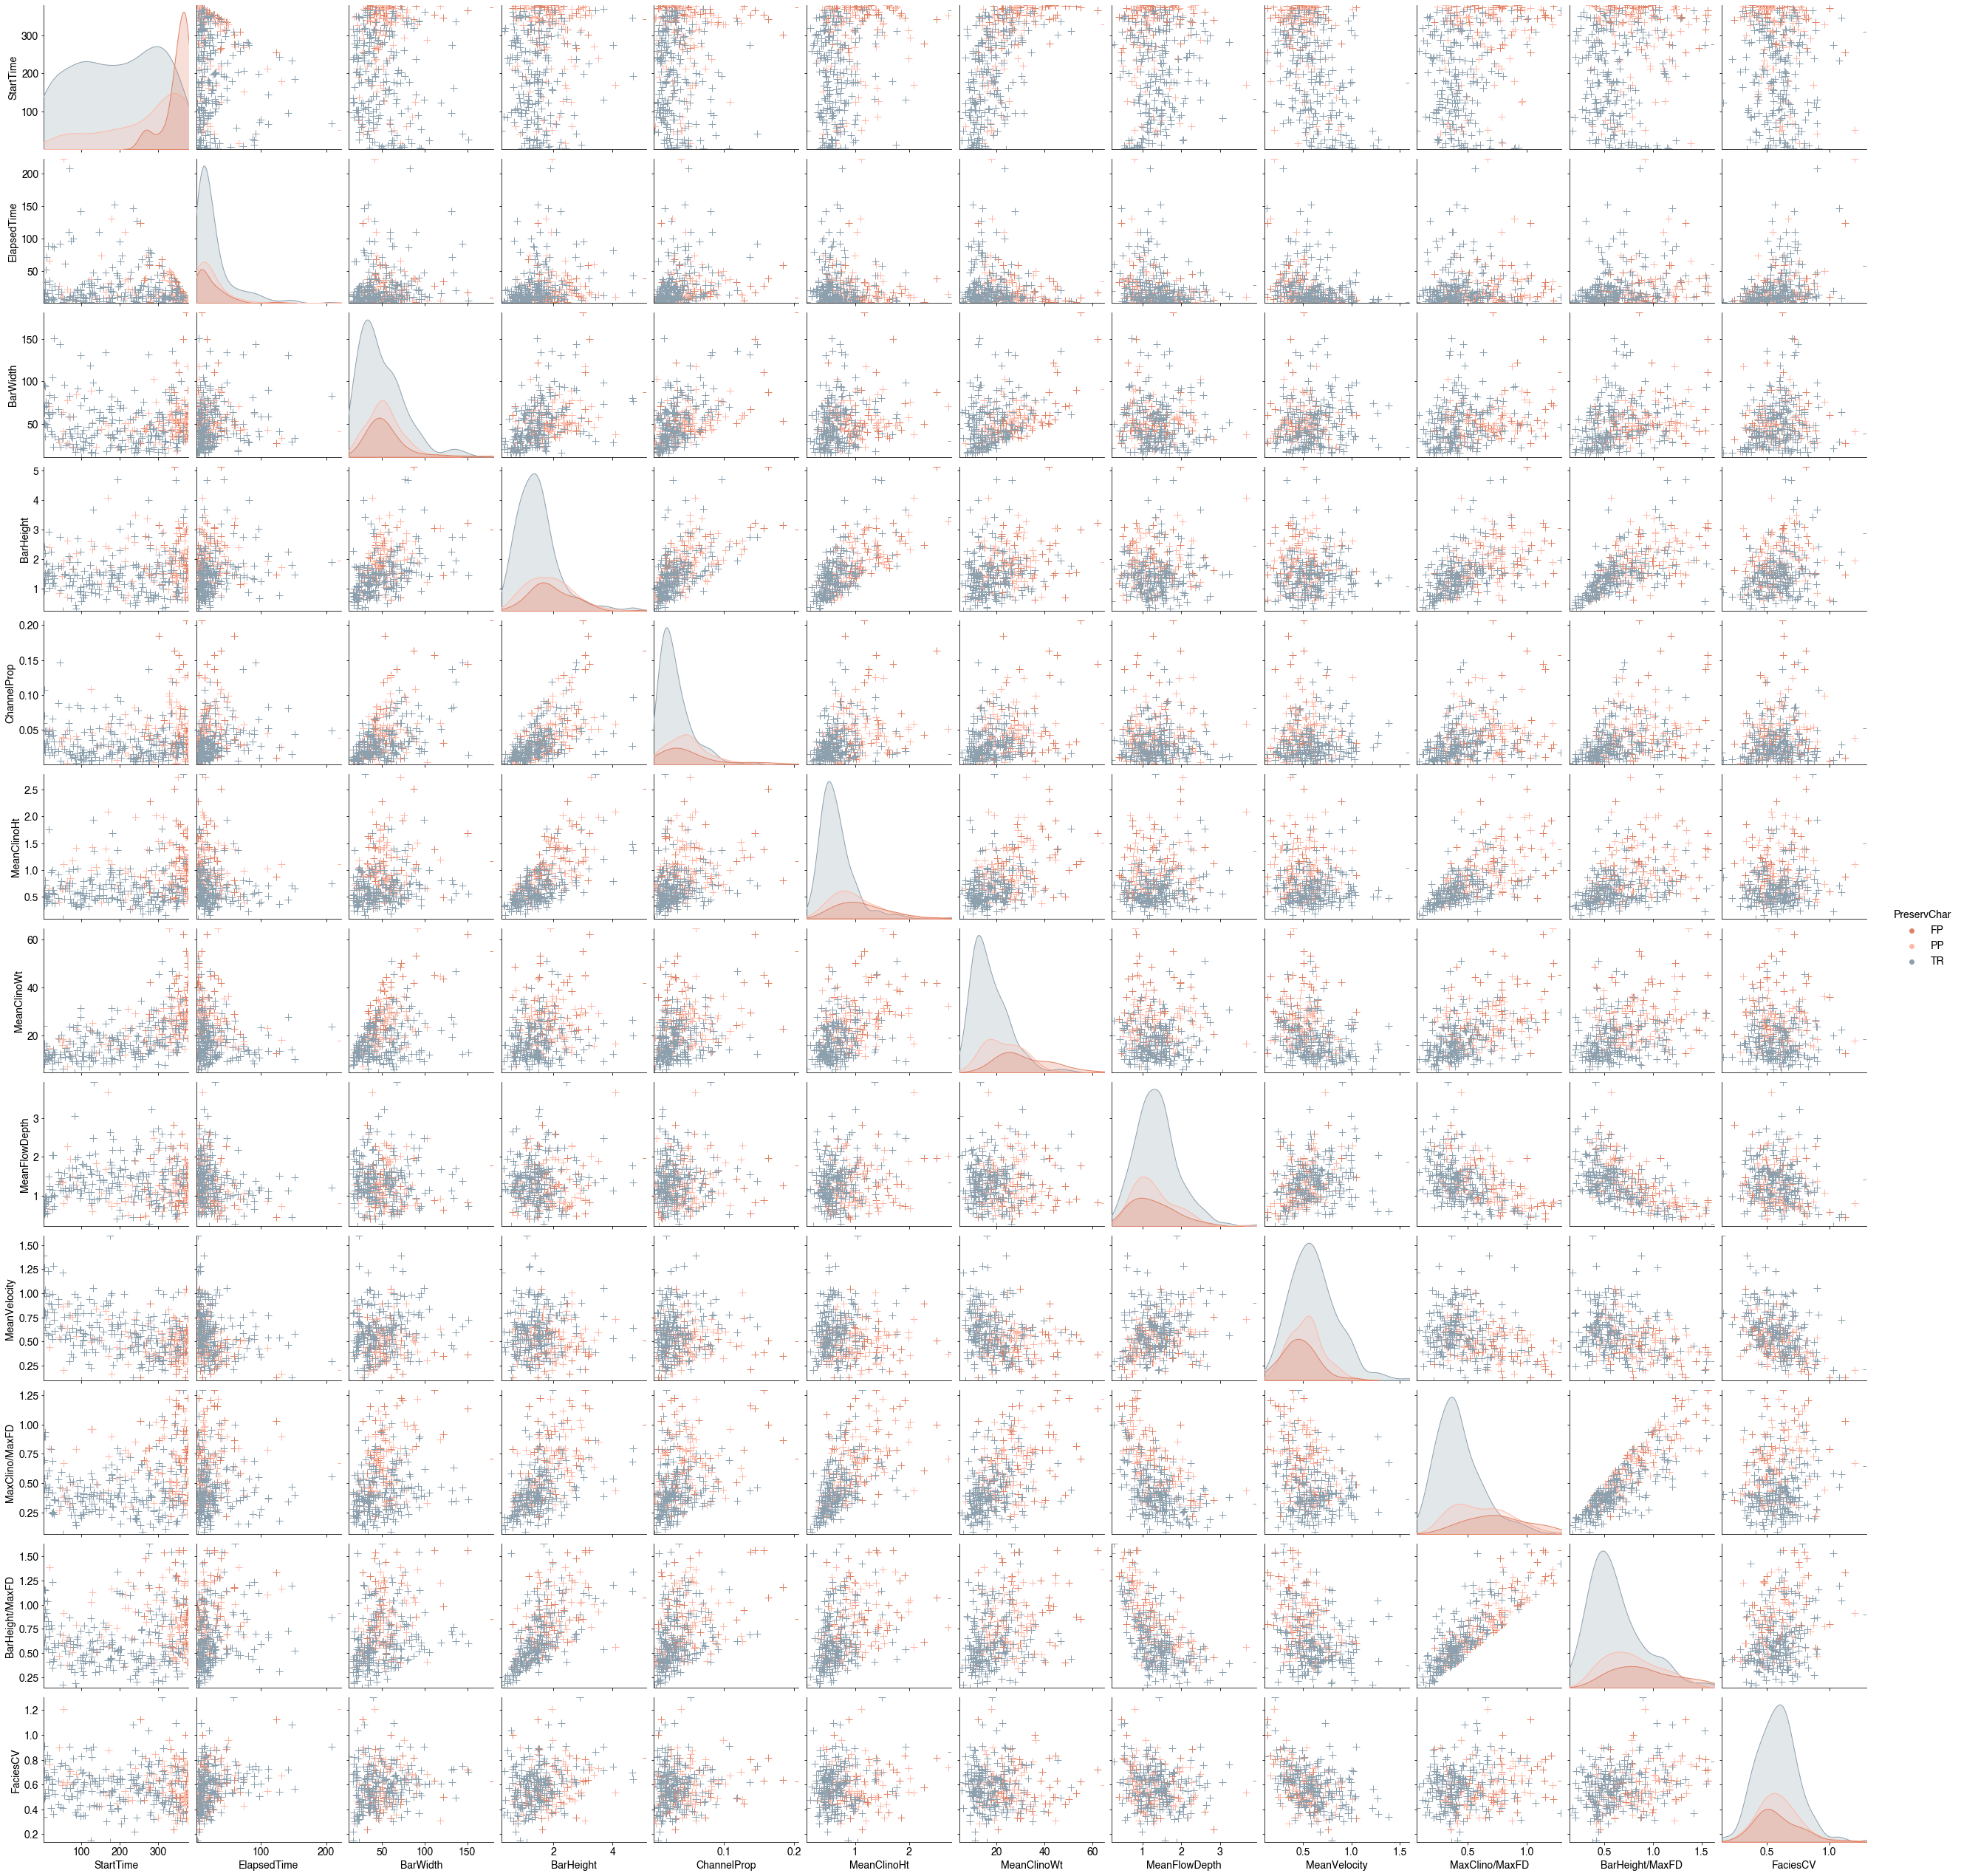

In [82]:
plt.figure(figsize = (20, 20), dpi = 100, tight_layout = True)
pplot = sns.pairplot(data=allbars, hue='PreservChar', palette=pres_palette, dropna=True,
             plot_kws=dict(marker = '+', linewidth=1, s = 100),
             vars=['StartTime', 'ElapsedTime', 'BarWidth', 'BarHeight', 'ChannelProp', 
                   'MeanClinoHt', 'MeanClinoWt', 'MeanFlowDepth', 'MeanVelocity', 'MaxClino/MaxFD',
                   'BarHeight/MaxFD', 'FaciesCV'],
             height = 3, aspect = 1)

snsvars=['StartTime', 'ElapsedTime', 'BarWidth', 'BarHeight', 'ChannelProp', 
                   'MeanClinoHt', 'MeanClinoWt', 'MeanFlowDepth', 'MeanVelocity', 'MaxClino/MaxFD',
                   'BarHeight/MaxFD', 'FaciesCV']
for i, v in enumerate(snsvars):
    pplot.axes[-1, i].set(xlim=(allbars[v].min(), allbars[v].max()))

for i, v in enumerate(snsvars):
    pplot.axes[i, 0].set(ylim=(allbars[v].min(), allbars[v].max()))


list_of_attribs = [
       'StartTime', 'CoherenceVal', 'ElapsedTime', 'BarWidth', 'BarHeight', 'BarAspect', 'BarArea',
       'ChannelProp', 'Angle Skewness', 'Basal Surf Relief',
       'Mean dzdx', 'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt',
       'MeanClinoHt', 'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt',
       'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD',
       'MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD',
       'MedClinoICD', 'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth',
       'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear',
       'ModeShear', 'MeanShear', 'SDShear', 'MedShear', 'MinVelocity',
       'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity',
       'MedVelocity', 'CVFlowDepth', 'CVVelocity',
       'Skew Abs', 'TempAgg', 'Skew Binned', 'Co Binned', 'BSR Binned',
       'MeanFacies', 'MedFacies', 'BarHeight/MaxFD',
       'MaxClino/MaxFD', 'MaxClino/MedFD', 'MedClino/MedFD', 'BFscaling',
       'BL/CL', 'ReconFlowDepth', 'UBar', 'mmpmean', 'FaciesCV', 'CVClinoWt']

<Figure size 1152x1152 with 0 Axes>

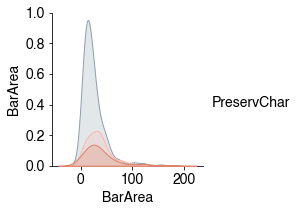

In [87]:
plt.figure(figsize = (16,16))
pplot = sns.pairplot(data=allbars, hue='PreservChar', palette=pres_palette, dropna=True,
             plot_kws=dict(marker = '+', linewidth=1, s = 100),
             vars=['BarArea'],
             height = 3, aspect = 1)

In [107]:
# fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi = 100, tight_layout = True, sharex = True, sharey = True)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[0], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=15), joint_kws=dict(bins=15))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[1], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=25), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'MedClinoWt', y = 'MedClinoHt', color = pres_palette[2], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=25), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

#### Number of turnover timescales vs bar size

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[0], kind = 'hist',
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[1], kind = 'hist',
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_11120/66003829.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[2], kind = 'hex',


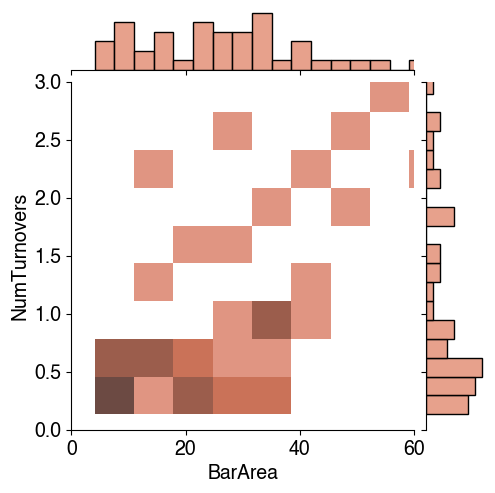

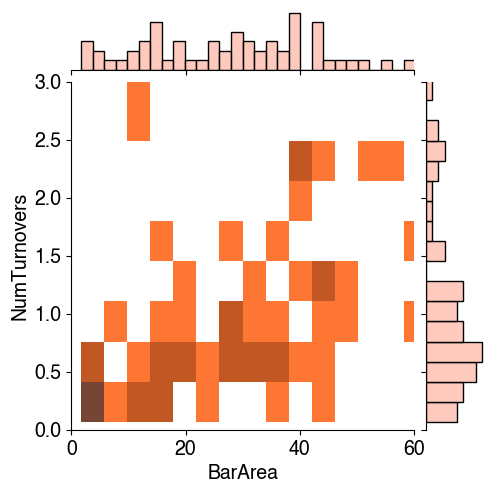

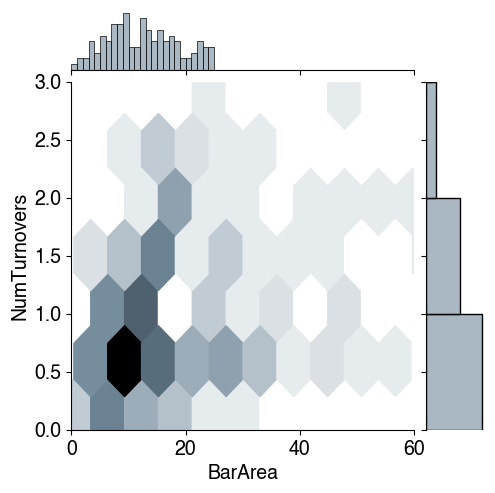

In [42]:
# fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi = 100, tight_layout = True, sharex = True, sharey = True)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='FP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[0], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=50), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='PP'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[1], kind = 'hist',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins=50), joint_kws=dict(bins=25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

grid = sns.jointplot(data = allbars[allbars['StartTime']>eqt][allbars['PreservChar']=='TR'], x = 'BarArea', y = 'NumTurnovers', color = pres_palette[2], kind = 'hex',
              palette = pres_palette, ratio = 5, xlim = (0, 60), ylim = (0, 3), marginal_kws=dict(bins = 25, binrange = [0, 25]), joint_kws=dict(bins = 25))
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
grid.fig.set_dpi(100)

make cmaps for the histograms

In [111]:
# colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
colors = ['w', pres_palette[0]]
cmapred = mcol.LinearSegmentedColormap.from_list('mycmap', colors, N=2)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]



cmapblue = mcol.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:373: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgba = np.array(c)


In [108]:
fpcmap = LinearSegmentedColormap.from_list("fpcmap", list(zip([0, 1], ['w', pres_palette[0]])))
# fpcmap[:,-1] = np.linspace(0, 1, fpcmap.N)
ppcmap = LinearSegmentedColormap.from_list("ppcmap", list(zip([0, 1], ['w', pres_palette[1]])))
trcmap = LinearSegmentedColormap.from_list("trcmap", list(zip([0, 1], ['w', pres_palette[2]])))

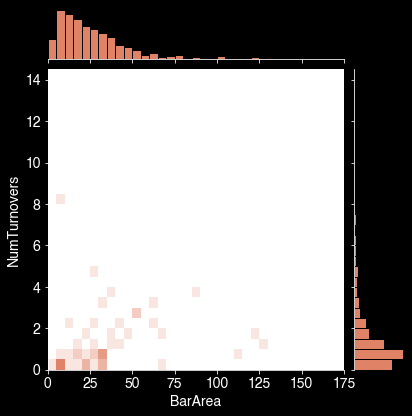

In [118]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='FP'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = fpcmap, color="#e08266", edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[0], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[0], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))
# ax = plt.gca()
# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

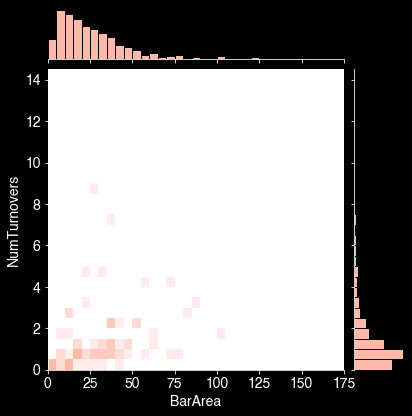

In [105]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='PP'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = ppcmap, edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[1], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[1], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))
# ax = plt.gca()
# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

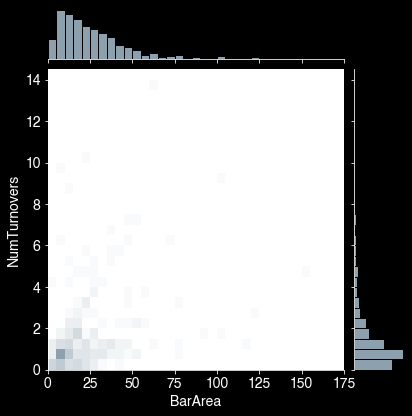

In [106]:
g = sns.JointGrid(x="BarArea", y="NumTurnovers", data=allbars[allbars['PreservChar']=='TR'])
g = g.plot_joint(plt.hist2d, bins = [np.arange(0, allbars['BarArea'].max(), 5), np.arange(0, allbars['NumTurnovers'].max(), 0.5)], density = True,
                 cmap = trcmap, edgecolor="k", linewidth = 0)

_ = g.ax_marg_x.hist(allbars["BarArea"], color=pres_palette[2], edgecolor = 'k', alpha=1,
                      bins=np.arange(0, allbars['BarArea'].max(), 5))
_ = g.ax_marg_y.hist(allbars["NumTurnovers"], color=pres_palette[2], edgecolor = 'k', alpha=1,
                      orientation="horizontal",
                      bins=np.arange(0, allbars['NumTurnovers'].max(), 0.5))

# ax.set_xlim = (allbarsFP['BarArea'].min(), allbarsFP['BarArea'].max())
# ax.set_ylim = (allbarsFP['NumTurnovers'].min(), allbarsFP['NumTurnovers'].max())

## Testing hypotheses from candidacy propsal:
1. Increased preservation in zones where the channel is widening
2. Wider, thinner packages at zones of thread splitting
3. More relief at zones where channel belt is widening

In [41]:
np.unique(np.where(np.isnan(profile_master))[1])

array([0, 1, 2, 3, 4, 5, 6])

In [69]:
avg_wr = np.nanmean(total_wr_2h, axis = 1)
wideningzones = np.where(avg_wr>np.nanquantile(avg_wr, 0.5))[0]
widening10 = np.unique(np.round(wideningzones, -1))

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_74384/1592015117.py:1: RuntimeWarning: Mean of empty slice
  avg_wr = np.nanmean(total_wr_2h, axis = 1)


In [70]:
avg_wr.shape

(1001,)

Text(0.5, 1.0, 'average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

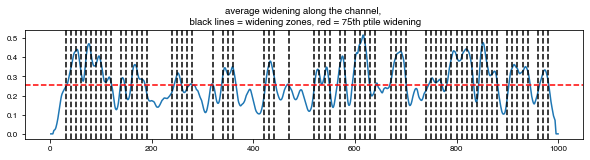

In [71]:
plt.figure(figsize = (10, 2))
plt.plot(avg_wr)
plt.axhline(np.nanquantile(avg_wr, 0.5), c = 'r', ls = '--')
for i in widening10:
    plt.axvline(i, c = 'k', ls = '--')
    
plt.title('average widening along the channel, \n black lines = widening zones, red = 75th ptile widening')

In [72]:
total_wr_2h.shape

(1001, 316)

In [73]:
wideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = wideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is False:
        wideningbars = wideningbars.drop([row])

notwideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = notwideningbars['iloc'].loc[row] in widening10
    # print(inarr)
    if inarr is True:
        notwideningbars = notwideningbars.drop([row])

    
# df.drop(df[(df.score < 50) & (df.score > 20)].index)

Text(0.5, 1.0, '<75th p Widening')

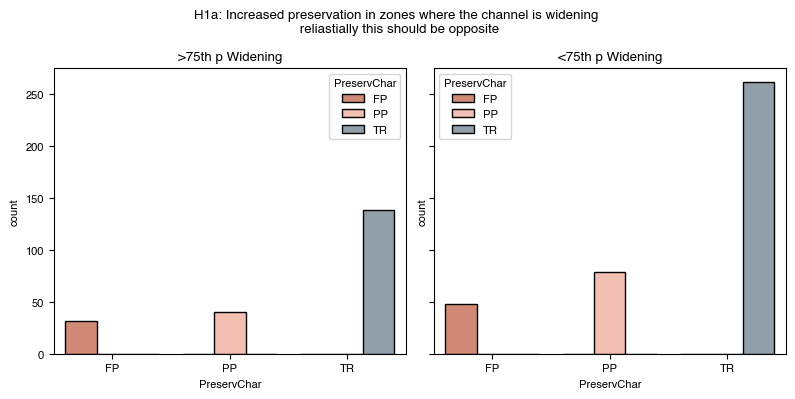

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi = 100)
sns.countplot(x = 'PreservChar', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0], edgecolor = 'k')
sns.countplot(x = 'PreservChar', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1], edgecolor = 'k')
fig.suptitle('H1a: Increased preservation in zones where the channel is widening \n reliastially this should be opposite')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

Text(0.5, 1.0, '<75th p Widening')

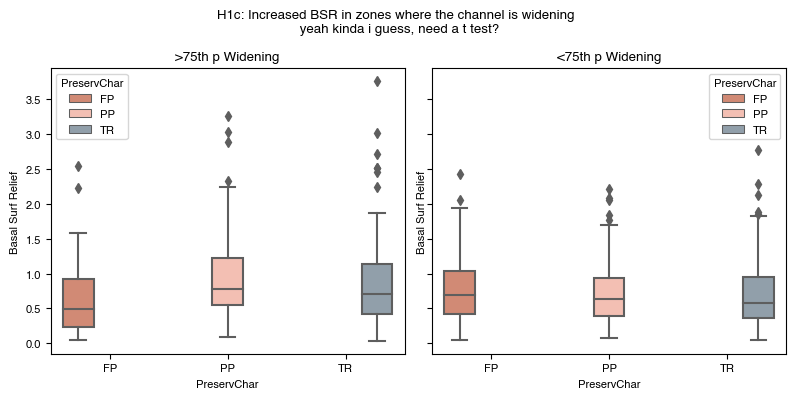

In [75]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), tight_layout=True, sharey = True, dpi= 100)
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = wideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[0])#, edgecolor = 'k')
sns.boxplot(x = 'PreservChar', y = 'Basal Surf Relief', data = notwideningbars, hue = 'PreservChar', palette = pres_palette, ax = ax[1])#, edgecolor = 'k')
fig.suptitle('H1c: Increased BSR in zones where the channel is widening \n yeah kinda i guess, need a t test?')
ax[0].set_title('>75th p Widening')
ax[1].set_title('<75th p Widening')

## Compare between sections
### Proportion (skyscraper) plot, make sure sort is FP, PP, TR

In [25]:
## load cumulative props of strat and bed facies from fulldomain processes
bed_bottoms = np.load('/Users/safiya/Desktop/BarManuscript_2022-local/bed_perc.npy', allow_pickle = True)
strat_bottoms = np.load('/Users/safiya/Desktop/BarManuscript_2022-local/strat_perc.npy', allow_pickle = True)

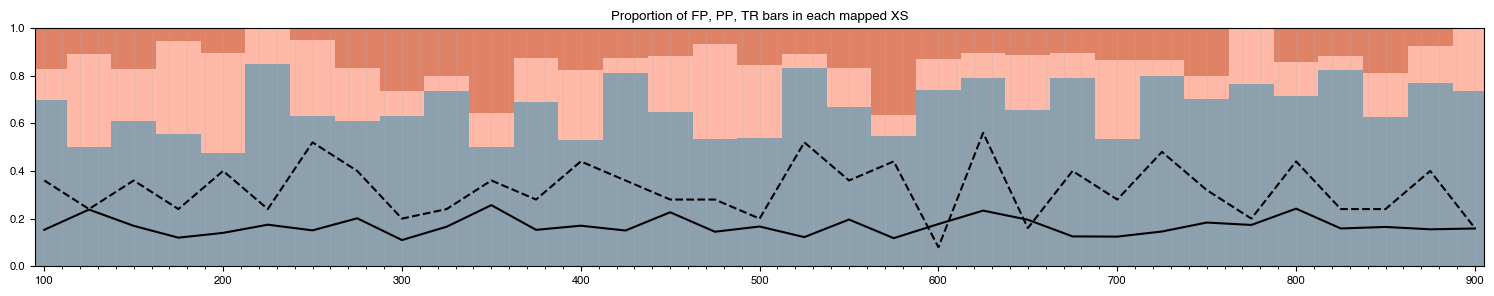

In [26]:
activech_mode = stats.mode(active_channels, axis = 1)[0]
pres_frequencies = np.empty([4, len(np.unique(allbars['iloc']))])
pres_frequencies[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    totalbars = len(subsample)
    pres_frequencies[1, idx] = len(subsample[subsample['PreservChar']=='FP'])/totalbars
    pres_frequencies[2, idx] = len(subsample[subsample['PreservChar']=='PP'])/totalbars
    pres_frequencies[3, idx] = len(subsample[subsample['PreservChar']=='TR'])/totalbars

    plt.bar(i, pres_frequencies[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_frequencies[2, idx], w, bottom = pres_frequencies[3, idx], color = pres_cols[1])
    plt.bar(i, pres_frequencies[1, idx], w, bottom = np.sum(pres_frequencies[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.25)

ax.plot(np.arange(100, 925, 25), bed_bottoms[1, :], 'k--')
ax.plot(np.arange(100, 925, 25), strat_bottoms[1, :], 'k-')

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/skyscraper250-count.png', transparent = True, dpi=300)
# plt.xlabel('Streamwise distance, m')
# plt.ylabel('Bar proportion')

# ax = plt.gca()
# ax1 = ax.twinx()
# ax1.plot(avg_wr, 'k-')
# ax1.axhline(np.quantile(avg_wr, 0.5), c = 'k', ls = '--', alpha = 0.5)
# ax1.set_ylabel('Average widening rate')

# ax1.fill_between(np.arange(0, len(active_channels)), active_channels.min(axis = 1), active_channels.max(axis = 1), alpha = 0.1, color = 'k')
# plt.plot(activech_mode, 'k-')
# # plt.fill_between(np.arange(0, len(total_wr_2h))*10, total_wr_2h.min(axis = 1), total_wr_2h.max(axis = 1), alpha = 0.1, color = 'k')

In [95]:
threaddf_mapped.iloc[:, 2:35]

100  125  150  175  200  225  250  275  300  325  ...  675  700  725  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
2    1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
3    1.0  2.0  2.0  1.0  3.0  1.0  1.0  2.0  1.0  2.0  ...  1.0  1.0  1.0   
4    1.0  2.0  2.0  2.0  1.0  2.0  3.0  2.0  2.0  2.0  ...  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
377  2.0  2.0  2.0  1.0  4.0  1.0  2.0  2.0  3.0  2.0  ...  1.0  1.0  3.0   
378  2.0  2.0  2.0  1.0  4.0  1.0  2.0  2.0  3.0  2.0  ...  2.0  2.0  5.0   
379  2.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  3.0  2.0  ...  2.0  2.0  5.0   
380  1.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  3.0  2.0  ...  2.0  1.0  5.0   
381  1.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  4.0  2.0  ...  2.0  1.0  5.0   

     750  775  800  825  850  875  900  
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
..   ...  ...  ...  ...  ...  ...  ...  
377  1.0  1.0  2.0  1.0  2.0  2.0  2.0  
378  1.0  1.0  2.0  1.0  2.0  2.0  2.0  
379  1.0  1.0  2.0  1.0  2.0  2.0  2.0  
380  1.0  1.0  2.0  1.0  1.0  2.0  2.0  
381  1.0  1.0  2.0  1.0  2.0  2.0  2.0  

[382 rows x 33 columns]

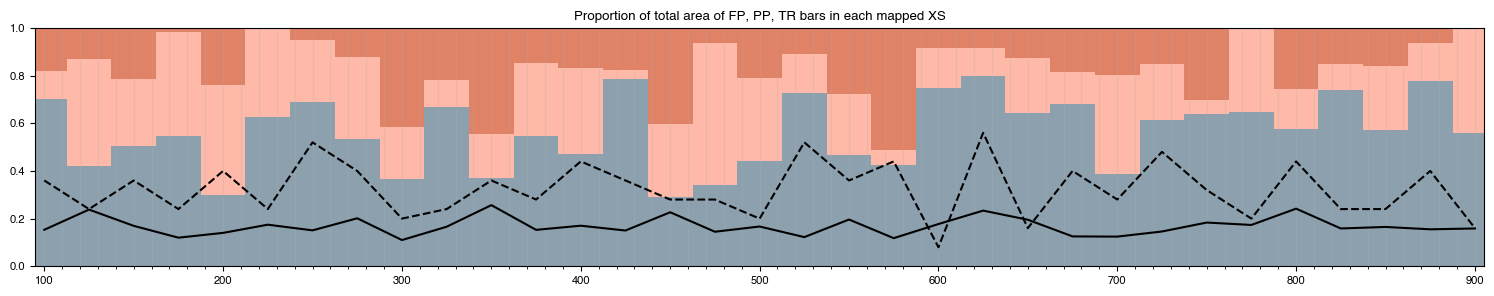

In [27]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
    propmapped = sum(subsample['ChannelProp'])
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])/propmapped
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])/propmapped
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])/propmapped

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.25)
ax.plot(np.arange(100, 925, 25), bed_bottoms[1, :], 'k--')
ax.plot(np.arange(100, 925, 25), strat_bottoms[1, :], 'k-')
# ax1 = ax.twinx()
# ax.plot(avg_wr, 'k-', label = 'WR per hr')
# ax.plot(np.nanmean(widening_tt, axis = 1), 'k--', label = 'TT scaled')
# ax.axhline(np.quantile(avg_wr, 0.5), c = 'k', ls = '--', alpha = 0.5)
# ax.set_ylabel('Average widening rate, per hour')
# ax1.plot(np.arange(100, 925, 25), stats.variation(threaddf_mapped.iloc[:, 2:35], axis = 0), label = 'active CV')
# ax1.plot(np.arange(100, 925, 25), stats.variation(wetwidthdf_mapped.iloc[:, 2:35], axis = 0), label = 'wet width CV')
# ax.plot(np.arange(100, 925, 25), stats.variation(np.divide(wetwidthdf_mapped.iloc[:, 2:35], threaddf_mapped.iloc[:, 2:35]), axis = 0), label = 'WW/active CV', c = 'r')
# ax.legend()

# ax1.plot(np.arange(100, 925, 25), np.nanmean(np.divide(wetwidthdf_mapped.iloc[:, 2:35], threaddf_mapped.iloc[:, 2:35]), axis = 0), label = 'WW/active CV', c = 'b', ls = '--')

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/skyscraper250m-area.png', transparent = True, dpi = 300)


In [30]:
pres_area.shape[1]

33

In [ ]:
## make a plot thta show how these stats change with sampling
# for xs in range(0, pres_area.shape[1]):
    

In [ ]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
    propmapped = sum(subsample['ChannelProp'])
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])/propmapped
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])/propmapped
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])/propmapped

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

Text(0, 0.5, 'prop area')

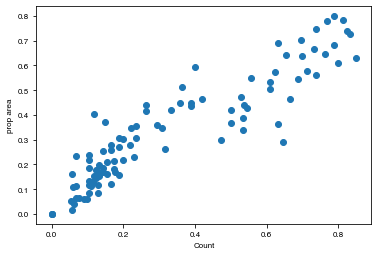

In [80]:
plt.scatter(pres_frequencies[1:, :], pres_area[1:, :])
plt.xlabel('Count')
plt.ylabel('prop area')

In [50]:
allbars['AreaovTime'] = allbars['BarArea']/allbars['ElapsedTime']

(0.0, 10.0)

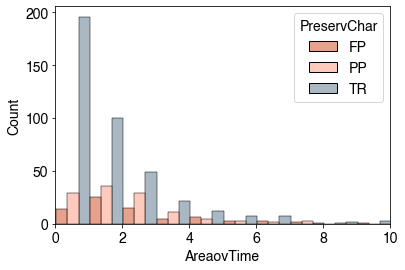

In [51]:
sns.histplot(x = 'AreaovTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', binwidth = 1)
plt.xlim(0, 10)

<AxesSubplot:xlabel='PreservChar', ylabel='StartTime'>

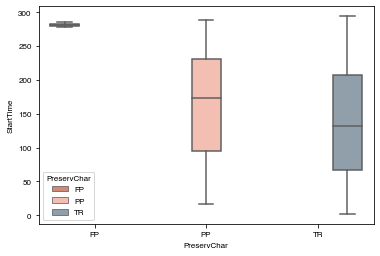

In [112]:
ab_middleage = allbars[allbars['EndTime']<300]
sns.boxplot(data = ab_middleage, x = 'PreservChar', y = 'StartTime', hue = 'PreservChar', palette = pres_palette)

[None]

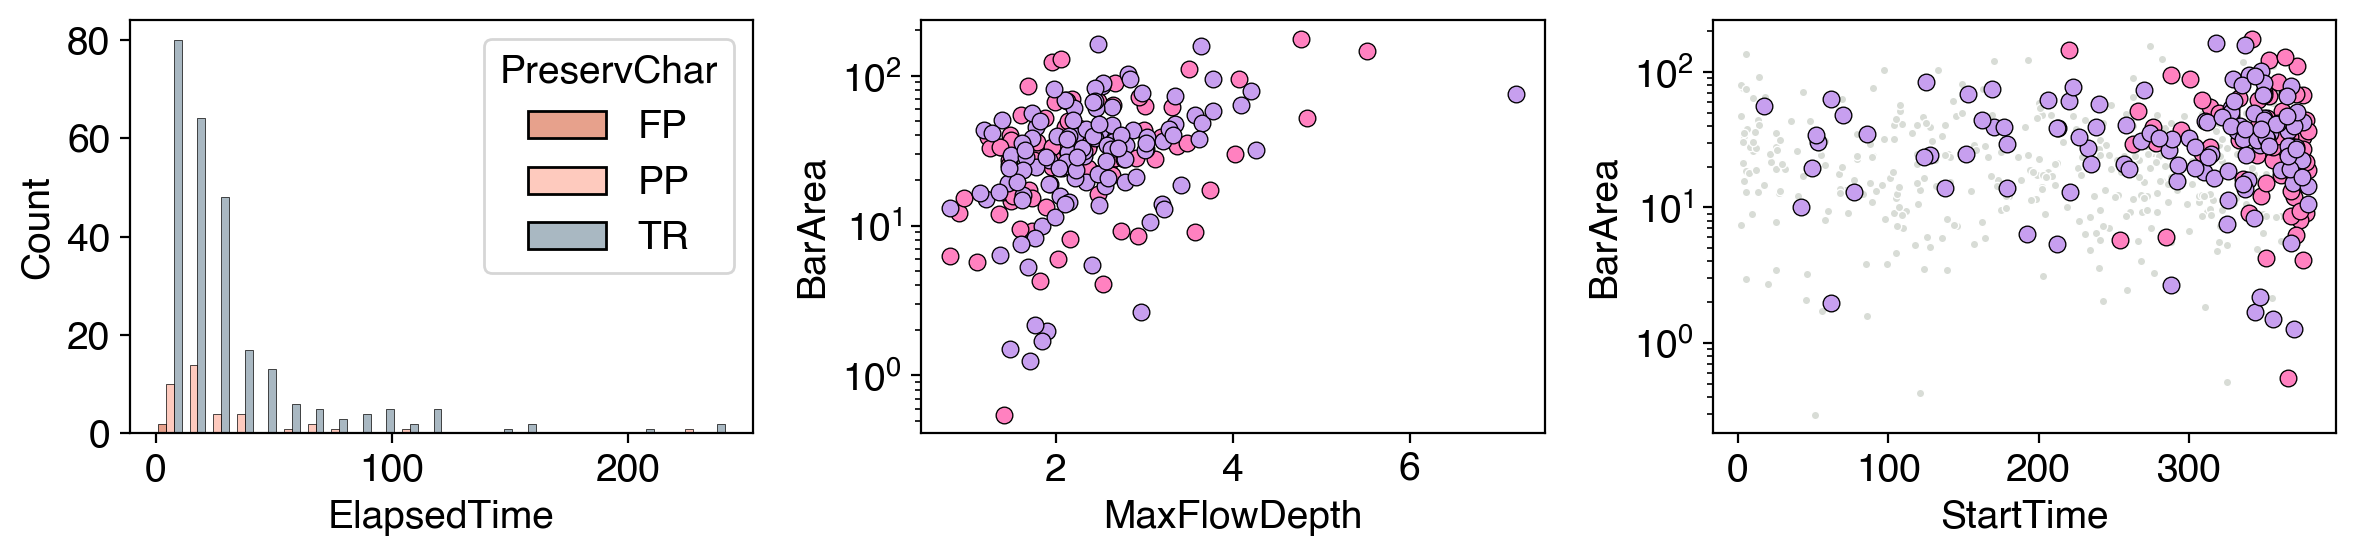

In [52]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi = 200, tight_layout = True)
sns.histplot(x = 'ElapsedTime', data = allbars[allbars['EndTime']<300], hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', ax = ax[0], binwidth = 10)
# sns.histplot(x = 'ElapsedTime', data = allbars, hue = 'PreservChar', palette = pres_palette, multiple = 'stack', ax = ax[1], binwidth = 10)
timeplot = sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='TR'], ax = ax[2], c = ['xkcd:light grey'], marker = '.')
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='FP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:pink'])
sns.scatterplot(x = 'StartTime', y = 'BarArea', data = allbars[allbars['PreservChar']=='PP'], ax = ax[2], edgecolor = 'k', c = ['xkcd:lavender'])

# sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='TR'], ax = ax[1], c = ['xkcd:light grey'], marker = '.')
sizeplot = sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='FP'], ax = ax[1], edgecolor = 'k', c = ['xkcd:pink'])#, size = 'ElapsedTime')
sizeplot = sns.scatterplot(x = 'MaxFlowDepth', y = 'BarArea', data = allbars[allbars['PreservChar']=='PP'], ax = ax[1], edgecolor = 'k', c = ['xkcd:lavender'])#, size = 'ElapsedTime')
# sizeplot.set(xscale = 'log')
sizeplot.set(yscale = 'log')
timeplot.set(yscale = 'log')



<AxesSubplot:xlabel='BarArea', ylabel='Density'>

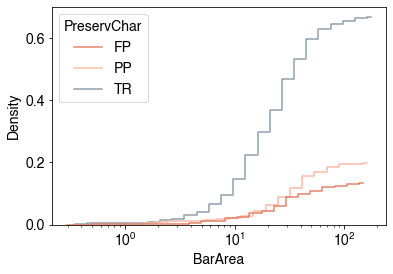

In [53]:
sns.histplot(data = allbars, x='BarArea', hue = 'PreservChar', palette = pres_palette, multiple = 'dodge', cumulative=True, element='step', fill=False, log_scale=True, stat='density')

## Channel kinematics (threadiness and wetted width statistics)
### box plots of wetted width and number of active channels

### Box plots of each section

In [82]:
active_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
threaddf = pd.DataFrame(active_channels.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
threaddf_mapped = deepcopy(threaddf.iloc[:, ::25]).iloc[:, 2:-2]

In [92]:
threaddf_mapped

50   75   100  125  150  175  200  225  250  275  ...  725  750  775  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
2    2.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
3    1.0  1.0  1.0  2.0  2.0  1.0  3.0  1.0  1.0  2.0  ...  1.0  1.0  1.0   
4    1.0  1.0  1.0  2.0  2.0  2.0  1.0  2.0  3.0  2.0  ...  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
377  1.0  2.0  2.0  2.0  2.0  1.0  4.0  1.0  2.0  2.0  ...  3.0  1.0  1.0   
378  1.0  2.0  2.0  2.0  2.0  1.0  4.0  1.0  2.0  2.0  ...  5.0  1.0  1.0   
379  1.0  2.0  2.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  ...  5.0  1.0  1.0   
380  1.0  2.0  1.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  ...  5.0  1.0  1.0   
381  1.0  2.0  1.0  2.0  2.0  1.0  4.0  1.0  3.0  2.0  ...  5.0  1.0  1.0   

     800  825  850  875  900  925  950  
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  
..   ...  ...  ...  ...  ...  ...  ...  
377  2.0  1.0  2.0  2.0  2.0  3.0  4.0  
378  2.0  1.0  2.0  2.0  2.0  4.0  4.0  
379  2.0  1.0  2.0  2.0  2.0  4.0  4.0  
380  2.0  1.0  1.0  2.0  2.0  4.0  4.0  
381  2.0  1.0  2.0  2.0  2.0  4.0  4.0  

[382 rows x 37 columns]

In [83]:
# wetwid_idx = np.concatenate((np.reshape(np.arange(0, 10010, 10), (active_channels.shape[0], 1)), active_channels), axis = 1)
wetwidthdf = pd.DataFrame(wetted_width.T)
# threaddf.columns = threaddf.iloc[0] ## put all the active channel data in a df
wetwidthdf_mapped = deepcopy(wetwidthdf.iloc[:, ::25]).iloc[:, 2:-2]

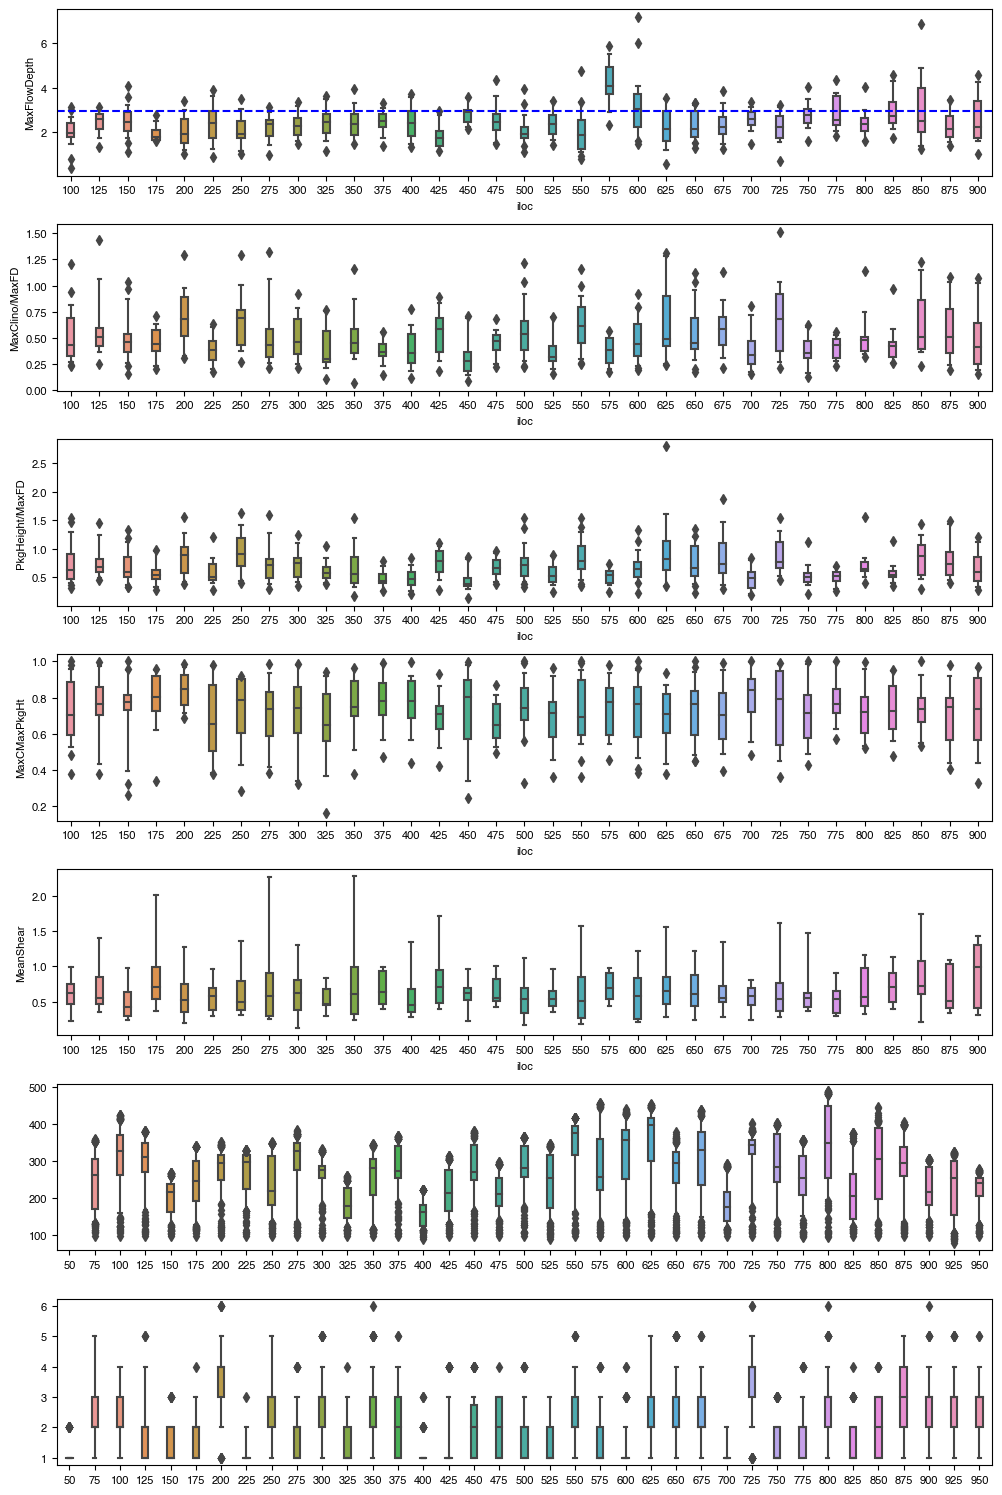

In [88]:
fig, ax = plt.subplots(7, 1, figsize = (10, 15), dpi = 100, tight_layout = True)
sns.boxplot(x = allbars['iloc'], y = allbars['MaxFlowDepth'], width = 0.25, whis = (5, 95), ax = ax[0])
sns.boxplot(data = allbars, x = 'iloc', y = 'MaxClino/MaxFD', width = 0.25, whis = (5, 95), ax = ax[1])
sns.boxplot(data = allbars, x = 'iloc', y = 'PkgHeight/MaxFD', width = 0.25, whis = (5, 95), ax = ax[2])
sns.boxplot(data = allbars, x = 'iloc', y = 'MaxCMaxPkgHt', width = 0.25, whis = (5, 95), ax = ax[3])
sns.boxplot(data = allbars, x = 'iloc', y = 'MeanShear', width = 0.25, whis = (5, 95), ax = ax[4], showfliers=False)
sns.boxplot(data = wetwidthdf_mapped, whis = (5, 95), width = .25, ax = ax[5])
sns.boxplot(data = threaddf_mapped, whis = (5, 95), width = .25, ax = ax[6])

# ax[0].hlines(np.quantile(datamaster[adjustment_time:, 4, :], [0.05, .95]), xmin = 0, xmax = 10)
ax[0].axhline(np.quantile(datamaster[adjustment_time:, 4, :], [.99]), c = 'b', ls = '--')

In [85]:
ww_thread = wetwidthdf_mapped/threaddf_mapped

In [86]:
stats.variation(threaddf_mapped, axis = 0)

array([0.19742311, 0.48411171, 0.37000425, 0.43828878, 0.38867753,
       0.39272081, 0.24794342, 0.34010451, 0.40690963, 0.43728289,
       0.29879559, 0.45962046, 0.46625341, 0.44231088, 0.23510636,
       0.56256815, 0.41860821, 0.36812389, 0.42763024, 0.46469368,
       0.39718569, 0.47098136, 0.39507719, 0.45143427, 0.40888542,
       0.32468809, 0.34091745, 0.3038037 , 0.42438308, 0.47127587,
       0.42788271, 0.41664413, 0.42178107, 0.4147989 , 0.30572526,
       0.37117539, 0.40825027])

Text(0, 0.5, 'SD threads')

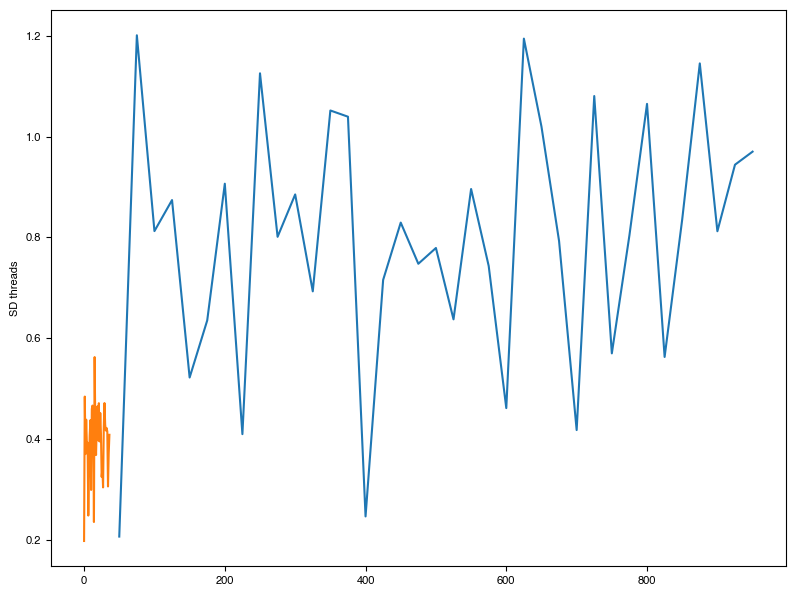

In [87]:
plt.figure(figsize = (8,6), tight_layout = True, dpi = 100)
plt.plot(np.std(threaddf_mapped, axis = 0), label = 'num threads')
plt.plot(stats.variation(threaddf_mapped, axis = 0), label = 'num threads')
# ax = plt.gca()
# ax1 = ax.twinx()
# ax1.plot(np.std(wetwidthdf_mapped, axis = 0), label = 'wetted width', ls = '--')
# ax1.set_ylabel('Standard deviation, WW')
plt.ylabel('SD threads')


In [87]:
ww_thread.column()

AttributeError: 'DataFrame' object has no attribute 'column'

Text(0, 0.5, 'WW/Num threads')

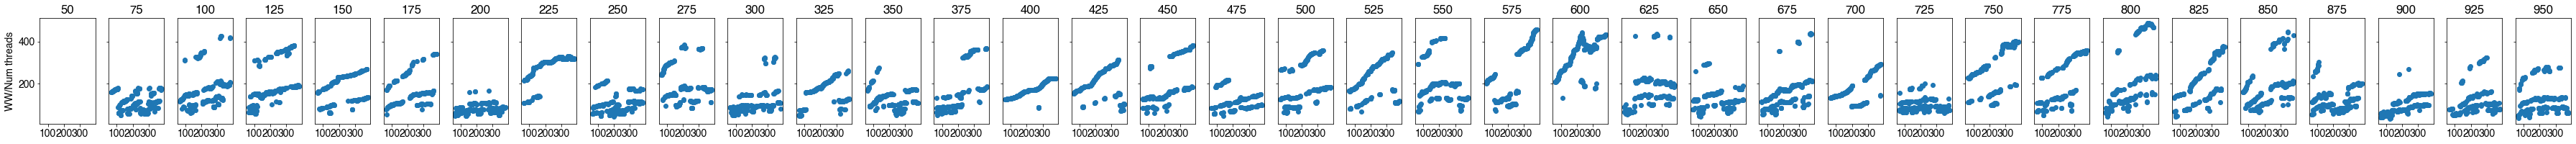

In [88]:
fig, ax = plt.subplots(1, 37, figsize = (50, 3), sharex = True, sharey = True, tight_layout = True)
for i in range(ww_thread.shape[1]):
    ax[i].scatter(np.arange(adjustment_time, ww_thread.shape[0]), ww_thread.iloc[adjustment_time:, i])
    ax[i].set_title(ww_thread.columns[i])
ax[0].set_ylabel('WW/Num threads')    

Looking at number of active threads during and following deposition of bars.

In [66]:
wideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = wideningbars['iloc'].loc[row] in widening10
    if inarr is False:
        wideningbars = wideningbars.drop([row])

notwideningbars = deepcopy(allbars)
for row in range(0, len(allbars)):
    inarr = notwideningbars['iloc'].loc[row] in widening10
    if inarr is True:
        notwideningbars = notwideningbars.drop([row])


In [273]:
## find what these represent 
countfp = len(allbars[allbars['PreservChar']=='FP'])
countpp = len(allbars[allbars['PreservChar']=='PP'])
counttr = len(allbars[allbars['PreservChar']=='TR'])

propwidening_fp = len(wideningbars[wideningbars['PreservChar']=='FP'])/countfp
propwidening_pp = len(wideningbars[wideningbars['PreservChar']=='PP'])/countpp
propwidening_tr = len(wideningbars[wideningbars['PreservChar']=='TR'])/counttr

propnotwidening_fp = len(notwideningbars[notwideningbars['PreservChar']=='FP'])/countfp
propnotwidening_pp = len(notwideningbars[notwideningbars['PreservChar']=='PP'])/countpp
propnotwidening_tr = len(notwideningbars[notwideningbars['PreservChar']=='TR'])/counttr

In [274]:
print(f'Fully preserved in widening reach vs not widening: {np.round(propwidening_fp, 2)}, {np.round(propnotwidening_fp, 2)}')
print(f'Partially preserved in widening reach vs not widening: {np.round(propwidening_pp, 2)}, {np.round(propnotwidening_pp, 2)}')
print(f'Truncated in widening reach vs not widening: {np.round(propwidening_tr, 2)}, {np.round(propnotwidening_tr, 2)}')

Fully preserved in widening reach vs not widening: 0.68, 0.32
Partially preserved in widening reach vs not widening: 0.7, 0.3
Truncated in widening reach vs not widening: 0.67, 0.33


Looking at number of active threads during and following deposition of bars.

In [46]:
allbars['ActiveDuring'] = np.nan
allbars['ActiveAfter'] = np.nan
allbars['ActiveCV'] = np.nan
allbars['AfterCV'] = np.nan

for idx, dat in enumerate(zip(allbars['iloc'], allbars['StartTime'], allbars['EndTime'])):
    xs = dat[0]
    st = dat[1]
    en = dat[2]
    activesubset = threaddf_mapped[xs].iloc[st:en+1]
    aftersubset = threaddf_mapped[xs].iloc[en:]
    
    allbars['ActiveDuring'].iloc[idx] = stats.mode(activesubset, nan_policy = 'omit')[0]
    allbars['ActiveAfter'].iloc[idx] = stats.mode(aftersubset, nan_policy = 'omit')[0]
    allbars['ActiveCV'].iloc[idx] = stats.variation(activesubset, nan_policy = 'omit')
    allbars['AfterCV'].iloc[idx] = stats.variation(aftersubset, nan_policy = 'omit')

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allbars['ActiveDuring'].iloc[idx] = stats.mode(activesubset, nan_policy = 'omit')[0]
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allbars['ActiveAfter'].iloc[idx] = stats.mode(aftersubset, nan_policy = 'omit')[0]
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_491/2610827434.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

<AxesSubplot:xlabel='PreservChar', ylabel='AfterCV'>

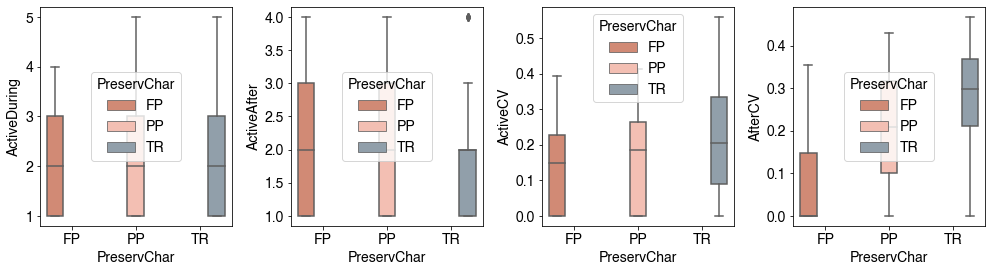

In [47]:
fig, ax = plt.subplots(1, 4, figsize = (14, 4), tight_layout = True)
sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveDuring', hue = 'PreservChar', palette = pres_palette, ax = ax[0])
sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveAfter', hue = 'PreservChar', palette = pres_palette, ax = ax[1])

sns.boxplot(data = allbars, x = 'PreservChar', y = 'ActiveCV', hue = 'PreservChar', palette = pres_palette, ax = ax[2])
sns.boxplot(data = allbars, x = 'PreservChar', y = 'AfterCV', hue = 'PreservChar', palette = pres_palette, ax = ax[3])

Activity metrics possibly? Want to look at numer of active channels/belt width, wetted width/active channels? In the context of preservation

In [31]:
int(ceil(len(ilocs)/2))

9

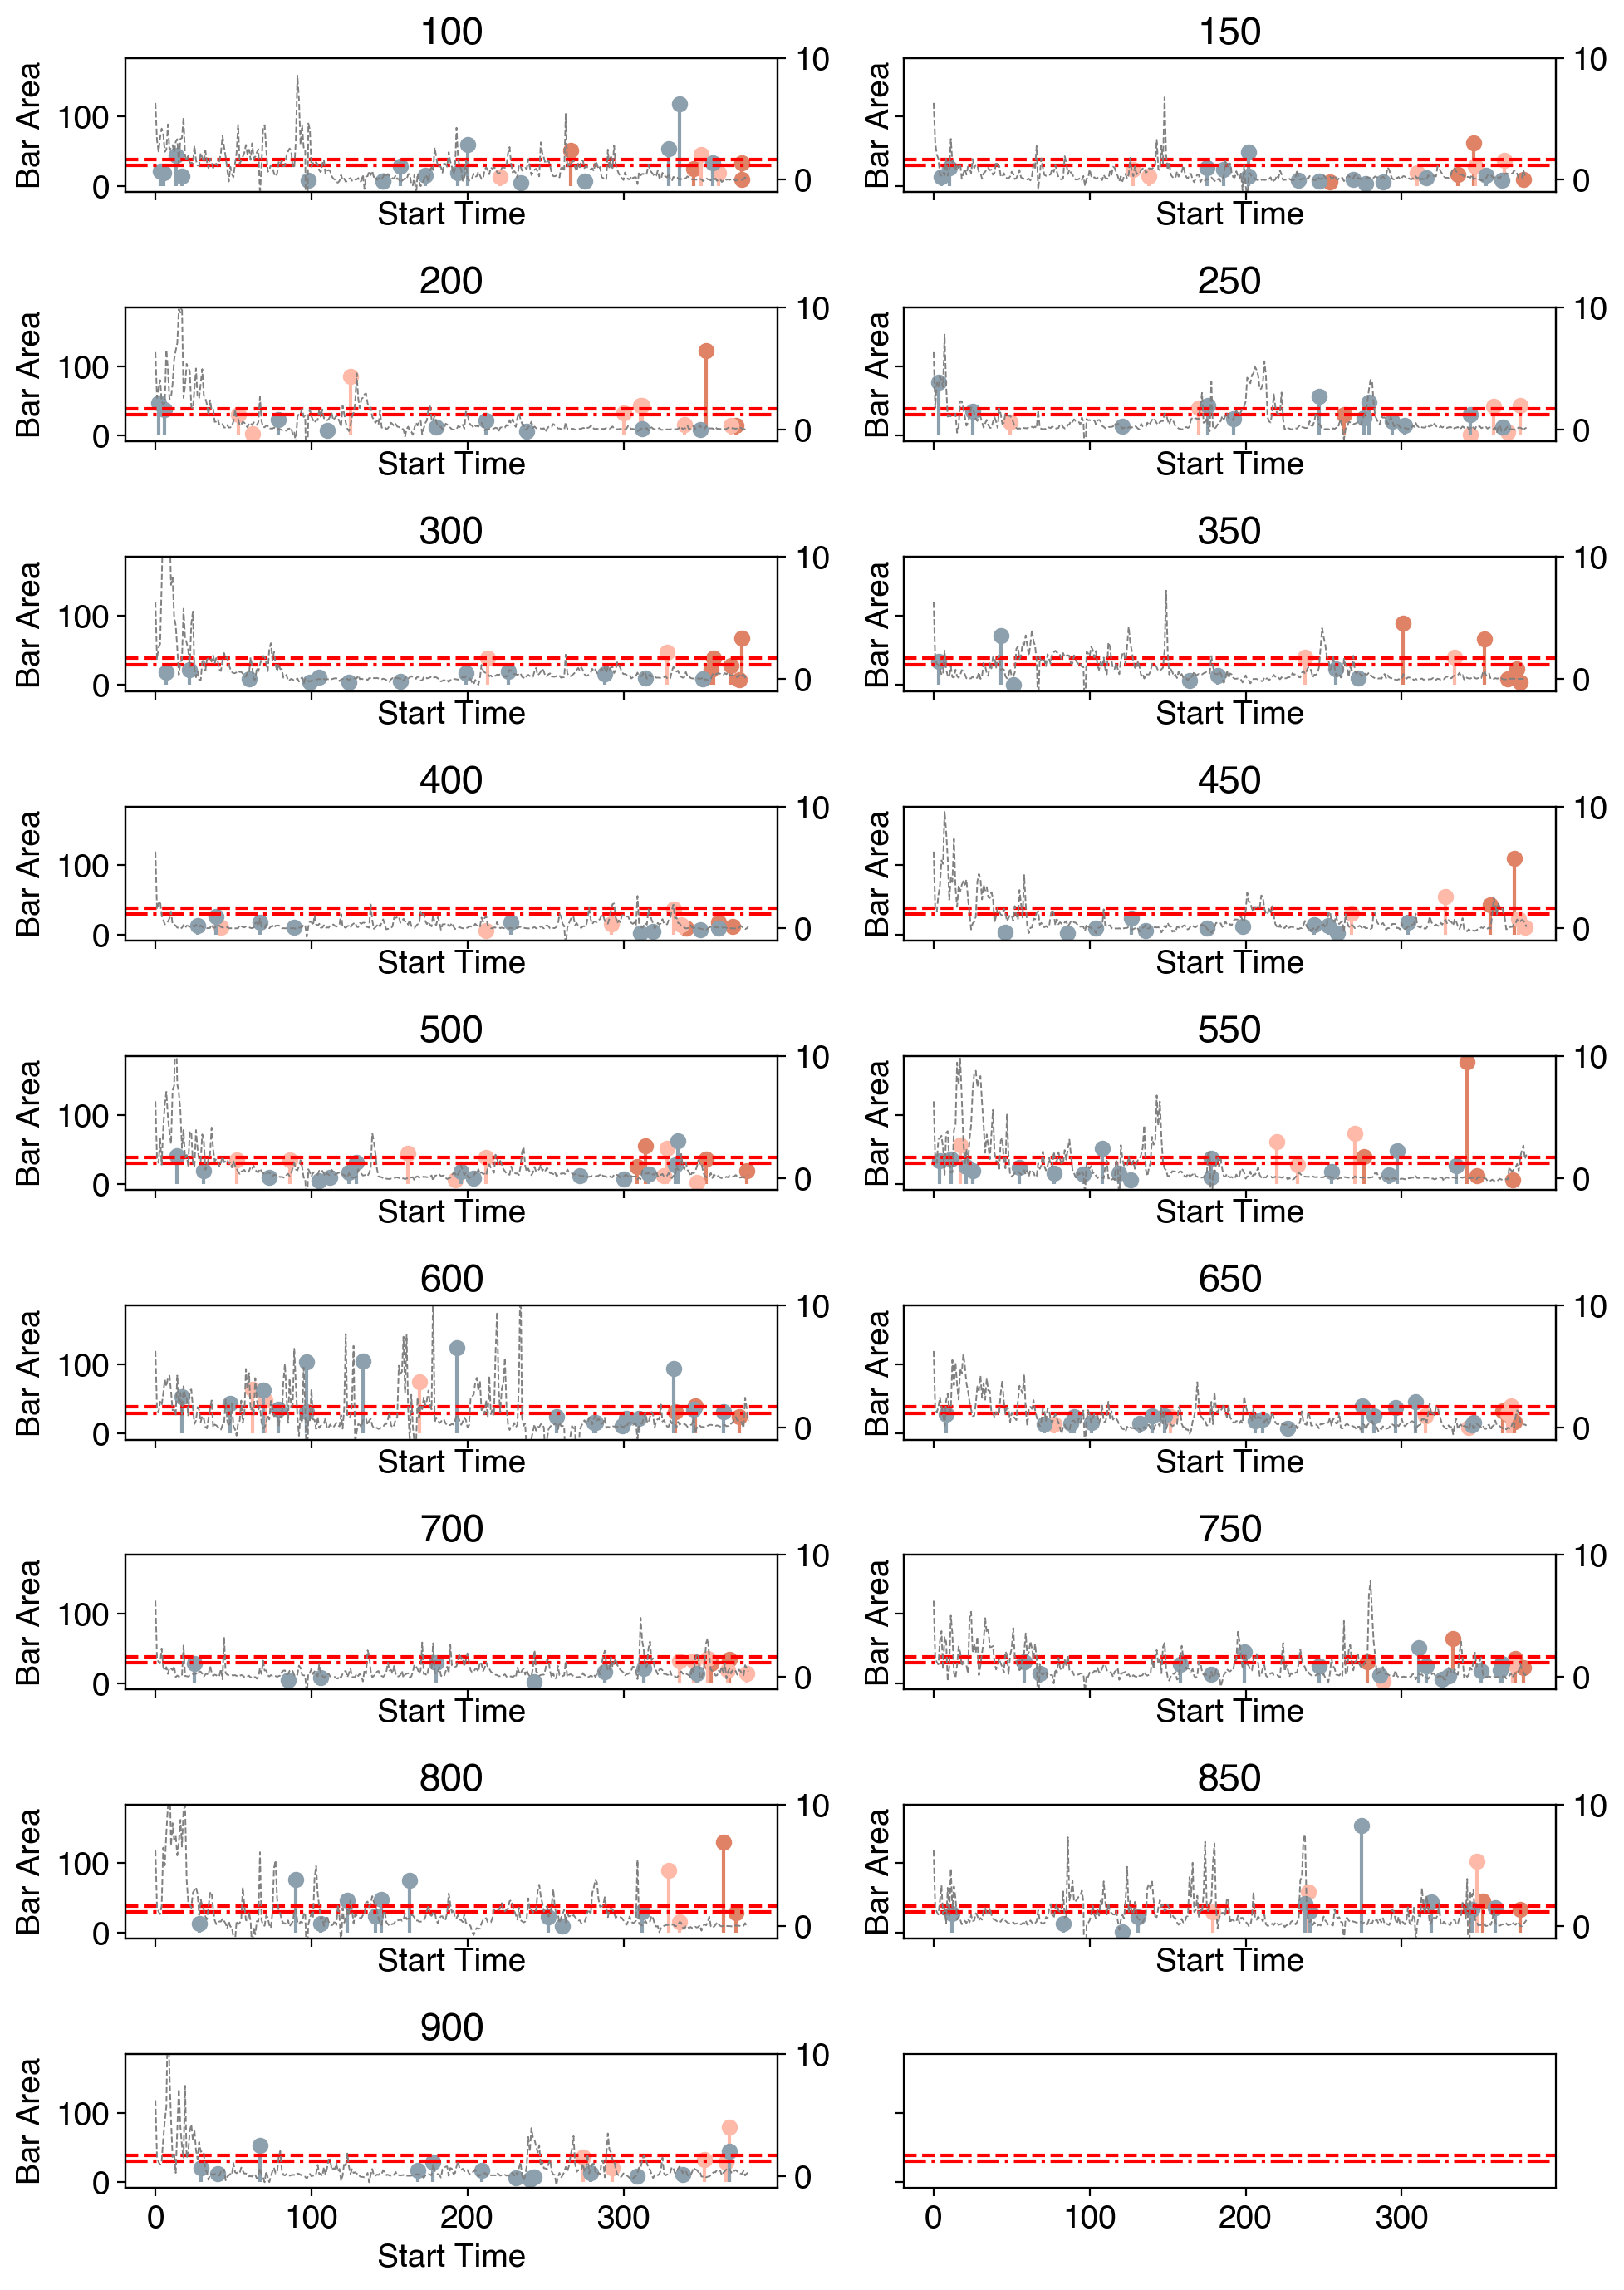

In [41]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True, sharey = True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['StartTime'], blank[blank['PreservChar']=='FP']['BarArea'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['StartTime'], blank[blank['PreservChar']=='PP']['BarArea'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['StartTime'], blank[blank['PreservChar']=='TR']['BarArea'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(total_wr_2h[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(-1, 10)
    ax[idx].set_ylabel('Bar Area')
    ax[idx].set_xlabel('Start Time')
    
for a in ax:
    a.axhline(np.nanmean(allbars['BarArea'][allbars['PreservChar']=='FP']), c = 'r', ls = '--')
    a.axhline(np.nanmedian(allbars['BarArea'][allbars['PreservChar']=='FP']), c = 'r', ls = '-.')

In [ ]:
sns.boxplot(data = allbars, x = 'PreservChar', y = 'BarArea', hue = 'PreservChar', palette = pres_palette, whis = (5, 95))

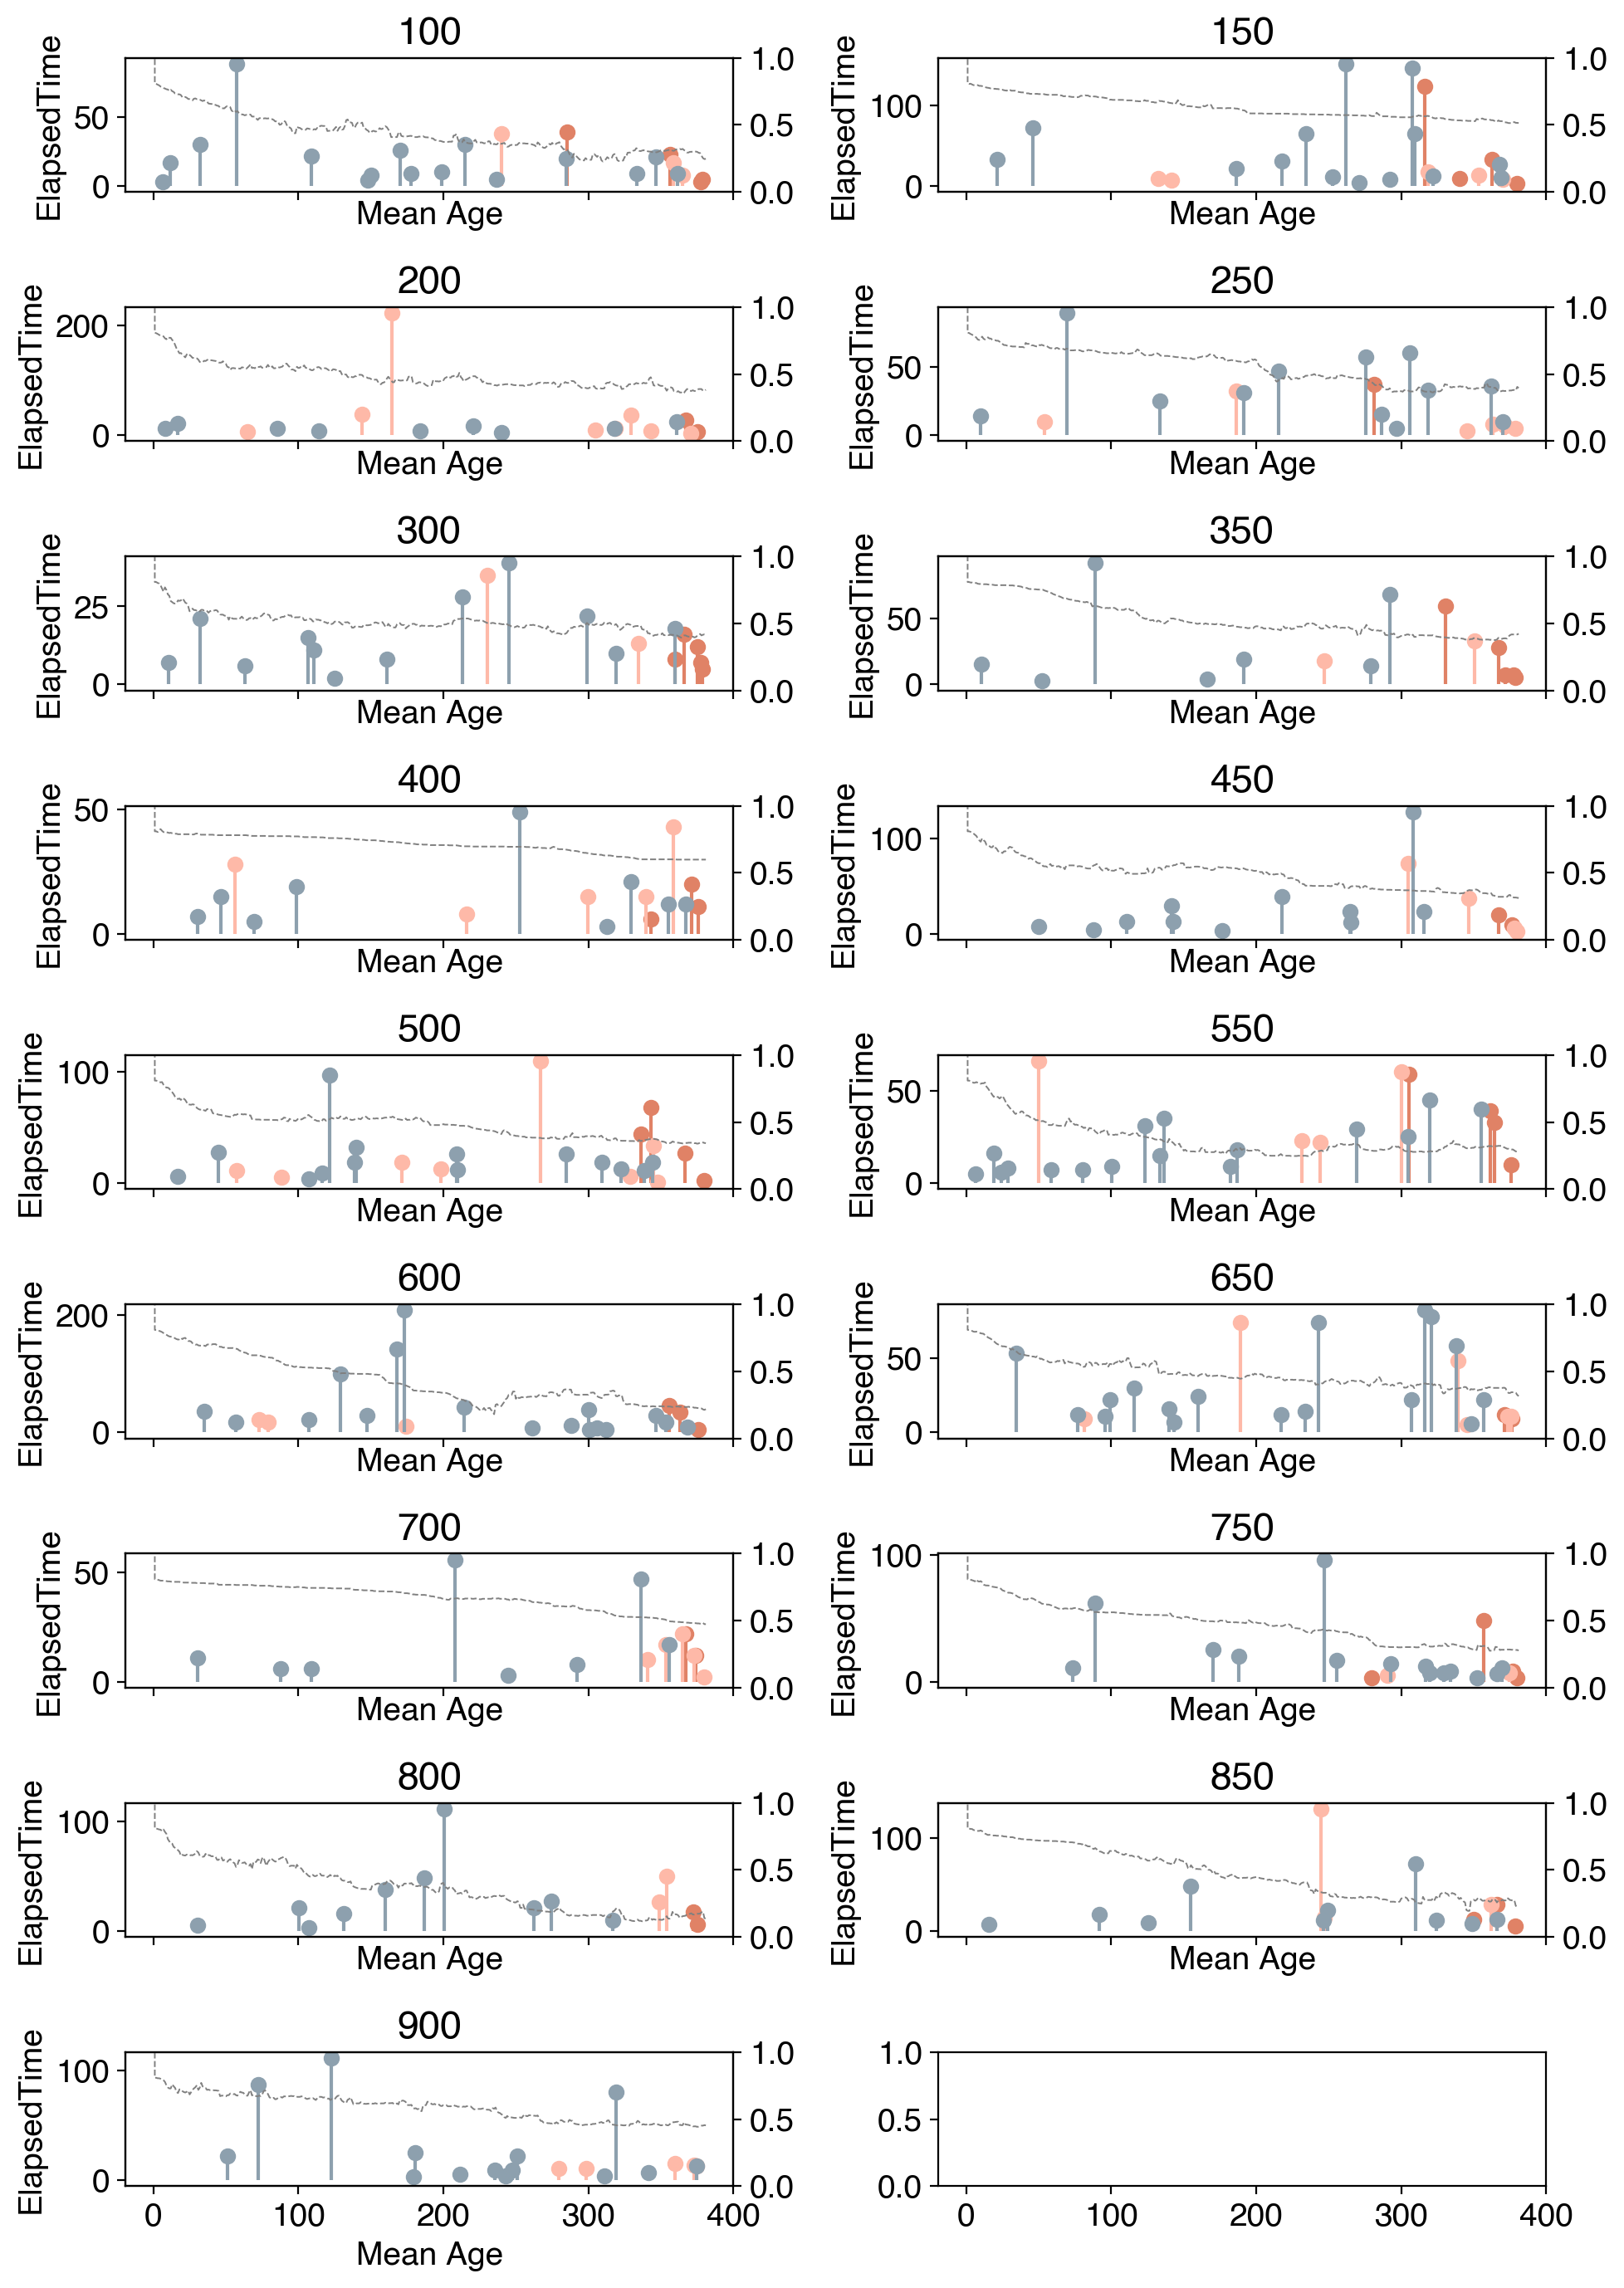

In [17]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(perc_untouched[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(0, 1)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')

In [21]:
wetted_width.shape

(1001, 382)

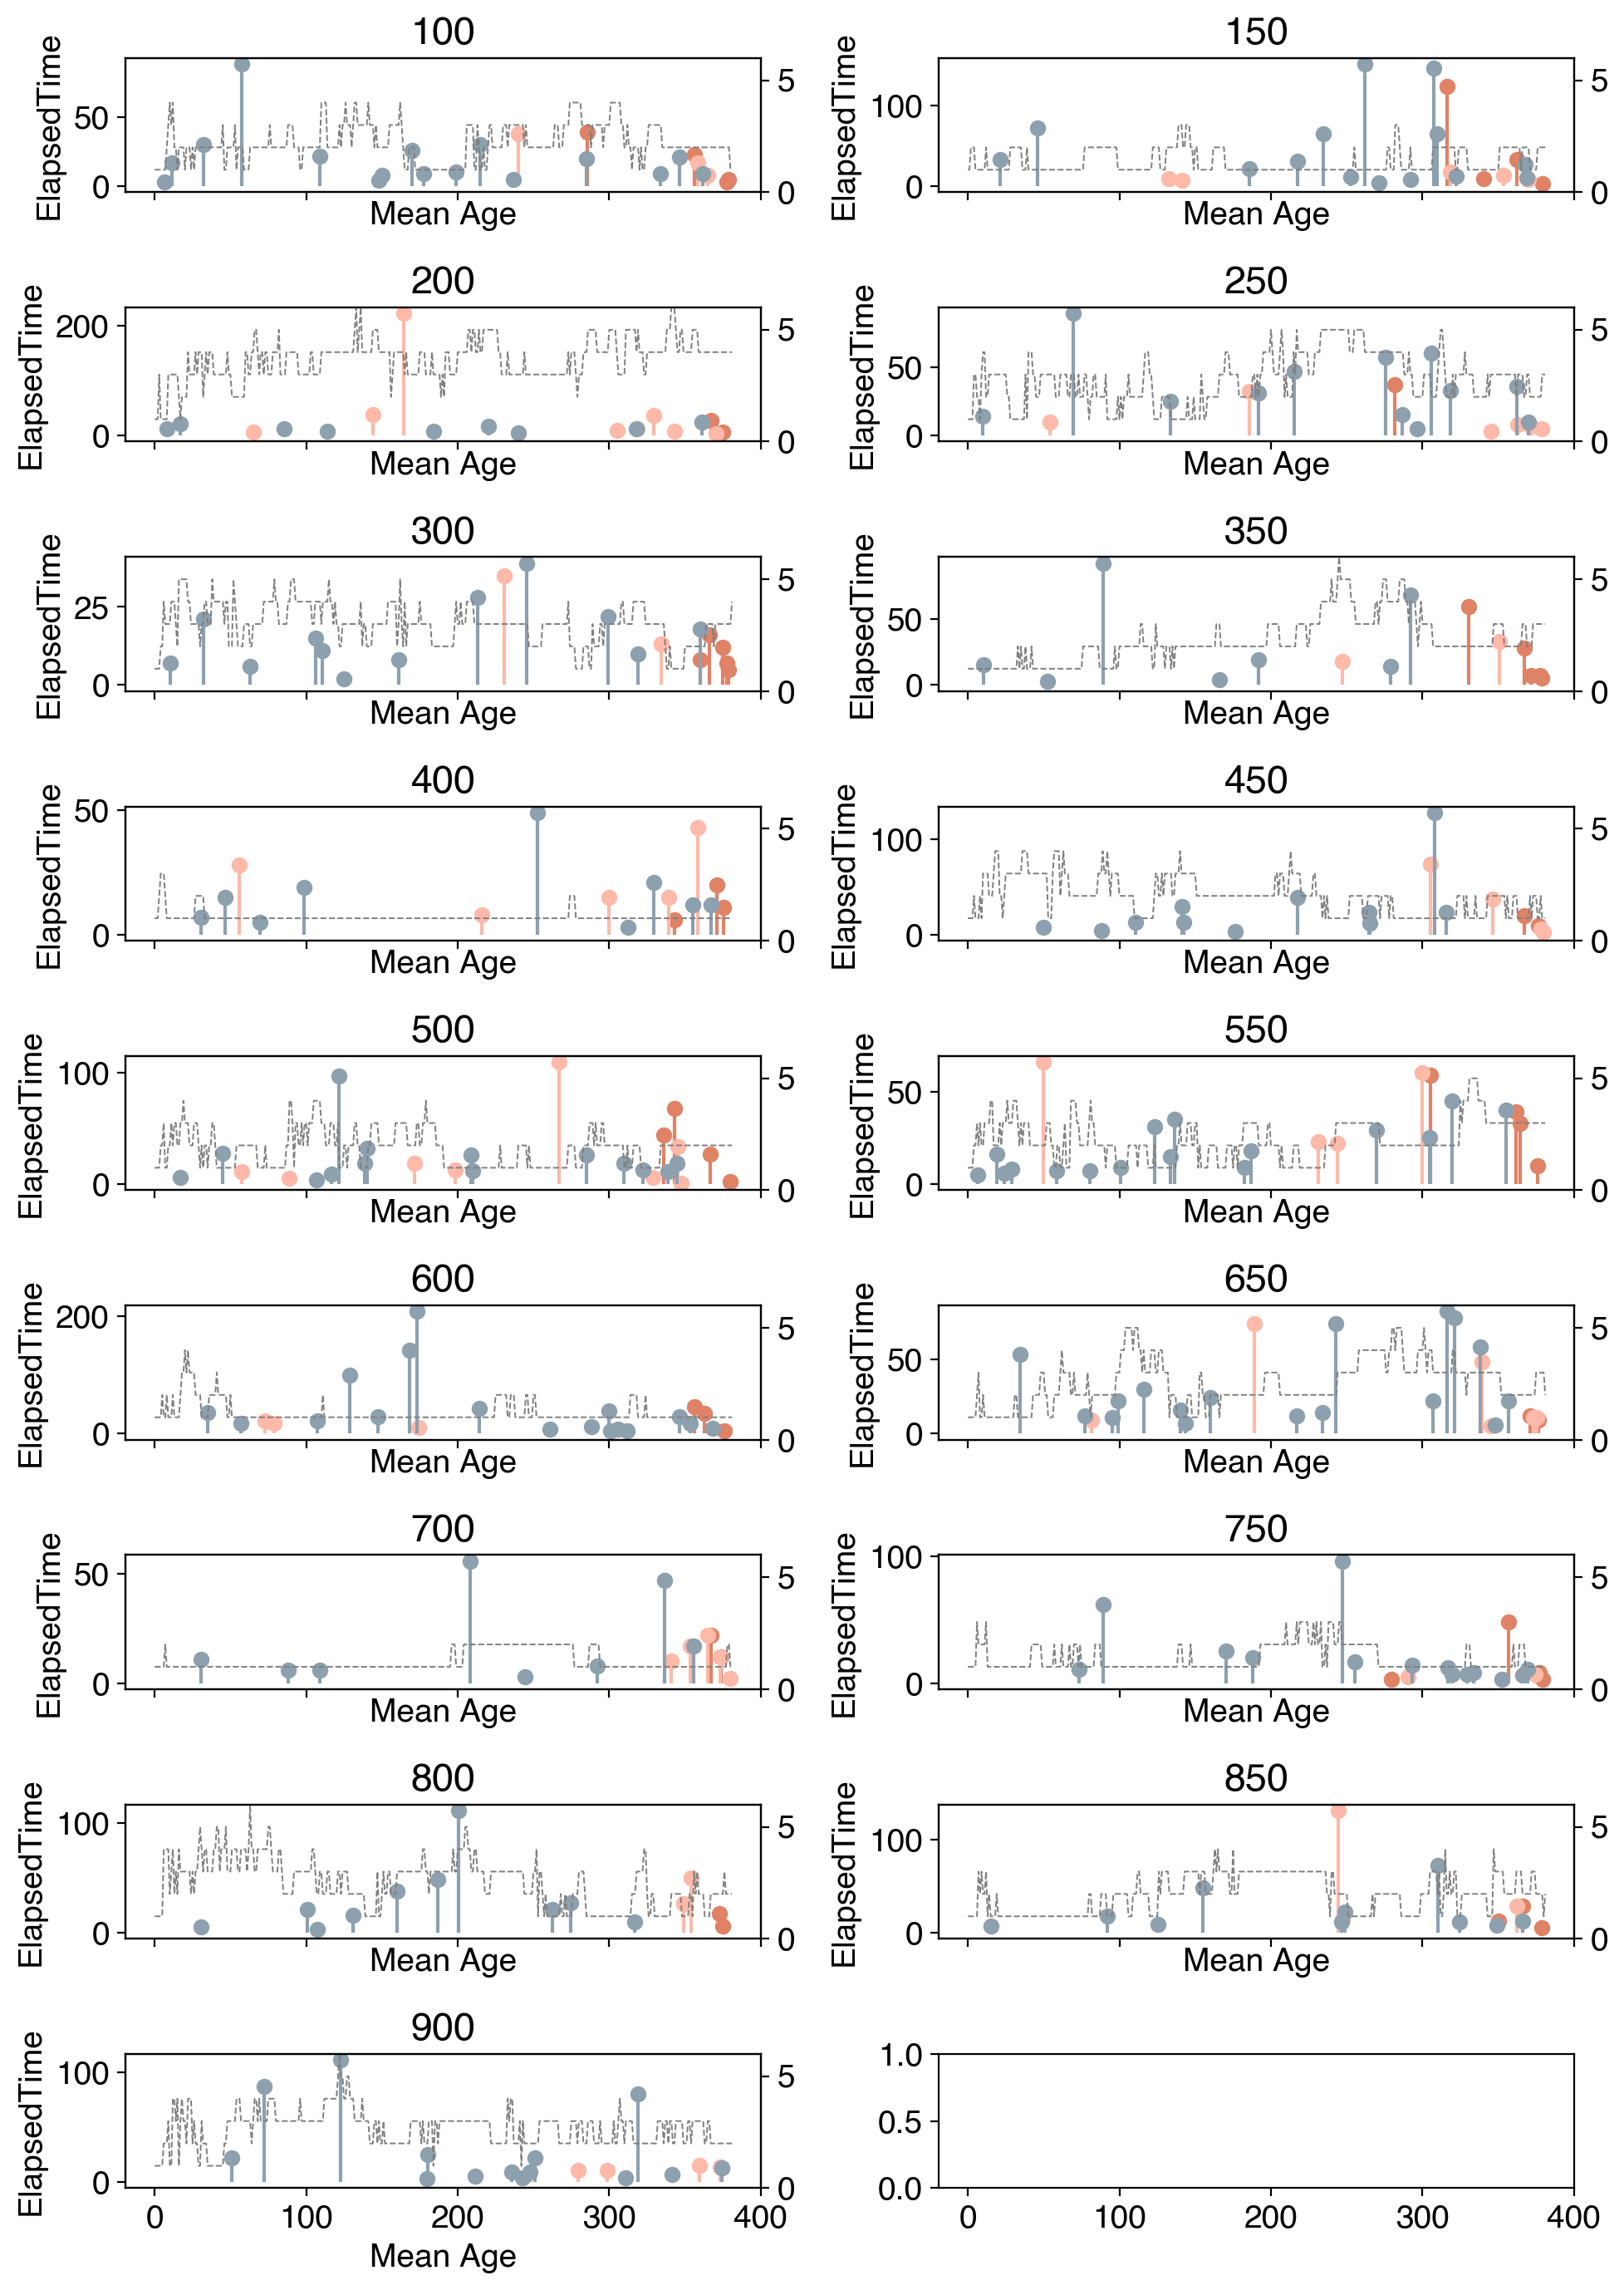

In [27]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(active_channels[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(0, 6)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')

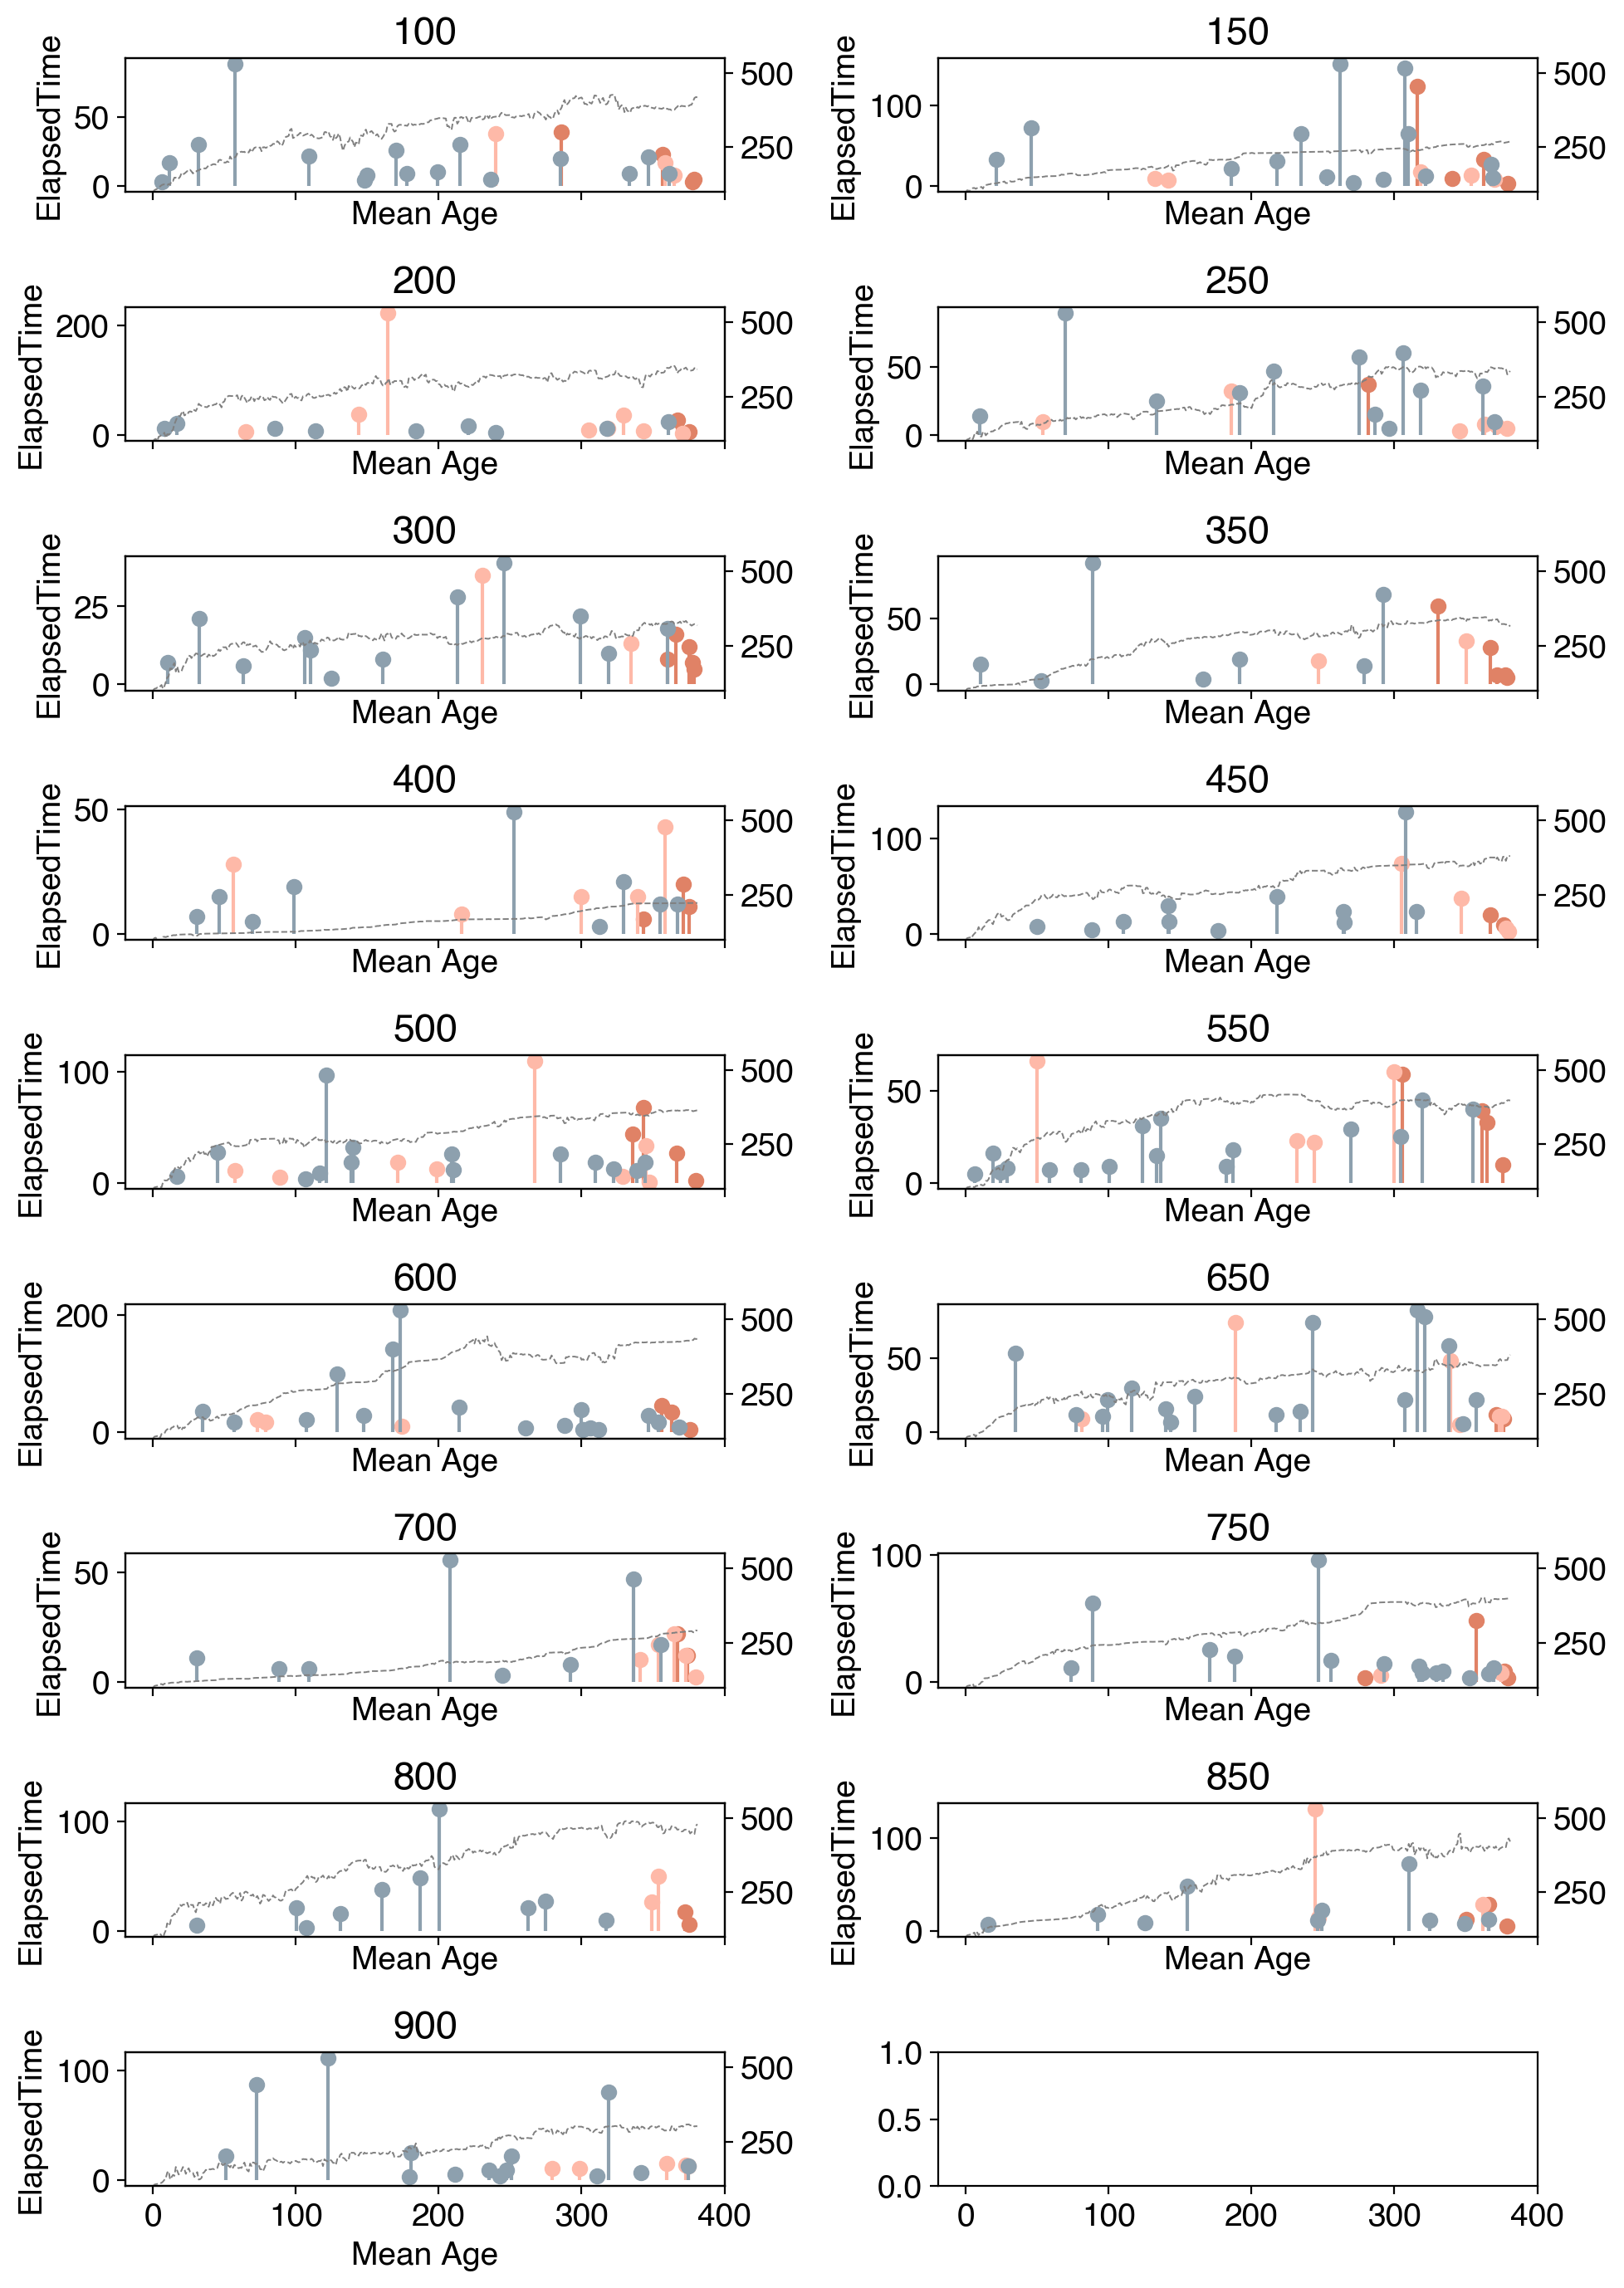

In [26]:
ilocs = np.arange(100, 901, 50)

fig, ax = plt.subplots(int(ceil(len(ilocs)/2)), 2, figsize = (10, 14), dpi = 200, sharex = True, tight_layout =True)
ax = ax.ravel()
for idx, i in enumerate(ilocs):
    blank = allbars[allbars['iloc']==i]
    mkrfp, stmfp, basefp = ax[idx].stem(blank[blank['PreservChar']=='FP']['MeanAge'], blank[blank['PreservChar']=='FP']['ElapsedTime'], linefmt = pres_cols[0], label = 'FP', basefmt = '')
    plt.setp(mkrfp, 'color', plt.getp(stmfp, 'color'))
    plt.setp(basefp, 'linewidth', 0)

    mkrpp, stmpp, basepp = ax[idx].stem(blank[blank['PreservChar']=='PP']['MeanAge'], blank[blank['PreservChar']=='PP']['ElapsedTime'], linefmt = pres_cols[1], label = 'PP', basefmt = '')
    plt.setp(mkrpp, 'color', plt.getp(stmpp, 'color'))
    plt.setp(basepp, 'linewidth', 0)

    mkrtr, stmtr, basetr = ax[idx].stem(blank[blank['PreservChar']=='TR']['MeanAge'], blank[blank['PreservChar']=='TR']['ElapsedTime'], linefmt = pres_cols[2], label = 'TR', basefmt = '')
    plt.setp(mkrtr, 'color', plt.getp(stmtr, 'color'))
    plt.setp(basetr, 'linewidth', 0)
    
    ax[idx].set_title(i)
    ax2 = ax[idx].twinx()
    # ax2.plot(profile_master[i, 5, :], 'k', label = 'RB', lw = 0.7, zorder=0) ## this is the indexing to get one row
    # ax2.plot(profile_master[i, 6, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0) 
    ax2.plot(wetted_width[i, :], color = 'grey', ls = '--', label = 'LB', lw = 0.7, zorder=0)
    ax2.set_ylim(100, 550)
    ax[idx].set_ylabel('ElapsedTime')
    ax[idx].set_xlabel('Mean Age')